In [1]:
link = 'D:/users/Marko/downloads/mirna/'

# Imports

In [2]:
%load_ext tensorboard

In [3]:
import sys
#sys.path.insert(0,'/content/drive/MyDrive/Marko/master')
sys.path.insert(0, link)
import numpy as np
import matplotlib.pyplot as plt

#import tensorflow as tf

import torch
import torch.optim as optim
import torch.nn as nn
import torch.distributions as dist

from torch.nn import functional as F
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm
from tqdm import trange

import datetime


writer = SummaryWriter(f"{link}/saved_models/new/IMVAE1/tensorboard")

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
DEVICE

device(type='cuda')

# Model Classes

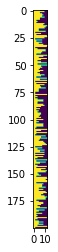

In [6]:
plt.imshow((torch.arange(13)[None, :] < torch.randint(2,14,(2,200))[:,:, None])[0])

In [7]:
a = torch.arange(13)[None, :] < torch.randint(2,14,(64,200))[:,:, None]

In [8]:
torch.arange(13)[None, :].shape, torch.randint(2,14,(64,200))[:,:, None].shape

(torch.Size([1, 13]), torch.Size([64, 200, 1]))

In [9]:
a = a.reshape(-1,2,100,13)

In [10]:
b = a[:,0,:,:].flip(2)
c = torch.cat([b,a[:,1,:,:12]], 2).permute(0,2,1)[:,None].repeat(1,3,1,1)

In [11]:
d = torch.randint(0,2,(64,3,2,100))

In [12]:
e = d[:,:,0,None,:].repeat(1,1,13,1)
f = d[:,:,1,None,:].repeat(1,1,12,1)
g = torch.cat([e,f],2)

In [13]:
g.shape, c.shape

(torch.Size([64, 3, 25, 100]), torch.Size([64, 3, 25, 100]))

In [14]:
x = torch.tensor([[0.03,0.37,.1,0.4,0.1]])
y = torch.tensor([[0,0,0,0,0],
                 [1,0,0,0,0],
                 [1,1,0,0,0],
                 [1,1,1,0,0],
                 [1,1,1,1,1],
                 ])

In [15]:
x.shape, y.shape

(torch.Size([1, 5]), torch.Size([5, 5]))

In [16]:
x_test = F.one_hot(torch.randint(0,13,(64,200)), num_classes=13)
x_test.shape

torch.Size([64, 200, 13])

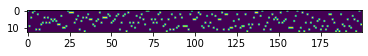

In [17]:
plt.imshow(x_test[0].T)

In [18]:
y_test = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0],
                       [1,0,0,0,0,0,0,0,0,0,0,0,0],
                       [1,1,0,0,0,0,0,0,0,0,0,0,0],
                       [1,1,1,0,0,0,0,0,0,0,0,0,0],
                       [1,1,1,1,1,0,0,0,0,0,0,0,0],
                       [1,1,1,1,1,1,0,0,0,0,0,0,0],
                       [1,1,1,1,1,1,1,0,0,0,0,0,0],
                       [1,1,1,1,1,1,1,1,0,0,0,0,0],
                       [1,1,1,1,1,1,1,1,1,0,0,0,0],
                       [1,1,1,1,1,1,1,1,1,1,0,0,0],
                       [1,1,1,1,1,1,1,1,1,1,1,0,0],
                       [1,1,1,1,1,1,1,1,1,1,1,1,0],
                       [1,1,1,1,1,1,1,1,1,1,1,1,1],
                 ])[None,:].repeat(64,1,1)
y_test.shape

torch.Size([64, 13, 13])

In [19]:
tst = torch.bmm(x_test,y_test)
tst.shape

torch.Size([64, 200, 13])

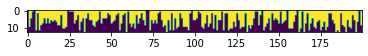

In [20]:
plt.imshow(tst[0].T)

In [21]:
x2 = torch.randint(0,2,(64,200,13))
y2 = torch.ones((64,13,13))

In [22]:
x2.T.shape

D:\Users\Marko\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2318.)
  """Entry point for launching an IPython kernel.


torch.Size([13, 200, 64])

In [23]:
torch.bmm(x2,y2).shape

RuntimeError: expected scalar type Float but found Long

In [ ]:
im = c*g+(~c)

In [ ]:
plt.imshow((im[0].permute(1,2,0)*255))

In [ ]:
plt.imshow((torch.arange(13)[None, :] < torch.randint(2,14,(2,200))[:,:, None])[1])

In [ ]:
torch.arange(13)[None, :].shape , torch.randint(2,14,(64,200))[:, :, None].shape

In [24]:
class diva_args:

    def __init__(self, z_dim=128, d_dim=45, x_dim=7500, y_dim=2,
                 beta=1, rec = 1,
                 warmup = 1, prewarmup = 1):

        self.z_dim = z_dim
        self.d_dim = d_dim
        self.x_dim = x_dim
        self.y_dim = y_dim
        
        self.beta = beta
        self.rec = rec
        self.warmup = warmup
        self.prewarmup = prewarmup


## Dataset Class

In [25]:
class MicroRNADataset(Dataset):

    def __init__(self, ds='train', create_encodings=False, use_subset=False):
        
        # loading images
        self.images = np.load(f'{link}/data/modmirbase_{ds}_images.npz')['arr_0']/255
        #self.images_cat = np.load(f'{link}/data/modmirbase_{ds}_images_cat_new.npz')
        
        # loading labels
        print('Loading Labels! (~10s)')     
        ohe = OneHotEncoder(categories='auto', sparse=False)
        labels = np.load(f'{link}/data/modmirbase_{ds}_labels.npz')['arr_0']
        self.labels = ohe.fit_transform(labels)
        
        
        self.mountain = np.load(f'{link}/data/modmirbase_{ds}_mountain.npy')
        
        
        # loading names
        print('Loading Names! (~5s)')
        names =  np.load(f'{link}/data/modmirbase_{ds}_names.npz')['arr_0']
        names = [i.decode('utf-8') for i in names]
        self.species = ['mmu', 'prd', 'hsa', 'ptr', 'efu', 'cbn', 'gma', 'pma',
                        'cel', 'gga', 'ipu', 'ptc', 'mdo', 'cgr', 'bta', 'cin', 
                        'ppy', 'ssc', 'ath', 'cfa', 'osa', 'mtr', 'gra', 'mml',
                        'stu', 'bdi', 'rno', 'oan', 'dre', 'aca', 'eca', 'chi',
                        'bmo', 'ggo', 'aly', 'dps', 'mdm', 'ame', 'ppc', 'ssa',
                        'ppt', 'tca', 'dme', 'sbi']
        # assigning a species label to each observation from species
        # with more than 200 observations from past research
        self.names = []
        for i in names:
            append = False
            for j in self.species:
                if j in i.lower():
                    self.names.append(j)
                    append = True
                    break
            if not append:
                if 'random' in i.lower() or i.isdigit():
                    self.names.append('hsa')
                else:
                    self.names.append('notfound')
        
        # performing one hot encoding
        ohe = OneHotEncoder(categories='auto', sparse=False)
        
       
        
        self.names_ohe = ohe.fit_transform(np.array(self.names).reshape(-1,1))
            
    def __len__(self):
        return(self.images.shape[0])

    def __getitem__(self, idx):
        d = self.names_ohe[idx]
        y = self.labels[idx]
        x = self.images[idx]
        x = np.transpose(x, (2,0,1))
        #x_cat = self.images_cat[idx]
        return (x, y, d)


    def get_encoded_values(self, x, ds):
        """
        given an image or batch of images
        returns length of strand, length of bars and colors of bars
        """
        n = x.shape[0]
        x = np.transpose(x, (0,3,1,2))
        out_len = np.zeros((n), dtype=np.uint8)
        out_col = np.zeros((n,26,100), dtype=np.uint8)
        out_bar = np.zeros((n,2,100), dtype=np.uint8)

        for i in range(n):
            if i % 100 == 0:
                print(f'at {i} out of {n}')
            rna_len = 0
            broke = False
            for j in range(100):
                if (x[i,:,12,j] == np.array([1,1,1])).all():
                    out_len[i] = rna_len
                    broke = True
                    out_col[i,25,j] = 1
                else:
                    rna_len += 1
                    # check color of bars
                    out_col[i, self.get_color(x,i,j),j] = 1 
                    #out_col[i, self.get_color(x[i,:,13,j]), 1, j] = 1
                    # check length of bars
                    len1 = 0
                    # loop until white pixel
                    while not (x[i,:,12-len1,j] == np.array([1.,1.,1.])).all():
                        len1 += 1
                        if 13-len1 == 0:
                            break
                    out_bar[i, 0, j] = len1

                    len2 = 0
                    while not (x[i,:,13+len2,j] == np.array([1.,1.,1.])).all():
                        len2 += 1
                        if 13+len2 == 25:
                            break
                    out_bar[i, 1, j] = len2
            if not broke:
                out_len[i] = rna_len


        with open(f'{link}/data/modmirbase_{ds}_images_len_new.npz', 'wb') as f:
            np.save(f, out_len)
        with open(f'{link}/data/modmirbase_{ds}_images_col_new.npz', 'wb') as f:
            np.save(f, out_col)
        with open(f'{link}/data/modmirbase_{ds}_images_bar_new.npz', 'wb') as f:
            np.save(f, out_bar)
        

        return out_len, out_bar, out_col

    def get_color(self, x, i, j):
        
        col = self._get_color(x[i,:,12,j])+self._get_color(x[i,:,13,j])
        if col == '00':
            return 0
        if col == '01':
            return 1
        if col == '02':
            return 2
        if col == '03':
            return 3
        if col == '04':
            return 4
        if col == '10':
            return 5
        if col == '11':
            return 6
        if col == '12':
            return 7
        if col == '13':
            return 8
        if col == '14':
            return 9
        if col == '20':
            return 10
        if col == '21':
            return 11
        if col == '22':
            return 12
        if col == '23':
            return 13
        if col == '24':
            return 14
        if col == '30':
            return 15
        if col == '31':
            return 16
        if col == '32':
            return 17
        if col == '33':
            return 18
        if col == '34':
            return 19
        if col == '40':
            return 20
        if col == '41':
            return 21
        if col == '42':
            return 22
        if col == '43':
            return 23
        if col == '44':
            return 24
        
        
    
    def _get_color(self, pixel):
        """
        returns the encoded value for a pixel
        """
        if (pixel == np.array([0,0,0])).all():  
            return "0" # black
        elif (pixel == np.array([1,0,0])).all():  
            return "1" # red
        elif (pixel == np.array([0,0,1])).all():  
            return "2" # blue
        elif (pixel == np.array([0,1,0])).all():  
            return "3" # green
        elif (pixel == np.array([1,1,0])).all():  
            return "4" # yellow
        else:
            print("Something wrong!")


## Decoder classes

In [77]:
# Decoders
class px(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, z_dim, dim1=256, dim2=512):
        super(px, self).__init__()

        self.fc = nn.Sequential(nn.Linear(z_dim, dim2),  
                                nn.ReLU(),
                                nn.Linear(dim2, dim2),
                                nn.ReLU())
        
        # Predicting length and color of each bar
        
        self.color = nn.Sequential(nn.Linear(dim2, 600), nn.Sigmoid())
        
        
        self.length_bar = nn.Sequential(nn.Linear(dim2,2600))
        
        # monster
        self.stamp = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0],
                                   [1,0,0,0,0,0,0,0,0,0,0,0,0],
                                   [1,1,0,0,0,0,0,0,0,0,0,0,0],
                                   [1,1,1,0,0,0,0,0,0,0,0,0,0],
                                   [1,1,1,1,1,0,0,0,0,0,0,0,0],
                                   [1,1,1,1,1,1,0,0,0,0,0,0,0],
                                   [1,1,1,1,1,1,1,0,0,0,0,0,0],
                                   [1,1,1,1,1,1,1,1,0,0,0,0,0],
                                   [1,1,1,1,1,1,1,1,1,0,0,0,0],
                                   [1,1,1,1,1,1,1,1,1,1,0,0,0],
                                   [1,1,1,1,1,1,1,1,1,1,1,0,0],
                                   [1,1,1,1,1,1,1,1,1,1,1,1,0],
                                   [1,1,1,1,1,1,1,1,1,1,1,1,1],
                 ])[None,:].to(DEVICE).float()
        
        
        
    def forward(self, z):
        
        h = self.fc(z)
        
        
        len_bar = self.length_bar(h).reshape(-1,13,200)
        len_bar = nn.Softmax(dim=1)(len_bar).permute(0,2,1)
        len_bar = torch.bmm(len_bar, self.stamp.repeat(len_bar.shape[0],1,1))#.permute(0,2,1)
        len_bar = len_bar.reshape(-1,2,100,13)
        msk2 = len_bar[:,1,:,:12]
        msk1 = len_bar[:,0,:,:].flip(2)
        bars = torch.cat([msk1,msk2], 2).permute(0,2,1)[:,None].repeat(1,3,1,1)
        
        col = self.color(h).reshape(-1,3,2,100)
        col_top = col[:,:,0,None,:].repeat(1,1,13,1)
        col_bot = col[:,:,1,None,:].repeat(1,1,12,1)
        color = torch.cat([col_top,col_bot],2)
        
        rna = color*bars+(1-bars)
        
        return rna


In [78]:
int(np.round(3.7, 0))
int(3.7)

3

In [79]:
# pzy_ = pzy(45, 7500, 2, 32,32,32)
# summary(pzy_, (1,2))
# pzy_ = px(45, 7500, 2, 32,32,32)
# summary(pzy_, [(1,32),(1,32),(1,32)])

## Endcoder Classes

In [80]:
#pzy_.reconstruct_image(torch.zeros((1,100)), torch.zeros((1,13,200)), torch.zeros(1,5,200)).shape

In [81]:
class qz(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, z_dim, h_dim=2592):
        super(qz, self).__init__()
        self.h_dim = h_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=5, stride=1, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(48, 48, kernel_size=5, stride=1, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(48, 60, kernel_size=3, stride=1, padding = 'same'),
            nn.ReLU(),
            nn.Conv2d(60, 60, kernel_size=3, stride=1, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(60, 72, kernel_size=3, stride=1, padding = 'same'),
            nn.ReLU(), 
            nn.Conv2d(72, 72, kernel_size=3, stride=1, padding = 'same'),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),
        )

        self.fc11 = nn.Sequential(nn.Linear(self.h_dim, z_dim))
        self.fc12 = nn.Sequential(nn.Linear(self.h_dim, z_dim), nn.Softplus())


    def forward(self, x):
        h = self.encoder(x)
        h = h.view(-1, self.h_dim)
        z_loc = self.fc11(h)
        z_scale = self.fc12(h) + 1e-7

        return z_loc, z_scale




In [82]:
enc = qz(128,10,10,512)
summary(enc, (1,3,25,100))

Layer (type:depth-idx)                   Output Shape              Param #
qz                                       --                        --
├─Sequential: 1-1                        [1, 72, 3, 12]            --
│    └─Conv2d: 2-1                       [1, 48, 25, 100]          3,648
│    └─ReLU: 2-2                         [1, 48, 25, 100]          --
│    └─Conv2d: 2-3                       [1, 48, 25, 100]          57,648
│    └─ReLU: 2-4                         [1, 48, 25, 100]          --
│    └─MaxPool2d: 2-5                    [1, 48, 12, 50]           --
│    └─Conv2d: 2-6                       [1, 60, 12, 50]           25,980
│    └─ReLU: 2-7                         [1, 60, 12, 50]           --
│    └─Conv2d: 2-8                       [1, 60, 12, 50]           32,460
│    └─ReLU: 2-9                         [1, 60, 12, 50]           --
│    └─MaxPool2d: 2-10                   [1, 60, 6, 25]            --
│    └─Conv2d: 2-11                      [1, 72, 6, 25]            38,

## Full model class

In [83]:
class StampDIVA(nn.Module):
    def __init__(self, args):
        super(StampDIVA, self).__init__()
        self.z_dim = args.z_dim
        self.d_dim = args.d_dim
        self.x_dim = args.x_dim
        self.y_dim = args.y_dim

        self.px = px(self.d_dim, self.x_dim, self.y_dim, self.z_dim)
        
        self.qz = qz(self.d_dim, self.x_dim, self.y_dim, self.z_dim)
        

        self.beta = args.beta
        
        self.rec = args.rec
        self.warmup = args.warmup
        self.prewarmup = args.prewarmup

        self.cuda()

    def forward(self, d, x, y):
        # Encode
        zd_q_loc, zd_q_scale = self.qz(x)
        
        # Reparameterization trick
        qz = dist.Normal(zd_q_loc, zd_q_scale)
        z_q = qz.rsample()
        
        
        # Decode
        x_hat = self.px(z_q)
        z_p_loc, z_p_scale = torch.zeros(z_q.size()[0], self.z_dim).cuda(),\
                        torch.ones(z_q.size()[0], self.z_dim).cuda()
        
        pz = dist.Normal(z_p_loc, z_p_scale)
        
        return x_hat, qz, pz, z_q

    def loss_function(self, d, x, y, idx1=0, idx2=25):
        
        x_hat, qz, pz, z_q = self.forward(d, x, y)
       
        mse = (((x_hat[:,:,idx1:idx2] - x[:,:,idx1:idx2])**2)).sum()
        
        KL_z = torch.sum(pz.log_prob(z_q) - qz.log_prob(z_q))
          
        return self.rec * mse - self.beta * KL_z, mse

In [84]:
default_args = diva_args(z_dim=256, rec = 10, 
                         beta=1, warmup=1, prewarmup=0)
enc = StampDIVA(default_args)
summary(enc,[ (1,1),(1,3,25,100),(1,1)])

Layer (type:depth-idx)                   Output Shape              Param #
StampDIVA                                --                        --
├─qz: 1-1                                [1, 256]                  --
│    └─Sequential: 2-1                   [1, 72, 3, 12]            --
│    │    └─Conv2d: 3-1                  [1, 48, 25, 100]          3,648
│    │    └─ReLU: 3-2                    [1, 48, 25, 100]          --
│    │    └─Conv2d: 3-3                  [1, 48, 25, 100]          57,648
│    │    └─ReLU: 3-4                    [1, 48, 25, 100]          --
│    │    └─MaxPool2d: 3-5               [1, 48, 12, 50]           --
│    │    └─Conv2d: 3-6                  [1, 60, 12, 50]           25,980
│    │    └─ReLU: 3-7                    [1, 60, 12, 50]           --
│    │    └─Conv2d: 3-8                  [1, 60, 12, 50]           32,460
│    │    └─ReLU: 3-9                    [1, 60, 12, 50]           --
│    │    └─MaxPool2d: 3-10              [1, 60, 6, 25]            --


# Training the model

## Loading dataset

In [85]:
RNA_dataset = MicroRNADataset(create_encodings=False)

Loading Labels! (~10s)
Loading Names! (~5s)


In [86]:
RNA_dataset_test = MicroRNADataset('test', create_encodings=False)

Loading Labels! (~10s)
Loading Names! (~5s)


In [87]:
len(RNA_dataset)

34721

In [88]:
def train_single_epoch(train_loader, model, optimizer, epoch, idx1=0, idx2=25):
    model.train()
    train_loss = 0
    no_batches = 0
    mse_t = 0
    pbar = tqdm(enumerate(train_loader), unit="batch", 
                                     desc=f'Epoch {epoch}')
    for batch_idx, (x, y, d) in pbar:
        # To device
        x, y, d = x.to(DEVICE), y.to(DEVICE), d.to(DEVICE)

        optimizer.zero_grad()
        loss, mse = model.loss_function(d.float(), x.float(), y.float(), idx1, idx2)
      
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item()/x.shape[0])
        train_loss += loss
        mse_t += mse
        no_batches += 1

    train_loss /= len(train_loader.dataset)
    mse_t /= len(train_loader.dataset)
    
    return train_loss, mse_t

In [89]:
def test_single_epoch(test_loader, model, epoch, idx1=0, idx2=25):
    model.eval()
    test_loss = 0
    mse_t = 0
    with torch.no_grad():
        for batch_idx, (x,y,d) in enumerate(test_loader):
            x, y, d= x.to(DEVICE), y.to(DEVICE), d.to(DEVICE)
            loss , mse = model.loss_function(d.float(), x.float(), y.float(), idx1, idx2)
            test_loss += loss
            mse_t += mse
            
    test_loss /= len(test_loader.dataset)
    mse_t /= len(test_loader.dataset)
    
    return test_loss, mse_t
  

In [90]:
def train(args, train_loader, test_loader, diva, optimizer, end_epoch, start_epoch=0, save_folder='sd_1.0.0',save_interval=5):
    
    epoch_loss_sup = []
    test_loss = []
    
    for epoch in range(start_epoch+1, end_epoch+1):
        idx1, idx2 = choose_index(epoch)
        diva.beta = min([args.beta, args.beta * (epoch - args.prewarmup * 1.) / (args.warmup)])
        if epoch< args.prewarmup:
            diva.beta = args.beta/args.prewarmup
        train_loss , mtr = train_single_epoch(train_loader, diva, optimizer, epoch, idx1, idx2)
        str_loss_sup = train_loss
        epoch_loss_sup.append(train_loss)
        str_print = "epoch {}: avg train loss {:.2f}".format(epoch, str_loss_sup)
        str_print += ", mse {:.3f}".format(mtr)
        print(str_print)

        rec_loss_train = diva.rec * mtr
        dis_loss_train = train_loss - rec_loss_train

        test_lss, mte = test_single_epoch(test_loader, diva, epoch, idx1, idx2)
        test_loss.append(test_lss)
       
        str_print = "epoch {}: avg test  loss {:.2f}".format(epoch, test_lss)
        str_print += ", mse {:.3f}".format(mte)
        print(str_print)

        rec_loss_test = diva.rec* mte
        dis_loss_test = test_lss - rec_loss_test

        if writer is not None:
            
            writer.add_scalars("Total_Loss", {'train': train_loss, 'test': test_lss} ,epoch)
            writer.add_scalars("Reconstruction_vs_Disentanglement",{'rec':rec_loss_train, 'dis':dis_loss_train}, epoch)
            writer.add_scalars("bar_mse",{'train': mtr, 'test':mte}, epoch)
           
        if epoch % save_interval == 0:
            save_reconstructions(epoch, test_loader, diva, name=save_folder)
            save_reconstructions(epoch, train_loader, diva, name=save_folder, estr='tr')
        
        
        if epoch % 50 == 0:
            torch.save(diva.state_dict(), f'{link}/saved_models/{save_folder}/checkpoints/{epoch}.pth')

    if writer is not None:
        writer.flush()

    epoch_loss_sup = [i.detach().cpu().numpy() for i in epoch_loss_sup]
    test_loss = [i.detach().cpu().numpy() for i in test_loss]
    return epoch_loss_sup, test_loss

In [91]:
def choose_index(epoch):
    s1,s2,s3,s4 = 50, 75, 90, 100
    if epoch < s1:
        idx = (11,15)
    elif s1 <= epoch < s2:
        idx = (7, 19)
    elif s2 <= epoch < s3:
        idx = (5, 21)
    elif s3 <= epoch < s4:
        idx = (3,23)
    elif s4 <= epoch:
        idx = (0,25)
    return idx

In [92]:
def save_reconstructions(epoch, test_loader, diva, name='diva', estr=''):
    a = next(enumerate(test_loader))
    with torch.no_grad():
        diva.eval()
        d = a[1][2][:10].to(DEVICE).float()
        x = a[1][0][:10].to(DEVICE).float()
        y = a[1][1][:10].to(DEVICE).float()
        x_hat ,qz, pz, z_q = diva(d,x,y)
        out = x_hat.round().permute(0,2,3,1)

    plt.figure(figsize=(80,20))
    fig, ax = plt.subplots(nrows=10, ncols=2)

    ax[0,0].set_title("Original")
    ax[0,1].set_title("Reconstructed")

    for i in range(10):
        ax[i, 1].imshow(out[i].cpu())
        ax[i, 0].imshow(x[i].cpu().permute(1,2,0))
        ax[i, 0].xaxis.set_visible(False)
        ax[i, 0].yaxis.set_visible(False)
        ax[i, 1].xaxis.set_visible(False)
        ax[i, 1].yaxis.set_visible(False)
    fig.tight_layout(pad=0.1)
    plt.savefig(f'{link}/saved_models/{name}/reconstructions/e{epoch}{estr}.png')
    plt.close('all')

In [93]:
DEVICE

device(type='cuda')

## Model Training

In [94]:
default_args = diva_args(z_dim=256, rec = 1, 
                         beta=1, warmup=1, prewarmup=0)

In [95]:
diva = StampDIVA(default_args).to(DEVICE)

In [96]:
#diva.load_state_dict(torch.load(f'{link}/saved_models/VAE10/checkpoints/905.pth'))

In [97]:
train_loader = DataLoader(RNA_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(RNA_dataset_test, batch_size=128)

In [98]:
#optimizer = optim.SGD(diva.parameters(), lr=0.00001, momentum=0.1, nesterov=True)
optimizer = optim.Adam(diva.parameters(), lr=0.0001)

In [99]:
#RNA_dataset.x_len.min(), RNA_dataset.x_len.max()

In [100]:
writer.flush()

In [75]:
%tensorboard --logdir="D:/users/Marko/downloads/mirna/saved_models/new/IMVAE1/tensorboard/" --host localhost

In [101]:
lss, lss_t = train(default_args, train_loader, test_loader, diva, optimizer, 500, 0, save_folder="new/IMVAE1",save_interval=5)

Epoch 1: 272batch [00:18, 14.33batch/s, loss=189]


epoch 1: avg train loss 192.25, mse 190.154
epoch 1: avg test  loss 179.95, mse 178.931


Epoch 2: 272batch [00:18, 14.42batch/s, loss=151]


epoch 2: avg train loss 166.58, mse 162.838


Epoch 3: 2batch [00:00, 14.18batch/s, loss=154]

epoch 2: avg test  loss 157.51, mse 152.720


Epoch 3: 272batch [00:19, 14.21batch/s, loss=152]


epoch 3: avg train loss 156.19, mse 151.010


Epoch 4: 2batch [00:00, 14.29batch/s, loss=154]

epoch 3: avg test  loss 154.97, mse 149.963


Epoch 4: 272batch [00:18, 14.35batch/s, loss=157]


epoch 4: avg train loss 154.74, mse 149.316


Epoch 5: 2batch [00:00, 14.29batch/s, loss=160]

epoch 4: avg test  loss 154.06, mse 148.861


Epoch 5: 272batch [00:19, 14.31batch/s, loss=154]


epoch 5: avg train loss 153.88, mse 148.392
epoch 5: avg test  loss 153.31, mse 147.612


Epoch 6: 272batch [00:19, 14.20batch/s, loss=148]


epoch 6: avg train loss 153.17, mse 147.626


Epoch 7: 2batch [00:00, 14.60batch/s, loss=152]

epoch 6: avg test  loss 152.71, mse 147.632


Epoch 7: 272batch [00:19, 14.30batch/s, loss=150]


epoch 7: avg train loss 152.58, mse 146.984


Epoch 8: 2batch [00:00, 13.51batch/s, loss=151]

epoch 7: avg test  loss 152.15, mse 146.526


Epoch 8: 272batch [00:18, 14.33batch/s, loss=141]


epoch 8: avg train loss 152.11, mse 146.440


Epoch 9: 2batch [00:00, 14.39batch/s, loss=147]

epoch 8: avg test  loss 151.68, mse 146.234


Epoch 9: 272batch [00:19, 14.27batch/s, loss=158]


epoch 9: avg train loss 151.62, mse 145.951


Epoch 10: 2batch [00:00, 13.89batch/s, loss=151]

epoch 9: avg test  loss 151.43, mse 145.777


Epoch 10: 272batch [00:19, 14.29batch/s, loss=150]


epoch 10: avg train loss 151.23, mse 145.557
epoch 10: avg test  loss 150.88, mse 144.909


Epoch 11: 272batch [00:19, 14.23batch/s, loss=152]


epoch 11: avg train loss 150.82, mse 145.144


Epoch 12: 2batch [00:00, 13.89batch/s, loss=162]

epoch 11: avg test  loss 150.61, mse 144.631


Epoch 12: 272batch [00:19, 14.29batch/s, loss=142]


epoch 12: avg train loss 150.53, mse 144.855


Epoch 13: 2batch [00:00, 12.99batch/s, loss=152]

epoch 12: avg test  loss 150.25, mse 144.581


Epoch 13: 272batch [00:19, 14.21batch/s, loss=139]


epoch 13: avg train loss 150.21, mse 144.558


Epoch 14: 2batch [00:00, 14.08batch/s, loss=152]

epoch 13: avg test  loss 149.94, mse 144.327


Epoch 14: 272batch [00:19, 14.18batch/s, loss=156]


epoch 14: avg train loss 149.96, mse 144.304


Epoch 15: 2batch [00:00, 14.39batch/s, loss=150]

epoch 14: avg test  loss 149.66, mse 144.043


Epoch 15: 272batch [00:19, 14.09batch/s, loss=147]


epoch 15: avg train loss 149.63, mse 144.026
epoch 15: avg test  loss 149.29, mse 143.716


Epoch 16: 272batch [00:19, 14.12batch/s, loss=137]


epoch 16: avg train loss 149.21, mse 143.736


Epoch 17: 2batch [00:00, 14.08batch/s, loss=144]

epoch 16: avg test  loss 148.93, mse 143.938


Epoch 17: 272batch [00:19, 14.27batch/s, loss=134]


epoch 17: avg train loss 148.58, mse 143.317


Epoch 18: 2batch [00:00, 13.99batch/s, loss=147]

epoch 17: avg test  loss 148.14, mse 143.005


Epoch 18: 272batch [00:19, 14.25batch/s, loss=149]


epoch 18: avg train loss 147.79, mse 142.853


Epoch 19: 2batch [00:00, 14.18batch/s, loss=145]

epoch 18: avg test  loss 147.41, mse 142.161


Epoch 19: 272batch [00:18, 14.34batch/s, loss=151]


epoch 19: avg train loss 147.00, mse 142.274


Epoch 20: 2batch [00:00, 14.08batch/s, loss=145]

epoch 19: avg test  loss 146.51, mse 141.972


Epoch 20: 272batch [00:19, 14.31batch/s, loss=140]


epoch 20: avg train loss 146.15, mse 141.449
epoch 20: avg test  loss 145.62, mse 141.052


Epoch 21: 272batch [00:19, 14.29batch/s, loss=140]


epoch 21: avg train loss 145.27, mse 140.470


Epoch 22: 2batch [00:00, 14.39batch/s, loss=150]

epoch 21: avg test  loss 145.05, mse 140.338


Epoch 22: 272batch [00:19, 14.14batch/s, loss=137]


epoch 22: avg train loss 144.66, mse 139.832


Epoch 23: 2batch [00:00, 14.29batch/s, loss=144]

epoch 22: avg test  loss 144.61, mse 139.906


Epoch 23: 272batch [00:19, 14.08batch/s, loss=147]


epoch 23: avg train loss 144.29, mse 139.481


Epoch 24: 2batch [00:00, 14.18batch/s, loss=144]

epoch 23: avg test  loss 144.31, mse 139.610


Epoch 24: 272batch [00:19, 14.19batch/s, loss=142]


epoch 24: avg train loss 143.94, mse 139.143


Epoch 25: 2batch [00:00, 13.42batch/s, loss=141]

epoch 24: avg test  loss 143.77, mse 139.090


Epoch 25: 272batch [00:19, 14.18batch/s, loss=139]


epoch 25: avg train loss 143.63, mse 138.866
epoch 25: avg test  loss 143.49, mse 138.695


Epoch 26: 272batch [00:19, 14.16batch/s, loss=155]


epoch 26: avg train loss 143.43, mse 138.679


Epoch 27: 2batch [00:00, 14.29batch/s, loss=143]

epoch 26: avg test  loss 143.31, mse 138.436


Epoch 27: 272batch [00:19, 14.18batch/s, loss=140]


epoch 27: avg train loss 143.26, mse 138.482


Epoch 28: 2batch [00:00, 13.70batch/s, loss=147]

epoch 27: avg test  loss 143.09, mse 138.357


Epoch 28: 272batch [00:19, 14.12batch/s, loss=150]


epoch 28: avg train loss 143.07, mse 138.336


Epoch 29: 2batch [00:00, 14.08batch/s, loss=142]

epoch 28: avg test  loss 142.95, mse 138.189


Epoch 29: 272batch [00:19, 14.10batch/s, loss=144]


epoch 29: avg train loss 142.92, mse 138.183


Epoch 30: 2batch [00:00, 14.18batch/s, loss=146]

epoch 29: avg test  loss 142.79, mse 138.033


Epoch 30: 272batch [00:19, 14.15batch/s, loss=137]


epoch 30: avg train loss 142.80, mse 138.058
epoch 30: avg test  loss 142.67, mse 137.896


Epoch 31: 272batch [00:19, 14.09batch/s, loss=150]


epoch 31: avg train loss 142.67, mse 137.918


Epoch 32: 2batch [00:00, 13.70batch/s, loss=140]

epoch 31: avg test  loss 142.60, mse 137.738


Epoch 32: 272batch [00:19, 14.17batch/s, loss=151]


epoch 32: avg train loss 142.54, mse 137.776


Epoch 33: 2batch [00:00, 14.18batch/s, loss=141]

epoch 32: avg test  loss 142.49, mse 137.783


Epoch 33: 272batch [00:19, 14.29batch/s, loss=130]


epoch 33: avg train loss 142.40, mse 137.635


Epoch 34: 2batch [00:00, 14.08batch/s, loss=145]

epoch 33: avg test  loss 142.38, mse 137.533


Epoch 34: 272batch [00:19, 14.28batch/s, loss=144]


epoch 34: avg train loss 142.30, mse 137.485


Epoch 35: 2batch [00:00, 14.29batch/s, loss=139]

epoch 34: avg test  loss 142.26, mse 137.384


Epoch 35: 272batch [00:19, 14.28batch/s, loss=141]


epoch 35: avg train loss 142.14, mse 137.302
epoch 35: avg test  loss 142.01, mse 137.219


Epoch 36: 272batch [00:19, 14.23batch/s, loss=143]


epoch 36: avg train loss 142.00, mse 137.128


Epoch 37: 2batch [00:00, 14.08batch/s, loss=144]

epoch 36: avg test  loss 141.99, mse 137.258


Epoch 37: 272batch [00:19, 14.22batch/s, loss=135]


epoch 37: avg train loss 141.87, mse 136.959


Epoch 38: 2batch [00:00, 13.99batch/s, loss=143]

epoch 37: avg test  loss 141.72, mse 136.804


Epoch 38: 272batch [00:19, 14.14batch/s, loss=150]


epoch 38: avg train loss 141.74, mse 136.796


Epoch 39: 2batch [00:00, 14.08batch/s, loss=139]

epoch 38: avg test  loss 141.74, mse 136.813


Epoch 39: 272batch [00:19, 14.27batch/s, loss=144]


epoch 39: avg train loss 141.63, mse 136.642


Epoch 40: 2batch [00:00, 14.18batch/s, loss=141]

epoch 39: avg test  loss 141.64, mse 136.699


Epoch 40: 272batch [00:19, 14.25batch/s, loss=146]


epoch 40: avg train loss 141.52, mse 136.508
epoch 40: avg test  loss 141.52, mse 136.703


Epoch 41: 272batch [00:19, 14.26batch/s, loss=143]


epoch 41: avg train loss 141.40, mse 136.360


Epoch 42: 2batch [00:00, 14.29batch/s, loss=141]

epoch 41: avg test  loss 141.38, mse 136.351


Epoch 42: 272batch [00:19, 14.11batch/s, loss=146]


epoch 42: avg train loss 141.28, mse 136.226


Epoch 43: 2batch [00:00, 14.29batch/s, loss=146]

epoch 42: avg test  loss 141.26, mse 136.210


Epoch 43: 272batch [00:19, 14.20batch/s, loss=132]


epoch 43: avg train loss 141.23, mse 136.137


Epoch 44: 2batch [00:00, 14.08batch/s, loss=136]

epoch 43: avg test  loss 141.19, mse 136.145


Epoch 44: 272batch [00:19, 14.29batch/s, loss=158]


epoch 44: avg train loss 141.12, mse 136.010


Epoch 45: 2batch [00:00, 14.29batch/s, loss=139]

epoch 44: avg test  loss 141.10, mse 136.034


Epoch 45: 272batch [00:19, 14.26batch/s, loss=144]


epoch 45: avg train loss 141.06, mse 135.941
epoch 45: avg test  loss 141.03, mse 135.869


Epoch 46: 272batch [00:19, 14.16batch/s, loss=136]


epoch 46: avg train loss 141.00, mse 135.837


Epoch 47: 2batch [00:00, 13.89batch/s, loss=133]

epoch 46: avg test  loss 141.05, mse 135.703


Epoch 47: 272batch [00:19, 14.27batch/s, loss=140]


epoch 47: avg train loss 140.94, mse 135.746


Epoch 48: 2batch [00:00, 14.18batch/s, loss=138]

epoch 47: avg test  loss 140.92, mse 135.728


Epoch 48: 272batch [00:19, 14.27batch/s, loss=150]


epoch 48: avg train loss 140.88, mse 135.641


Epoch 49: 2batch [00:00, 13.99batch/s, loss=139]

epoch 48: avg test  loss 140.89, mse 135.728


Epoch 49: 272batch [00:19, 14.29batch/s, loss=143]


epoch 49: avg train loss 140.84, mse 135.581


Epoch 50: 2batch [00:00, 13.70batch/s, loss=464]

epoch 49: avg test  loss 140.84, mse 135.641


Epoch 50: 272batch [00:19, 14.20batch/s, loss=355]


epoch 50: avg train loss 369.70, mse 363.558
epoch 50: avg test  loss 358.39, mse 351.676


Epoch 51: 272batch [00:19, 14.19batch/s, loss=359]


epoch 51: avg train loss 356.58, mse 349.437


Epoch 52: 2batch [00:00, 14.08batch/s, loss=361]

epoch 51: avg test  loss 355.48, mse 348.051


Epoch 52: 272batch [00:19, 14.17batch/s, loss=302]


epoch 52: avg train loss 354.19, mse 346.467


Epoch 53: 2batch [00:00, 14.18batch/s, loss=364]

epoch 52: avg test  loss 353.44, mse 345.567


Epoch 53: 272batch [00:19, 14.27batch/s, loss=350]


epoch 53: avg train loss 352.46, mse 344.415


Epoch 54: 2batch [00:00, 14.18batch/s, loss=353]

epoch 53: avg test  loss 351.69, mse 343.509


Epoch 54: 272batch [00:19, 14.27batch/s, loss=334]


epoch 54: avg train loss 350.76, mse 342.265


Epoch 55: 2batch [00:00, 13.99batch/s, loss=354]

epoch 54: avg test  loss 350.06, mse 341.159


Epoch 55: 272batch [00:19, 14.20batch/s, loss=355]


epoch 55: avg train loss 349.24, mse 340.279
epoch 55: avg test  loss 348.67, mse 339.638


Epoch 56: 272batch [00:19, 14.25batch/s, loss=323]


epoch 56: avg train loss 348.00, mse 338.731


Epoch 57: 2batch [00:00, 14.18batch/s, loss=337]

epoch 56: avg test  loss 347.80, mse 338.333


Epoch 57: 272batch [00:19, 14.26batch/s, loss=346]


epoch 57: avg train loss 347.01, mse 337.473


Epoch 58: 2batch [00:00, 13.99batch/s, loss=352]

epoch 57: avg test  loss 346.60, mse 336.800


Epoch 58: 272batch [00:19, 14.26batch/s, loss=352]


epoch 58: avg train loss 345.99, mse 336.088


Epoch 59: 2batch [00:00, 14.39batch/s, loss=351]

epoch 58: avg test  loss 345.55, mse 335.686


Epoch 59: 272batch [00:19, 14.27batch/s, loss=356]


epoch 59: avg train loss 345.06, mse 334.857


Epoch 60: 2batch [00:00, 14.49batch/s, loss=348]

epoch 59: avg test  loss 344.88, mse 334.456


Epoch 60: 272batch [00:19, 14.20batch/s, loss=345]


epoch 60: avg train loss 344.38, mse 333.960
epoch 60: avg test  loss 344.36, mse 333.760


Epoch 61: 272batch [00:19, 14.26batch/s, loss=344]


epoch 61: avg train loss 343.79, mse 333.186


Epoch 62: 2batch [00:00, 14.29batch/s, loss=344]

epoch 61: avg test  loss 343.75, mse 332.902


Epoch 62: 272batch [00:19, 14.24batch/s, loss=323]


epoch 62: avg train loss 343.23, mse 332.442


Epoch 63: 2batch [00:00, 14.08batch/s, loss=347]

epoch 62: avg test  loss 343.08, mse 332.211


Epoch 63: 272batch [00:19, 14.22batch/s, loss=332]


epoch 63: avg train loss 342.66, mse 331.679


Epoch 64: 2batch [00:00, 13.07batch/s, loss=349]

epoch 63: avg test  loss 342.89, mse 331.486


Epoch 64: 272batch [00:19, 14.05batch/s, loss=314]


epoch 64: avg train loss 342.12, mse 330.951


Epoch 65: 2batch [00:00, 14.18batch/s, loss=336]

epoch 64: avg test  loss 342.32, mse 331.053


Epoch 65: 272batch [00:19, 14.13batch/s, loss=336]


epoch 65: avg train loss 341.64, mse 330.298
epoch 65: avg test  loss 341.68, mse 330.344


Epoch 66: 272batch [00:19, 14.24batch/s, loss=322]


epoch 66: avg train loss 341.07, mse 329.551


Epoch 67: 2batch [00:00, 14.39batch/s, loss=349]

epoch 66: avg test  loss 341.59, mse 330.180


Epoch 67: 272batch [00:19, 14.22batch/s, loss=345]


epoch 67: avg train loss 340.57, mse 328.856


Epoch 68: 2batch [00:00, 14.29batch/s, loss=347]

epoch 67: avg test  loss 340.68, mse 328.864


Epoch 68: 272batch [00:19, 14.19batch/s, loss=373]


epoch 68: avg train loss 340.11, mse 328.200


Epoch 69: 2batch [00:00, 14.18batch/s, loss=343]

epoch 68: avg test  loss 340.38, mse 328.505


Epoch 69: 272batch [00:19, 14.22batch/s, loss=321]


epoch 69: avg train loss 339.60, mse 327.559


Epoch 70: 2batch [00:00, 14.39batch/s, loss=334]

epoch 69: avg test  loss 339.85, mse 327.503


Epoch 70: 272batch [00:19, 14.26batch/s, loss=340]


epoch 70: avg train loss 339.24, mse 327.049
epoch 70: avg test  loss 339.48, mse 327.396


Epoch 71: 272batch [00:19, 14.19batch/s, loss=371]


epoch 71: avg train loss 338.85, mse 326.588


Epoch 72: 2batch [00:00, 14.18batch/s, loss=347]

epoch 71: avg test  loss 339.02, mse 326.714


Epoch 72: 272batch [00:19, 14.29batch/s, loss=355]


epoch 72: avg train loss 338.41, mse 326.085


Epoch 73: 2batch [00:00, 14.49batch/s, loss=327]

epoch 72: avg test  loss 338.77, mse 326.489


Epoch 73: 272batch [00:18, 14.34batch/s, loss=347]


epoch 73: avg train loss 338.12, mse 325.698


Epoch 74: 2batch [00:00, 14.18batch/s, loss=323]

epoch 73: avg test  loss 338.48, mse 326.061


Epoch 74: 272batch [00:19, 14.27batch/s, loss=345]


epoch 74: avg train loss 337.80, mse 325.329


Epoch 75: 2batch [00:00, 14.39batch/s, loss=406]

epoch 74: avg test  loss 338.38, mse 325.953


Epoch 75: 272batch [00:19, 14.28batch/s, loss=383]


epoch 75: avg train loss 396.85, mse 383.287
epoch 75: avg test  loss 395.94, mse 382.078


Epoch 76: 272batch [00:19, 14.05batch/s, loss=403]


epoch 76: avg train loss 394.90, mse 381.053


Epoch 77: 2batch [00:00, 14.18batch/s, loss=403]

epoch 76: avg test  loss 395.08, mse 381.213


Epoch 77: 272batch [00:19, 14.13batch/s, loss=345]


epoch 77: avg train loss 393.76, mse 379.738


Epoch 78: 2batch [00:00, 13.70batch/s, loss=388]

epoch 77: avg test  loss 393.99, mse 379.976


Epoch 78: 272batch [00:19, 14.21batch/s, loss=373]


epoch 78: avg train loss 393.08, mse 378.871


Epoch 79: 2batch [00:00, 14.18batch/s, loss=394]

epoch 78: avg test  loss 393.64, mse 379.377


Epoch 79: 272batch [00:19, 14.22batch/s, loss=374]


epoch 79: avg train loss 392.41, mse 378.021


Epoch 80: 2batch [00:00, 14.08batch/s, loss=400]

epoch 79: avg test  loss 392.82, mse 378.555


Epoch 80: 272batch [00:19, 14.25batch/s, loss=399]


epoch 80: avg train loss 391.65, mse 377.087
epoch 80: avg test  loss 392.24, mse 377.552


Epoch 81: 272batch [00:19, 14.23batch/s, loss=382]


epoch 81: avg train loss 390.97, mse 376.213


Epoch 82: 2batch [00:00, 14.39batch/s, loss=386]

epoch 81: avg test  loss 391.69, mse 376.872


Epoch 82: 272batch [00:19, 14.24batch/s, loss=404]


epoch 82: avg train loss 390.13, mse 375.204


Epoch 83: 2batch [00:00, 14.18batch/s, loss=401]

epoch 82: avg test  loss 390.51, mse 375.358


Epoch 83: 272batch [00:19, 14.23batch/s, loss=413]


epoch 83: avg train loss 389.29, mse 374.214


Epoch 84: 2batch [00:00, 14.39batch/s, loss=395]

epoch 83: avg test  loss 390.18, mse 375.101


Epoch 84: 272batch [00:19, 14.25batch/s, loss=411]


epoch 84: avg train loss 388.74, mse 373.558


Epoch 85: 2batch [00:00, 14.18batch/s, loss=369]

epoch 84: avg test  loss 389.55, mse 374.370


Epoch 85: 272batch [00:19, 14.17batch/s, loss=390]


epoch 85: avg train loss 388.19, mse 372.872
epoch 85: avg test  loss 389.02, mse 373.832


Epoch 86: 272batch [00:19, 14.27batch/s, loss=399]


epoch 86: avg train loss 387.74, mse 372.349


Epoch 87: 2batch [00:00, 14.39batch/s, loss=386]

epoch 86: avg test  loss 388.42, mse 373.192


Epoch 87: 272batch [00:19, 14.31batch/s, loss=362]


epoch 87: avg train loss 387.25, mse 371.743


Epoch 88: 2batch [00:00, 14.18batch/s, loss=397]

epoch 87: avg test  loss 388.17, mse 372.310


Epoch 88: 272batch [00:19, 14.30batch/s, loss=412]


epoch 88: avg train loss 386.87, mse 371.240


Epoch 89: 2batch [00:00, 13.79batch/s, loss=372]

epoch 88: avg test  loss 387.56, mse 371.727


Epoch 89: 272batch [00:19, 13.86batch/s, loss=433]


epoch 89: avg train loss 386.41, mse 370.653


Epoch 90: 2batch [00:00, 13.61batch/s, loss=436]

epoch 89: avg test  loss 387.38, mse 371.579


Epoch 90: 272batch [00:19, 14.17batch/s, loss=430]


epoch 90: avg train loss 425.70, mse 409.213
epoch 90: avg test  loss 426.33, mse 409.546


Epoch 91: 272batch [00:19, 14.23batch/s, loss=420]


epoch 91: avg train loss 424.21, mse 407.412


Epoch 92: 2batch [00:00, 14.18batch/s, loss=446]

epoch 91: avg test  loss 424.99, mse 407.953


Epoch 92: 272batch [00:19, 14.31batch/s, loss=453]


epoch 92: avg train loss 422.98, mse 406.025


Epoch 93: 2batch [00:00, 14.29batch/s, loss=417]

epoch 92: avg test  loss 424.24, mse 406.866


Epoch 93: 272batch [00:18, 14.35batch/s, loss=421]


epoch 93: avg train loss 422.10, mse 404.958


Epoch 94: 2batch [00:00, 14.18batch/s, loss=434]

epoch 93: avg test  loss 423.11, mse 406.135


Epoch 94: 272batch [00:18, 14.35batch/s, loss=413]


epoch 94: avg train loss 421.16, mse 403.905


Epoch 95: 2batch [00:00, 14.39batch/s, loss=420]

epoch 94: avg test  loss 422.34, mse 404.861


Epoch 95: 272batch [00:18, 14.34batch/s, loss=434]


epoch 95: avg train loss 420.48, mse 403.069
epoch 95: avg test  loss 421.69, mse 404.182


Epoch 96: 272batch [00:19, 14.30batch/s, loss=439]


epoch 96: avg train loss 419.89, mse 402.359


Epoch 97: 2batch [00:00, 14.18batch/s, loss=401]

epoch 96: avg test  loss 421.24, mse 403.777


Epoch 97: 272batch [00:18, 14.32batch/s, loss=475]


epoch 97: avg train loss 419.36, mse 401.685


Epoch 98: 2batch [00:00, 14.39batch/s, loss=410]

epoch 97: avg test  loss 421.09, mse 403.546


Epoch 98: 272batch [00:18, 14.32batch/s, loss=407]


epoch 98: avg train loss 418.89, mse 401.129


Epoch 99: 2batch [00:00, 14.08batch/s, loss=427]

epoch 98: avg test  loss 420.72, mse 402.764


Epoch 99: 272batch [00:19, 14.28batch/s, loss=396]


epoch 99: avg train loss 418.46, mse 400.568


Epoch 100: 2batch [00:00, 14.39batch/s, loss=440]

epoch 99: avg test  loss 420.14, mse 402.303


Epoch 100: 272batch [00:19, 14.30batch/s, loss=441]


epoch 100: avg train loss 454.91, mse 436.594
epoch 100: avg test  loss 456.12, mse 437.890


Epoch 101: 272batch [00:19, 14.29batch/s, loss=477]


epoch 101: avg train loss 453.11, mse 434.541


Epoch 102: 2batch [00:00, 14.29batch/s, loss=470]

epoch 101: avg test  loss 454.85, mse 436.339


Epoch 102: 272batch [00:19, 14.31batch/s, loss=511]


epoch 102: avg train loss 451.99, mse 433.189


Epoch 103: 2batch [00:00, 14.08batch/s, loss=460]

epoch 102: avg test  loss 454.10, mse 435.013


Epoch 103: 272batch [00:19, 14.31batch/s, loss=434]


epoch 103: avg train loss 451.15, mse 432.153


Epoch 104: 2batch [00:00, 14.39batch/s, loss=463]

epoch 103: avg test  loss 453.21, mse 434.390


Epoch 104: 272batch [00:19, 14.31batch/s, loss=464]


epoch 104: avg train loss 450.61, mse 431.490


Epoch 105: 2batch [00:00, 14.39batch/s, loss=439]

epoch 104: avg test  loss 452.76, mse 433.981


Epoch 105: 272batch [00:19, 14.31batch/s, loss=501]


epoch 105: avg train loss 449.83, mse 430.523
epoch 105: avg test  loss 452.05, mse 432.820


Epoch 106: 272batch [00:19, 14.28batch/s, loss=443]


epoch 106: avg train loss 449.09, mse 429.631


Epoch 107: 2batch [00:00, 14.39batch/s, loss=455]

epoch 106: avg test  loss 451.48, mse 432.181


Epoch 107: 272batch [00:19, 14.30batch/s, loss=468]


epoch 107: avg train loss 448.38, mse 428.797


Epoch 108: 2batch [00:00, 14.39batch/s, loss=427]

epoch 107: avg test  loss 450.80, mse 431.414


Epoch 108: 272batch [00:19, 14.30batch/s, loss=452]


epoch 108: avg train loss 447.90, mse 428.140


Epoch 109: 2batch [00:00, 14.29batch/s, loss=450]

epoch 108: avg test  loss 450.17, mse 430.358


Epoch 109: 272batch [00:19, 14.31batch/s, loss=420]


epoch 109: avg train loss 447.32, mse 427.442


Epoch 110: 2batch [00:00, 14.18batch/s, loss=442]

epoch 109: avg test  loss 450.18, mse 430.235


Epoch 110: 272batch [00:19, 14.31batch/s, loss=426]


epoch 110: avg train loss 446.86, mse 426.883
epoch 110: avg test  loss 449.75, mse 429.689


Epoch 111: 272batch [00:19, 14.29batch/s, loss=430]


epoch 111: avg train loss 446.35, mse 426.259


Epoch 112: 2batch [00:00, 14.39batch/s, loss=448]

epoch 111: avg test  loss 449.21, mse 429.172


Epoch 112: 272batch [00:18, 14.32batch/s, loss=414]


epoch 112: avg train loss 445.94, mse 425.714


Epoch 113: 2batch [00:00, 13.99batch/s, loss=456]

epoch 112: avg test  loss 449.13, mse 428.331


Epoch 113: 272batch [00:19, 14.31batch/s, loss=462]


epoch 113: avg train loss 445.40, mse 425.032


Epoch 114: 2batch [00:00, 14.29batch/s, loss=447]

epoch 113: avg test  loss 448.46, mse 428.138


Epoch 114: 272batch [00:18, 14.32batch/s, loss=469]


epoch 114: avg train loss 444.86, mse 424.417


Epoch 115: 2batch [00:00, 14.08batch/s, loss=437]

epoch 114: avg test  loss 447.99, mse 427.095


Epoch 115: 272batch [00:19, 14.31batch/s, loss=469]


epoch 115: avg train loss 444.42, mse 423.841
epoch 115: avg test  loss 447.18, mse 426.545


Epoch 116: 272batch [00:19, 14.29batch/s, loss=436]


epoch 116: avg train loss 444.02, mse 423.325


Epoch 117: 2batch [00:00, 14.49batch/s, loss=440]

epoch 116: avg test  loss 447.04, mse 426.056


Epoch 117: 272batch [00:19, 14.31batch/s, loss=483]


epoch 117: avg train loss 443.68, mse 422.841


Epoch 118: 2batch [00:00, 14.39batch/s, loss=444]

epoch 117: avg test  loss 446.77, mse 425.282


Epoch 118: 272batch [00:19, 14.30batch/s, loss=409]


epoch 118: avg train loss 443.20, mse 422.234


Epoch 119: 2batch [00:00, 14.29batch/s, loss=447]

epoch 118: avg test  loss 446.38, mse 425.461


Epoch 119: 272batch [00:19, 14.31batch/s, loss=442]


epoch 119: avg train loss 442.80, mse 421.736


Epoch 120: 2batch [00:00, 14.39batch/s, loss=419]

epoch 119: avg test  loss 445.62, mse 424.562


Epoch 120: 272batch [00:19, 14.30batch/s, loss=453]


epoch 120: avg train loss 442.24, mse 421.071
epoch 120: avg test  loss 445.75, mse 424.525


Epoch 121: 272batch [00:19, 14.18batch/s, loss=400]


epoch 121: avg train loss 441.82, mse 420.549


Epoch 122: 2batch [00:00, 14.08batch/s, loss=410]

epoch 121: avg test  loss 445.10, mse 424.157


Epoch 122: 272batch [00:19, 14.23batch/s, loss=426]


epoch 122: avg train loss 441.43, mse 420.033


Epoch 123: 2batch [00:00, 14.18batch/s, loss=429]

epoch 122: avg test  loss 444.87, mse 423.610


Epoch 123: 272batch [00:19, 14.17batch/s, loss=468]


epoch 123: avg train loss 441.01, mse 419.544


Epoch 124: 2batch [00:00, 14.29batch/s, loss=449]

epoch 123: avg test  loss 444.67, mse 423.444


Epoch 124: 272batch [00:19, 14.26batch/s, loss=435]


epoch 124: avg train loss 440.59, mse 418.984


Epoch 125: 2batch [00:00, 14.39batch/s, loss=414]

epoch 124: avg test  loss 444.03, mse 422.396


Epoch 125: 272batch [00:19, 14.29batch/s, loss=463]


epoch 125: avg train loss 440.28, mse 418.583
epoch 125: avg test  loss 443.57, mse 421.616


Epoch 126: 272batch [00:19, 14.24batch/s, loss=432]


epoch 126: avg train loss 439.77, mse 417.979


Epoch 127: 2batch [00:00, 14.18batch/s, loss=424]

epoch 126: avg test  loss 443.39, mse 421.627


Epoch 127: 272batch [00:19, 14.25batch/s, loss=455]


epoch 127: avg train loss 439.39, mse 417.505


Epoch 128: 2batch [00:00, 14.18batch/s, loss=423]

epoch 127: avg test  loss 442.90, mse 421.334


Epoch 128: 272batch [00:19, 14.22batch/s, loss=425]


epoch 128: avg train loss 438.97, mse 416.957


Epoch 129: 2batch [00:00, 13.89batch/s, loss=427]

epoch 128: avg test  loss 442.91, mse 420.728


Epoch 129: 272batch [00:19, 14.23batch/s, loss=448]


epoch 129: avg train loss 438.48, mse 416.404


Epoch 130: 2batch [00:00, 14.29batch/s, loss=444]

epoch 129: avg test  loss 442.32, mse 420.209


Epoch 130: 272batch [00:19, 14.25batch/s, loss=455]


epoch 130: avg train loss 438.07, mse 415.950
epoch 130: avg test  loss 442.07, mse 420.262


Epoch 131: 272batch [00:19, 14.24batch/s, loss=469]


epoch 131: avg train loss 437.71, mse 415.479


Epoch 132: 2batch [00:00, 14.39batch/s, loss=444]

epoch 131: avg test  loss 441.58, mse 419.772


Epoch 132: 272batch [00:19, 14.26batch/s, loss=454]


epoch 132: avg train loss 437.32, mse 415.028


Epoch 133: 2batch [00:00, 14.08batch/s, loss=425]

epoch 132: avg test  loss 441.26, mse 418.989


Epoch 133: 272batch [00:19, 14.28batch/s, loss=452]


epoch 133: avg train loss 436.95, mse 414.547


Epoch 134: 2batch [00:00, 14.39batch/s, loss=429]

epoch 133: avg test  loss 440.97, mse 418.517


Epoch 134: 272batch [00:19, 14.27batch/s, loss=431]


epoch 134: avg train loss 436.52, mse 414.009


Epoch 135: 2batch [00:00, 14.29batch/s, loss=435]

epoch 134: avg test  loss 440.74, mse 418.513


Epoch 135: 272batch [00:19, 14.24batch/s, loss=404]


epoch 135: avg train loss 436.13, mse 413.556
epoch 135: avg test  loss 440.37, mse 417.356


Epoch 136: 272batch [00:19, 14.21batch/s, loss=434]


epoch 136: avg train loss 435.81, mse 413.152


Epoch 137: 2batch [00:00, 13.79batch/s, loss=450]

epoch 136: avg test  loss 440.20, mse 417.182


Epoch 137: 272batch [00:19, 14.29batch/s, loss=472]


epoch 137: avg train loss 435.40, mse 412.606


Epoch 138: 2batch [00:00, 14.29batch/s, loss=454]

epoch 137: avg test  loss 439.71, mse 417.213


Epoch 138: 272batch [00:18, 14.33batch/s, loss=416]


epoch 138: avg train loss 435.06, mse 412.193


Epoch 139: 2batch [00:00, 14.39batch/s, loss=455]

epoch 138: avg test  loss 439.64, mse 416.621


Epoch 139: 272batch [00:18, 14.35batch/s, loss=452]


epoch 139: avg train loss 434.74, mse 411.814


Epoch 140: 2batch [00:00, 14.08batch/s, loss=454]

epoch 139: avg test  loss 439.16, mse 416.107


Epoch 140: 272batch [00:19, 14.31batch/s, loss=438]


epoch 140: avg train loss 434.36, mse 411.316
epoch 140: avg test  loss 439.00, mse 416.077


Epoch 141: 272batch [00:19, 14.29batch/s, loss=446]


epoch 141: avg train loss 434.10, mse 410.977


Epoch 142: 2batch [00:00, 14.49batch/s, loss=450]

epoch 141: avg test  loss 439.37, mse 415.706


Epoch 142: 272batch [00:19, 14.31batch/s, loss=475]


epoch 142: avg train loss 433.73, mse 410.533


Epoch 143: 2batch [00:00, 14.49batch/s, loss=438]

epoch 142: avg test  loss 438.46, mse 415.293


Epoch 143: 272batch [00:19, 14.31batch/s, loss=474]


epoch 143: avg train loss 433.38, mse 410.080


Epoch 144: 2batch [00:00, 14.49batch/s, loss=446]

epoch 143: avg test  loss 438.38, mse 415.100


Epoch 144: 272batch [00:18, 14.32batch/s, loss=446]


epoch 144: avg train loss 433.12, mse 409.747


Epoch 145: 2batch [00:00, 14.39batch/s, loss=450]

epoch 144: avg test  loss 438.13, mse 414.409


Epoch 145: 272batch [00:18, 14.34batch/s, loss=434]


epoch 145: avg train loss 432.84, mse 409.349
epoch 145: avg test  loss 437.57, mse 414.179


Epoch 146: 272batch [00:18, 14.32batch/s, loss=385]


epoch 146: avg train loss 432.50, mse 408.928


Epoch 147: 2batch [00:00, 14.18batch/s, loss=437]

epoch 146: avg test  loss 437.51, mse 414.395


Epoch 147: 272batch [00:18, 14.33batch/s, loss=460]


epoch 147: avg train loss 432.19, mse 408.514


Epoch 148: 2batch [00:00, 14.29batch/s, loss=440]

epoch 147: avg test  loss 437.74, mse 414.179


Epoch 148: 272batch [00:18, 14.33batch/s, loss=476]


epoch 148: avg train loss 431.91, mse 408.124


Epoch 149: 2batch [00:00, 13.99batch/s, loss=428]

epoch 148: avg test  loss 437.28, mse 413.472


Epoch 149: 272batch [00:18, 14.33batch/s, loss=445]


epoch 149: avg train loss 431.66, mse 407.740


Epoch 150: 2batch [00:00, 14.39batch/s, loss=427]

epoch 149: avg test  loss 436.95, mse 413.050


Epoch 150: 272batch [00:19, 14.31batch/s, loss=454]


epoch 150: avg train loss 431.30, mse 407.287
epoch 150: avg test  loss 436.83, mse 413.034


Epoch 151: 272batch [00:19, 14.26batch/s, loss=429]


epoch 151: avg train loss 431.01, mse 406.887


Epoch 152: 2batch [00:00, 14.18batch/s, loss=438]

epoch 151: avg test  loss 436.31, mse 412.241


Epoch 152: 272batch [00:19, 14.25batch/s, loss=456]


epoch 152: avg train loss 430.67, mse 406.453


Epoch 153: 2batch [00:00, 14.39batch/s, loss=416]

epoch 152: avg test  loss 435.88, mse 411.884


Epoch 153: 272batch [00:19, 14.25batch/s, loss=421]


epoch 153: avg train loss 430.31, mse 406.002


Epoch 154: 2batch [00:00, 14.49batch/s, loss=415]

epoch 153: avg test  loss 435.90, mse 411.256


Epoch 154: 272batch [00:19, 14.26batch/s, loss=431]


epoch 154: avg train loss 429.99, mse 405.527


Epoch 155: 2batch [00:00, 14.29batch/s, loss=437]

epoch 154: avg test  loss 435.44, mse 411.024


Epoch 155: 272batch [00:19, 14.22batch/s, loss=416]


epoch 155: avg train loss 429.66, mse 405.059
epoch 155: avg test  loss 435.17, mse 410.879


Epoch 156: 272batch [00:19, 14.21batch/s, loss=457]


epoch 156: avg train loss 429.30, mse 404.607


Epoch 157: 2batch [00:00, 14.39batch/s, loss=423]

epoch 156: avg test  loss 435.11, mse 410.245


Epoch 157: 272batch [00:19, 14.23batch/s, loss=418]


epoch 157: avg train loss 428.93, mse 404.123


Epoch 158: 2batch [00:00, 14.49batch/s, loss=422]

epoch 157: avg test  loss 434.69, mse 409.725


Epoch 158: 272batch [00:19, 14.22batch/s, loss=420]


epoch 158: avg train loss 428.66, mse 403.726


Epoch 159: 2batch [00:00, 14.08batch/s, loss=402]

epoch 158: avg test  loss 434.34, mse 409.493


Epoch 159: 272batch [00:19, 14.23batch/s, loss=429]


epoch 159: avg train loss 428.21, mse 403.186


Epoch 160: 2batch [00:00, 14.29batch/s, loss=430]

epoch 159: avg test  loss 434.25, mse 409.018


Epoch 160: 272batch [00:19, 14.24batch/s, loss=467]


epoch 160: avg train loss 427.92, mse 402.717
epoch 160: avg test  loss 433.91, mse 408.726


Epoch 161: 272batch [00:19, 14.21batch/s, loss=406]


epoch 161: avg train loss 427.53, mse 402.242


Epoch 162: 2batch [00:00, 13.99batch/s, loss=434]

epoch 161: avg test  loss 434.17, mse 408.541


Epoch 162: 272batch [00:19, 14.21batch/s, loss=457]


epoch 162: avg train loss 427.20, mse 401.783


Epoch 163: 2batch [00:00, 14.18batch/s, loss=425]

epoch 162: avg test  loss 433.17, mse 407.915


Epoch 163: 272batch [00:19, 14.23batch/s, loss=434]


epoch 163: avg train loss 426.92, mse 401.411


Epoch 164: 2batch [00:00, 13.99batch/s, loss=434]

epoch 163: avg test  loss 433.26, mse 407.593


Epoch 164: 272batch [00:19, 14.22batch/s, loss=435]


epoch 164: avg train loss 426.52, mse 400.905


Epoch 165: 2batch [00:00, 13.89batch/s, loss=418]

epoch 164: avg test  loss 432.85, mse 407.339


Epoch 165: 272batch [00:19, 14.23batch/s, loss=375]


epoch 165: avg train loss 426.21, mse 400.494
epoch 165: avg test  loss 432.78, mse 407.038


Epoch 166: 272batch [00:19, 14.20batch/s, loss=433]


epoch 166: avg train loss 425.93, mse 400.090


Epoch 167: 2batch [00:00, 14.18batch/s, loss=404]

epoch 166: avg test  loss 432.04, mse 405.996


Epoch 167: 272batch [00:19, 14.20batch/s, loss=411]


epoch 167: avg train loss 425.52, mse 399.582


Epoch 168: 2batch [00:00, 14.08batch/s, loss=402]

epoch 167: avg test  loss 431.94, mse 406.053


Epoch 168: 272batch [00:19, 14.23batch/s, loss=418]


epoch 168: avg train loss 425.22, mse 399.206


Epoch 169: 2batch [00:00, 14.18batch/s, loss=446]

epoch 168: avg test  loss 432.15, mse 406.393


Epoch 169: 272batch [00:19, 14.21batch/s, loss=421]


epoch 169: avg train loss 424.99, mse 398.892


Epoch 170: 2batch [00:00, 13.99batch/s, loss=427]

epoch 169: avg test  loss 432.03, mse 406.002


Epoch 170: 272batch [00:19, 14.22batch/s, loss=406]


epoch 170: avg train loss 424.67, mse 398.456
epoch 170: avg test  loss 431.79, mse 405.524


Epoch 171: 272batch [00:19, 14.20batch/s, loss=392]


epoch 171: avg train loss 424.26, mse 397.938


Epoch 172: 2batch [00:00, 14.08batch/s, loss=428]

epoch 171: avg test  loss 431.30, mse 405.289


Epoch 172: 272batch [00:19, 14.21batch/s, loss=402]


epoch 172: avg train loss 423.99, mse 397.591


Epoch 173: 2batch [00:00, 13.99batch/s, loss=417]

epoch 172: avg test  loss 431.34, mse 404.758


Epoch 173: 272batch [00:19, 14.24batch/s, loss=446]


epoch 173: avg train loss 423.69, mse 397.215


Epoch 174: 2batch [00:00, 14.39batch/s, loss=416]

epoch 173: avg test  loss 430.74, mse 404.176


Epoch 174: 272batch [00:19, 14.26batch/s, loss=372]


epoch 174: avg train loss 423.43, mse 396.838


Epoch 175: 2batch [00:00, 14.29batch/s, loss=426]

epoch 174: avg test  loss 430.46, mse 403.915


Epoch 175: 272batch [00:19, 14.26batch/s, loss=406]


epoch 175: avg train loss 423.01, mse 396.360
epoch 175: avg test  loss 430.44, mse 404.222


Epoch 176: 272batch [00:19, 14.20batch/s, loss=409]


epoch 176: avg train loss 422.83, mse 396.109


Epoch 177: 2batch [00:00, 14.29batch/s, loss=407]

epoch 176: avg test  loss 430.25, mse 403.727


Epoch 177: 272batch [00:19, 14.22batch/s, loss=426]


epoch 177: avg train loss 422.54, mse 395.683


Epoch 178: 2batch [00:00, 14.18batch/s, loss=383]

epoch 177: avg test  loss 430.01, mse 403.219


Epoch 178: 272batch [00:19, 14.22batch/s, loss=440]


epoch 178: avg train loss 422.24, mse 395.320


Epoch 179: 2batch [00:00, 14.29batch/s, loss=447]

epoch 178: avg test  loss 429.86, mse 402.558


Epoch 179: 272batch [00:19, 14.22batch/s, loss=443]


epoch 179: avg train loss 421.92, mse 394.922


Epoch 180: 2batch [00:00, 14.18batch/s, loss=393]

epoch 179: avg test  loss 429.92, mse 402.642


Epoch 180: 272batch [00:19, 14.21batch/s, loss=397]


epoch 180: avg train loss 421.70, mse 394.581
epoch 180: avg test  loss 429.52, mse 402.332


Epoch 181: 272batch [00:19, 14.21batch/s, loss=389]


epoch 181: avg train loss 421.39, mse 394.229


Epoch 182: 2batch [00:00, 13.89batch/s, loss=404]

epoch 181: avg test  loss 429.32, mse 401.418


Epoch 182: 272batch [00:19, 14.21batch/s, loss=406]


epoch 182: avg train loss 421.19, mse 393.910


Epoch 183: 2batch [00:00, 14.29batch/s, loss=390]

epoch 182: avg test  loss 429.56, mse 402.257


Epoch 183: 272batch [00:19, 14.20batch/s, loss=425]


epoch 183: avg train loss 420.86, mse 393.514


Epoch 184: 2batch [00:00, 14.18batch/s, loss=447]

epoch 183: avg test  loss 428.81, mse 401.840


Epoch 184: 272batch [00:19, 14.22batch/s, loss=428]


epoch 184: avg train loss 420.58, mse 393.146


Epoch 185: 2batch [00:00, 14.18batch/s, loss=421]

epoch 184: avg test  loss 428.35, mse 401.280


Epoch 185: 272batch [00:19, 14.21batch/s, loss=491]


epoch 185: avg train loss 420.27, mse 392.773
epoch 185: avg test  loss 428.42, mse 401.265


Epoch 186: 272batch [00:19, 14.20batch/s, loss=422]


epoch 186: avg train loss 419.93, mse 392.377


Epoch 187: 2batch [00:00, 14.18batch/s, loss=429]

epoch 186: avg test  loss 428.15, mse 400.840


Epoch 187: 272batch [00:19, 14.21batch/s, loss=435]


epoch 187: avg train loss 419.78, mse 392.128


Epoch 188: 2batch [00:00, 14.18batch/s, loss=417]

epoch 187: avg test  loss 428.18, mse 400.677


Epoch 188: 272batch [00:19, 14.23batch/s, loss=413]


epoch 188: avg train loss 419.53, mse 391.805


Epoch 189: 2batch [00:00, 13.33batch/s, loss=431]

epoch 188: avg test  loss 427.69, mse 400.354


Epoch 189: 272batch [00:19, 14.21batch/s, loss=419]


epoch 189: avg train loss 419.25, mse 391.452


Epoch 190: 2batch [00:00, 14.08batch/s, loss=419]

epoch 189: avg test  loss 427.85, mse 399.923


Epoch 190: 272batch [00:19, 14.21batch/s, loss=403]


epoch 190: avg train loss 418.95, mse 391.057
epoch 190: avg test  loss 427.79, mse 399.673


Epoch 191: 272batch [00:19, 14.21batch/s, loss=411]


epoch 191: avg train loss 418.71, mse 390.741


Epoch 192: 2batch [00:00, 14.39batch/s, loss=417]

epoch 191: avg test  loss 427.32, mse 399.044


Epoch 192: 272batch [00:19, 14.23batch/s, loss=388]


epoch 192: avg train loss 418.56, mse 390.504


Epoch 193: 2batch [00:00, 14.29batch/s, loss=448]

epoch 192: avg test  loss 427.52, mse 399.263


Epoch 193: 272batch [00:19, 14.22batch/s, loss=418]


epoch 193: avg train loss 418.24, mse 390.113


Epoch 194: 2batch [00:00, 14.49batch/s, loss=429]

epoch 193: avg test  loss 427.14, mse 399.380


Epoch 194: 272batch [00:19, 14.19batch/s, loss=462]


epoch 194: avg train loss 417.99, mse 389.808


Epoch 195: 2batch [00:00, 14.18batch/s, loss=436]

epoch 194: avg test  loss 426.90, mse 398.523


Epoch 195: 272batch [00:19, 14.21batch/s, loss=450]


epoch 195: avg train loss 417.64, mse 389.400
epoch 195: avg test  loss 426.98, mse 398.359


Epoch 196: 272batch [00:19, 14.21batch/s, loss=398]


epoch 196: avg train loss 417.59, mse 389.250


Epoch 197: 2batch [00:00, 14.29batch/s, loss=422]

epoch 196: avg test  loss 426.77, mse 398.189


Epoch 197: 272batch [00:19, 14.22batch/s, loss=392]


epoch 197: avg train loss 417.23, mse 388.818


Epoch 198: 2batch [00:00, 13.99batch/s, loss=431]

epoch 197: avg test  loss 426.51, mse 397.940


Epoch 198: 272batch [00:19, 14.20batch/s, loss=427]


epoch 198: avg train loss 416.97, mse 388.466


Epoch 199: 2batch [00:00, 14.18batch/s, loss=430]

epoch 198: avg test  loss 426.36, mse 397.879


Epoch 199: 272batch [00:19, 14.21batch/s, loss=415]


epoch 199: avg train loss 416.66, mse 388.110


Epoch 200: 2batch [00:00, 14.18batch/s, loss=380]

epoch 199: avg test  loss 426.25, mse 397.579


Epoch 200: 272batch [00:19, 14.21batch/s, loss=392]


epoch 200: avg train loss 416.52, mse 387.856
epoch 200: avg test  loss 426.02, mse 397.662


Epoch 201: 272batch [00:19, 14.20batch/s, loss=372]


epoch 201: avg train loss 416.29, mse 387.546


Epoch 202: 2batch [00:00, 14.18batch/s, loss=416]

epoch 201: avg test  loss 425.80, mse 397.477


Epoch 202: 272batch [00:19, 14.20batch/s, loss=464]


epoch 202: avg train loss 416.03, mse 387.174


Epoch 203: 2batch [00:00, 14.29batch/s, loss=394]

epoch 202: avg test  loss 425.54, mse 396.818


Epoch 203: 272batch [00:19, 14.21batch/s, loss=408]


epoch 203: avg train loss 415.71, mse 386.813


Epoch 204: 2batch [00:00, 14.18batch/s, loss=423]

epoch 203: avg test  loss 425.46, mse 396.461


Epoch 204: 272batch [00:19, 14.22batch/s, loss=385]


epoch 204: avg train loss 415.51, mse 386.526


Epoch 205: 2batch [00:00, 14.29batch/s, loss=421]

epoch 204: avg test  loss 425.23, mse 396.336


Epoch 205: 272batch [00:19, 14.25batch/s, loss=436]


epoch 205: avg train loss 415.26, mse 386.180
epoch 205: avg test  loss 425.22, mse 396.296


Epoch 206: 272batch [00:19, 14.20batch/s, loss=410]


epoch 206: avg train loss 414.97, mse 385.838


Epoch 207: 2batch [00:00, 14.08batch/s, loss=412]

epoch 206: avg test  loss 425.05, mse 395.910


Epoch 207: 272batch [00:19, 14.20batch/s, loss=388]


epoch 207: avg train loss 414.75, mse 385.552


Epoch 208: 2batch [00:00, 14.18batch/s, loss=389]

epoch 207: avg test  loss 424.87, mse 395.801


Epoch 208: 272batch [00:19, 14.21batch/s, loss=392]


epoch 208: avg train loss 414.53, mse 385.230


Epoch 209: 2batch [00:00, 14.39batch/s, loss=400]

epoch 208: avg test  loss 424.63, mse 395.304


Epoch 209: 272batch [00:19, 14.22batch/s, loss=448]


epoch 209: avg train loss 414.29, mse 384.899


Epoch 210: 2batch [00:00, 14.29batch/s, loss=421]

epoch 209: avg test  loss 424.49, mse 395.061


Epoch 210: 272batch [00:19, 14.21batch/s, loss=458]


epoch 210: avg train loss 414.02, mse 384.541
epoch 210: avg test  loss 424.29, mse 395.008


Epoch 211: 272batch [00:19, 14.21batch/s, loss=450]


epoch 211: avg train loss 413.73, mse 384.211


Epoch 212: 2batch [00:00, 14.08batch/s, loss=417]

epoch 211: avg test  loss 424.23, mse 394.591


Epoch 212: 272batch [00:19, 14.17batch/s, loss=404]


epoch 212: avg train loss 413.50, mse 383.908


Epoch 213: 2batch [00:00, 14.39batch/s, loss=406]

epoch 212: avg test  loss 424.13, mse 394.467


Epoch 213: 272batch [00:19, 14.24batch/s, loss=439]


epoch 213: avg train loss 413.25, mse 383.580


Epoch 214: 2batch [00:00, 14.39batch/s, loss=381]

epoch 213: avg test  loss 424.28, mse 394.354


Epoch 214: 272batch [00:19, 14.21batch/s, loss=410]


epoch 214: avg train loss 413.07, mse 383.274


Epoch 215: 2batch [00:00, 14.08batch/s, loss=413]

epoch 214: avg test  loss 423.76, mse 394.155


Epoch 215: 272batch [00:19, 14.21batch/s, loss=420]


epoch 215: avg train loss 412.77, mse 382.935
epoch 215: avg test  loss 423.93, mse 393.616


Epoch 216: 272batch [00:19, 14.20batch/s, loss=427]


epoch 216: avg train loss 412.53, mse 382.622


Epoch 217: 2batch [00:00, 14.39batch/s, loss=408]

epoch 216: avg test  loss 423.45, mse 393.439


Epoch 217: 272batch [00:19, 14.20batch/s, loss=395]


epoch 217: avg train loss 412.34, mse 382.377


Epoch 218: 2batch [00:00, 14.39batch/s, loss=402]

epoch 217: avg test  loss 423.36, mse 393.361


Epoch 218: 272batch [00:19, 14.20batch/s, loss=388]


epoch 218: avg train loss 412.06, mse 382.022


Epoch 219: 2batch [00:00, 14.18batch/s, loss=415]

epoch 218: avg test  loss 423.18, mse 393.116


Epoch 219: 272batch [00:19, 14.20batch/s, loss=409]


epoch 219: avg train loss 411.87, mse 381.680


Epoch 220: 2batch [00:00, 14.18batch/s, loss=414]

epoch 219: avg test  loss 422.97, mse 393.264


Epoch 220: 272batch [00:19, 14.21batch/s, loss=385]


epoch 220: avg train loss 411.63, mse 381.437
epoch 220: avg test  loss 422.80, mse 392.916


Epoch 221: 272batch [00:19, 14.19batch/s, loss=388]


epoch 221: avg train loss 411.44, mse 381.130


Epoch 222: 2batch [00:00, 14.49batch/s, loss=395]

epoch 221: avg test  loss 422.87, mse 392.506


Epoch 222: 272batch [00:19, 14.19batch/s, loss=404]


epoch 222: avg train loss 411.20, mse 380.846


Epoch 223: 2batch [00:00, 14.39batch/s, loss=429]

epoch 222: avg test  loss 422.54, mse 392.200


Epoch 223: 272batch [00:19, 14.19batch/s, loss=432]


epoch 223: avg train loss 410.92, mse 380.494


Epoch 224: 2batch [00:00, 14.18batch/s, loss=406]

epoch 223: avg test  loss 422.40, mse 392.106


Epoch 224: 272batch [00:19, 14.20batch/s, loss=417]


epoch 224: avg train loss 410.70, mse 380.239


Epoch 225: 2batch [00:00, 14.29batch/s, loss=420]

epoch 224: avg test  loss 422.14, mse 391.813


Epoch 225: 272batch [00:19, 14.20batch/s, loss=443]


epoch 225: avg train loss 410.43, mse 379.866
epoch 225: avg test  loss 422.19, mse 391.740


Epoch 226: 272batch [00:19, 14.20batch/s, loss=381]


epoch 226: avg train loss 410.31, mse 379.669


Epoch 227: 2batch [00:00, 13.99batch/s, loss=391]

epoch 226: avg test  loss 422.36, mse 391.819


Epoch 227: 272batch [00:19, 14.20batch/s, loss=417]


epoch 227: avg train loss 410.10, mse 379.398


Epoch 228: 2batch [00:00, 14.18batch/s, loss=417]

epoch 227: avg test  loss 422.05, mse 391.474


Epoch 228: 272batch [00:19, 14.19batch/s, loss=422]


epoch 228: avg train loss 409.82, mse 379.083


Epoch 229: 2batch [00:00, 14.08batch/s, loss=410]

epoch 228: avg test  loss 422.23, mse 391.223


Epoch 229: 272batch [00:19, 14.19batch/s, loss=414]


epoch 229: avg train loss 409.73, mse 378.874


Epoch 230: 2batch [00:00, 13.99batch/s, loss=401]

epoch 229: avg test  loss 421.94, mse 391.419


Epoch 230: 272batch [00:19, 14.19batch/s, loss=424]


epoch 230: avg train loss 409.46, mse 378.550
epoch 230: avg test  loss 421.90, mse 390.722


Epoch 231: 272batch [00:19, 14.16batch/s, loss=415]


epoch 231: avg train loss 409.24, mse 378.260


Epoch 232: 2batch [00:00, 14.29batch/s, loss=414]

epoch 231: avg test  loss 421.74, mse 391.053


Epoch 232: 272batch [00:19, 14.21batch/s, loss=404]


epoch 232: avg train loss 408.99, mse 377.946


Epoch 233: 2batch [00:00, 14.29batch/s, loss=390]

epoch 232: avg test  loss 421.69, mse 390.525


Epoch 233: 272batch [00:19, 14.22batch/s, loss=398]


epoch 233: avg train loss 408.89, mse 377.721


Epoch 234: 2batch [00:00, 14.18batch/s, loss=385]

epoch 233: avg test  loss 421.42, mse 390.313


Epoch 234: 272batch [00:19, 14.21batch/s, loss=390]


epoch 234: avg train loss 408.63, mse 377.423


Epoch 235: 2batch [00:00, 14.29batch/s, loss=393]

epoch 234: avg test  loss 421.27, mse 390.201


Epoch 235: 272batch [00:19, 14.21batch/s, loss=427]


epoch 235: avg train loss 408.50, mse 377.182
epoch 235: avg test  loss 421.00, mse 389.995


Epoch 236: 272batch [00:19, 14.19batch/s, loss=425]


epoch 236: avg train loss 408.24, mse 376.882


Epoch 237: 2batch [00:00, 13.99batch/s, loss=411]

epoch 236: avg test  loss 421.06, mse 389.750


Epoch 237: 272batch [00:19, 14.18batch/s, loss=468]


epoch 237: avg train loss 407.96, mse 376.541


Epoch 238: 2batch [00:00, 13.99batch/s, loss=408]

epoch 237: avg test  loss 420.75, mse 389.598


Epoch 238: 272batch [00:19, 14.19batch/s, loss=403]


epoch 238: avg train loss 407.83, mse 376.417


Epoch 239: 2batch [00:00, 14.18batch/s, loss=416]

epoch 238: avg test  loss 420.82, mse 389.039


Epoch 239: 272batch [00:19, 14.18batch/s, loss=448]


epoch 239: avg train loss 407.71, mse 376.124


Epoch 240: 2batch [00:00, 14.29batch/s, loss=400]

epoch 239: avg test  loss 420.67, mse 389.072


Epoch 240: 272batch [00:19, 14.20batch/s, loss=413]


epoch 240: avg train loss 407.43, mse 375.828
epoch 240: avg test  loss 420.56, mse 389.112


Epoch 241: 272batch [00:19, 14.18batch/s, loss=390]


epoch 241: avg train loss 407.28, mse 375.607


Epoch 242: 2batch [00:00, 13.99batch/s, loss=404]

epoch 241: avg test  loss 420.59, mse 389.292


Epoch 242: 272batch [00:19, 14.19batch/s, loss=408]


epoch 242: avg train loss 407.19, mse 375.401


Epoch 243: 2batch [00:00, 14.29batch/s, loss=395]

epoch 242: avg test  loss 420.85, mse 389.455


Epoch 243: 272batch [00:19, 14.21batch/s, loss=431]


epoch 243: avg train loss 406.93, mse 375.090


Epoch 244: 2batch [00:00, 14.08batch/s, loss=405]

epoch 243: avg test  loss 420.03, mse 388.788


Epoch 244: 272batch [00:19, 14.18batch/s, loss=389]


epoch 244: avg train loss 406.69, mse 374.803


Epoch 245: 2batch [00:00, 14.18batch/s, loss=402]

epoch 244: avg test  loss 420.24, mse 388.507


Epoch 245: 272batch [00:19, 14.19batch/s, loss=458]


epoch 245: avg train loss 406.54, mse 374.549
epoch 245: avg test  loss 420.01, mse 388.562


Epoch 246: 272batch [00:19, 14.17batch/s, loss=427]


epoch 246: avg train loss 406.23, mse 374.206


Epoch 247: 2batch [00:00, 14.29batch/s, loss=393]

epoch 246: avg test  loss 420.72, mse 388.350


Epoch 247: 272batch [00:19, 14.20batch/s, loss=425]


epoch 247: avg train loss 406.08, mse 374.014


Epoch 248: 2batch [00:00, 14.18batch/s, loss=394]

epoch 247: avg test  loss 419.86, mse 388.388


Epoch 248: 272batch [00:19, 14.20batch/s, loss=396]


epoch 248: avg train loss 405.95, mse 373.779


Epoch 249: 2batch [00:00, 14.29batch/s, loss=402]

epoch 248: avg test  loss 420.28, mse 388.130


Epoch 249: 272batch [00:19, 14.22batch/s, loss=421]


epoch 249: avg train loss 405.79, mse 373.564


Epoch 250: 2batch [00:00, 14.18batch/s, loss=415]

epoch 249: avg test  loss 419.82, mse 387.361


Epoch 250: 272batch [00:19, 14.19batch/s, loss=385]


epoch 250: avg train loss 405.52, mse 373.265
epoch 250: avg test  loss 419.63, mse 387.170


Epoch 251: 272batch [00:19, 14.18batch/s, loss=402]


epoch 251: avg train loss 405.42, mse 373.110


Epoch 252: 2batch [00:00, 14.39batch/s, loss=401]

epoch 251: avg test  loss 419.74, mse 387.288


Epoch 252: 272batch [00:19, 14.19batch/s, loss=461]


epoch 252: avg train loss 405.24, mse 372.866


Epoch 253: 2batch [00:00, 14.39batch/s, loss=412]

epoch 252: avg test  loss 419.55, mse 387.179


Epoch 253: 272batch [00:19, 14.19batch/s, loss=337]


epoch 253: avg train loss 404.99, mse 372.511


Epoch 254: 2batch [00:00, 14.18batch/s, loss=399]

epoch 253: avg test  loss 419.63, mse 387.248


Epoch 254: 272batch [00:19, 14.25batch/s, loss=427]


epoch 254: avg train loss 404.69, mse 372.199


Epoch 255: 2batch [00:00, 14.29batch/s, loss=401]

epoch 254: avg test  loss 419.54, mse 387.187


Epoch 255: 272batch [00:19, 14.24batch/s, loss=433]


epoch 255: avg train loss 404.64, mse 372.074
epoch 255: avg test  loss 419.43, mse 387.010


Epoch 256: 272batch [00:19, 14.20batch/s, loss=401]


epoch 256: avg train loss 404.40, mse 371.778


Epoch 257: 2batch [00:00, 14.29batch/s, loss=408]

epoch 256: avg test  loss 418.97, mse 386.736


Epoch 257: 272batch [00:19, 14.19batch/s, loss=431]


epoch 257: avg train loss 404.18, mse 371.477


Epoch 258: 2batch [00:00, 14.18batch/s, loss=415]

epoch 257: avg test  loss 419.00, mse 386.676


Epoch 258: 272batch [00:19, 14.20batch/s, loss=360]


epoch 258: avg train loss 404.03, mse 371.272


Epoch 259: 2batch [00:00, 14.08batch/s, loss=374]

epoch 258: avg test  loss 419.52, mse 386.055


Epoch 259: 272batch [00:19, 14.21batch/s, loss=411]


epoch 259: avg train loss 403.95, mse 371.119


Epoch 260: 2batch [00:00, 14.08batch/s, loss=400]

epoch 259: avg test  loss 418.67, mse 385.795


Epoch 260: 272batch [00:19, 14.20batch/s, loss=407]


epoch 260: avg train loss 403.71, mse 370.852
epoch 260: avg test  loss 419.03, mse 386.319


Epoch 261: 272batch [00:19, 14.19batch/s, loss=410]


epoch 261: avg train loss 403.56, mse 370.604


Epoch 262: 2batch [00:00, 13.99batch/s, loss=393]

epoch 261: avg test  loss 418.44, mse 385.867


Epoch 262: 272batch [00:19, 14.20batch/s, loss=377]


epoch 262: avg train loss 403.40, mse 370.394


Epoch 263: 2batch [00:00, 14.29batch/s, loss=420]

epoch 262: avg test  loss 419.40, mse 386.126


Epoch 263: 272batch [00:19, 14.21batch/s, loss=362]


epoch 263: avg train loss 403.18, mse 370.139


Epoch 264: 2batch [00:00, 14.08batch/s, loss=427]

epoch 263: avg test  loss 418.67, mse 385.648


Epoch 264: 272batch [00:19, 14.19batch/s, loss=400]


epoch 264: avg train loss 403.08, mse 369.935


Epoch 265: 2batch [00:00, 14.29batch/s, loss=393]

epoch 264: avg test  loss 418.35, mse 385.380


Epoch 265: 272batch [00:19, 14.21batch/s, loss=436]


epoch 265: avg train loss 402.83, mse 369.645
epoch 265: avg test  loss 418.43, mse 385.476


Epoch 266: 272batch [00:19, 14.19batch/s, loss=389]


epoch 266: avg train loss 402.77, mse 369.507


Epoch 267: 2batch [00:00, 14.18batch/s, loss=410]

epoch 266: avg test  loss 418.56, mse 385.451


Epoch 267: 272batch [00:19, 14.18batch/s, loss=424]


epoch 267: avg train loss 402.52, mse 369.197


Epoch 268: 2batch [00:00, 14.49batch/s, loss=401]

epoch 267: avg test  loss 418.47, mse 384.871


Epoch 268: 272batch [00:19, 14.19batch/s, loss=414]


epoch 268: avg train loss 402.36, mse 369.004


Epoch 269: 2batch [00:00, 14.29batch/s, loss=412]

epoch 268: avg test  loss 418.56, mse 384.787


Epoch 269: 272batch [00:19, 14.20batch/s, loss=417]


epoch 269: avg train loss 402.12, mse 368.649


Epoch 270: 2batch [00:00, 14.18batch/s, loss=392]

epoch 269: avg test  loss 418.14, mse 384.948


Epoch 270: 272batch [00:19, 14.20batch/s, loss=393]


epoch 270: avg train loss 401.95, mse 368.454
epoch 270: avg test  loss 417.69, mse 384.557


Epoch 271: 272batch [00:19, 14.19batch/s, loss=406]


epoch 271: avg train loss 401.81, mse 368.296


Epoch 272: 2batch [00:00, 14.39batch/s, loss=411]

epoch 271: avg test  loss 418.24, mse 384.297


Epoch 272: 272batch [00:19, 14.19batch/s, loss=442]


epoch 272: avg train loss 401.61, mse 367.999


Epoch 273: 2batch [00:00, 14.29batch/s, loss=397]

epoch 272: avg test  loss 417.89, mse 384.274


Epoch 273: 272batch [00:19, 14.20batch/s, loss=427]


epoch 273: avg train loss 401.41, mse 367.708


Epoch 274: 2batch [00:00, 14.18batch/s, loss=385]

epoch 273: avg test  loss 417.59, mse 384.331


Epoch 274: 272batch [00:19, 14.21batch/s, loss=406]


epoch 274: avg train loss 401.22, mse 367.507


Epoch 275: 2batch [00:00, 14.18batch/s, loss=409]

epoch 274: avg test  loss 417.75, mse 383.837


Epoch 275: 272batch [00:19, 14.19batch/s, loss=437]


epoch 275: avg train loss 401.06, mse 367.287
epoch 275: avg test  loss 417.81, mse 383.805


Epoch 276: 272batch [00:19, 14.19batch/s, loss=359]


epoch 276: avg train loss 400.85, mse 367.015


Epoch 277: 2batch [00:00, 14.18batch/s, loss=405]

epoch 276: avg test  loss 417.56, mse 383.757


Epoch 277: 272batch [00:19, 14.20batch/s, loss=402]


epoch 277: avg train loss 400.71, mse 366.847


Epoch 278: 2batch [00:00, 14.29batch/s, loss=394]

epoch 277: avg test  loss 417.29, mse 383.462


Epoch 278: 272batch [00:19, 14.21batch/s, loss=432]


epoch 278: avg train loss 400.51, mse 366.520


Epoch 279: 2batch [00:00, 14.18batch/s, loss=396]

epoch 278: avg test  loss 417.55, mse 383.401


Epoch 279: 272batch [00:19, 14.22batch/s, loss=368]


epoch 279: avg train loss 400.31, mse 366.295


Epoch 280: 2batch [00:00, 14.18batch/s, loss=424]

epoch 279: avg test  loss 417.49, mse 383.761


Epoch 280: 272batch [00:19, 14.21batch/s, loss=413]


epoch 280: avg train loss 400.18, mse 366.108
epoch 280: avg test  loss 417.29, mse 382.839


Epoch 281: 272batch [00:19, 14.19batch/s, loss=376]


epoch 281: avg train loss 399.96, mse 365.862


Epoch 282: 2batch [00:00, 14.29batch/s, loss=399]

epoch 281: avg test  loss 417.41, mse 382.926


Epoch 282: 272batch [00:19, 14.20batch/s, loss=405]


epoch 282: avg train loss 399.81, mse 365.624


Epoch 283: 2batch [00:00, 14.29batch/s, loss=407]

epoch 282: avg test  loss 416.77, mse 383.201


Epoch 283: 272batch [00:19, 14.19batch/s, loss=405]


epoch 283: avg train loss 399.60, mse 365.333


Epoch 284: 2batch [00:00, 14.18batch/s, loss=407]

epoch 283: avg test  loss 416.96, mse 382.586


Epoch 284: 272batch [00:19, 14.14batch/s, loss=430]


epoch 284: avg train loss 399.43, mse 365.124


Epoch 285: 2batch [00:00, 13.99batch/s, loss=397]

epoch 284: avg test  loss 417.23, mse 382.503


Epoch 285: 272batch [00:19, 14.19batch/s, loss=420]


epoch 285: avg train loss 399.25, mse 364.887
epoch 285: avg test  loss 416.71, mse 382.791


Epoch 286: 272batch [00:19, 14.10batch/s, loss=417]


epoch 286: avg train loss 399.13, mse 364.740


Epoch 287: 2batch [00:00, 14.29batch/s, loss=382]

epoch 286: avg test  loss 416.36, mse 382.577


Epoch 287: 272batch [00:19, 14.21batch/s, loss=402]


epoch 287: avg train loss 399.02, mse 364.538


Epoch 288: 2batch [00:00, 14.18batch/s, loss=400]

epoch 287: avg test  loss 416.89, mse 382.227


Epoch 288: 272batch [00:19, 14.21batch/s, loss=403]


epoch 288: avg train loss 398.77, mse 364.250


Epoch 289: 2batch [00:00, 13.99batch/s, loss=404]

epoch 288: avg test  loss 416.50, mse 382.165


Epoch 289: 272batch [00:19, 14.21batch/s, loss=407]


epoch 289: avg train loss 398.65, mse 364.049


Epoch 290: 2batch [00:00, 13.99batch/s, loss=406]

epoch 289: avg test  loss 416.33, mse 381.941


Epoch 290: 272batch [00:19, 14.21batch/s, loss=413]


epoch 290: avg train loss 398.50, mse 363.901
epoch 290: avg test  loss 416.17, mse 381.643


Epoch 291: 272batch [00:19, 14.22batch/s, loss=388]


epoch 291: avg train loss 398.28, mse 363.607


Epoch 292: 2batch [00:00, 14.39batch/s, loss=385]

epoch 291: avg test  loss 416.00, mse 381.796


Epoch 292: 272batch [00:19, 14.25batch/s, loss=383]


epoch 292: avg train loss 398.09, mse 363.360


Epoch 293: 2batch [00:00, 14.39batch/s, loss=408]

epoch 292: avg test  loss 416.41, mse 381.519


Epoch 293: 272batch [00:19, 14.25batch/s, loss=404]


epoch 293: avg train loss 397.93, mse 363.174


Epoch 294: 2batch [00:00, 14.08batch/s, loss=426]

epoch 293: avg test  loss 416.04, mse 381.499


Epoch 294: 272batch [00:19, 14.21batch/s, loss=423]


epoch 294: avg train loss 397.75, mse 362.928


Epoch 295: 2batch [00:00, 14.29batch/s, loss=404]

epoch 294: avg test  loss 416.25, mse 381.419


Epoch 295: 272batch [00:19, 14.25batch/s, loss=371]


epoch 295: avg train loss 397.65, mse 362.805
epoch 295: avg test  loss 416.12, mse 381.171


Epoch 296: 272batch [00:19, 14.19batch/s, loss=396]


epoch 296: avg train loss 397.49, mse 362.561


Epoch 297: 2batch [00:00, 14.18batch/s, loss=400]

epoch 296: avg test  loss 416.14, mse 381.439


Epoch 297: 272batch [00:19, 14.21batch/s, loss=387]


epoch 297: avg train loss 397.34, mse 362.408


Epoch 298: 2batch [00:00, 12.58batch/s, loss=401]

epoch 297: avg test  loss 416.18, mse 380.994


Epoch 298: 272batch [00:19, 14.19batch/s, loss=385]


epoch 298: avg train loss 397.19, mse 362.125


Epoch 299: 2batch [00:00, 14.39batch/s, loss=392]

epoch 298: avg test  loss 416.07, mse 381.203


Epoch 299: 272batch [00:19, 14.20batch/s, loss=441]


epoch 299: avg train loss 397.09, mse 362.023


Epoch 300: 2batch [00:00, 14.29batch/s, loss=386]

epoch 299: avg test  loss 415.62, mse 380.593


Epoch 300: 272batch [00:19, 14.19batch/s, loss=449]


epoch 300: avg train loss 396.91, mse 361.760
epoch 300: avg test  loss 416.00, mse 381.116


Epoch 301: 272batch [00:19, 14.18batch/s, loss=409]


epoch 301: avg train loss 396.74, mse 361.533


Epoch 302: 2batch [00:00, 14.18batch/s, loss=401]

epoch 301: avg test  loss 415.69, mse 380.530


Epoch 302: 272batch [00:19, 14.19batch/s, loss=356]


epoch 302: avg train loss 396.60, mse 361.352


Epoch 303: 2batch [00:00, 14.08batch/s, loss=406]

epoch 302: avg test  loss 415.50, mse 380.016


Epoch 303: 272batch [00:19, 14.21batch/s, loss=391]


epoch 303: avg train loss 396.49, mse 361.182


Epoch 304: 2batch [00:00, 14.18batch/s, loss=391]

epoch 303: avg test  loss 415.92, mse 380.096


Epoch 304: 272batch [00:19, 14.20batch/s, loss=404]


epoch 304: avg train loss 396.28, mse 360.944


Epoch 305: 2batch [00:00, 14.08batch/s, loss=388]

epoch 304: avg test  loss 415.86, mse 380.841


Epoch 305: 272batch [00:19, 14.20batch/s, loss=398]


epoch 305: avg train loss 396.18, mse 360.798
epoch 305: avg test  loss 415.48, mse 380.422


Epoch 306: 272batch [00:19, 14.17batch/s, loss=429]


epoch 306: avg train loss 395.94, mse 360.488


Epoch 307: 2batch [00:00, 13.99batch/s, loss=394]

epoch 306: avg test  loss 415.44, mse 380.346


Epoch 307: 272batch [00:19, 14.17batch/s, loss=369]


epoch 307: avg train loss 395.88, mse 360.414


Epoch 308: 2batch [00:00, 14.18batch/s, loss=398]

epoch 307: avg test  loss 415.59, mse 379.999


Epoch 308: 272batch [00:19, 14.18batch/s, loss=356]


epoch 308: avg train loss 395.73, mse 360.201


Epoch 309: 2batch [00:00, 14.18batch/s, loss=406]

epoch 308: avg test  loss 415.26, mse 380.154


Epoch 309: 272batch [00:19, 14.19batch/s, loss=390]


epoch 309: avg train loss 395.62, mse 360.057


Epoch 310: 2batch [00:00, 14.18batch/s, loss=387]

epoch 309: avg test  loss 415.39, mse 380.000


Epoch 310: 272batch [00:19, 14.17batch/s, loss=378]


epoch 310: avg train loss 395.40, mse 359.811
epoch 310: avg test  loss 415.33, mse 379.933


Epoch 311: 272batch [00:19, 14.17batch/s, loss=377]


epoch 311: avg train loss 395.32, mse 359.679


Epoch 312: 2batch [00:00, 14.08batch/s, loss=390]

epoch 311: avg test  loss 415.39, mse 380.247


Epoch 312: 272batch [00:19, 14.19batch/s, loss=382]


epoch 312: avg train loss 395.19, mse 359.486


Epoch 313: 2batch [00:00, 14.39batch/s, loss=386]

epoch 312: avg test  loss 415.08, mse 379.955


Epoch 313: 272batch [00:19, 14.18batch/s, loss=395]


epoch 313: avg train loss 395.07, mse 359.336


Epoch 314: 2batch [00:00, 13.25batch/s, loss=373]

epoch 313: avg test  loss 415.28, mse 379.935


Epoch 314: 272batch [00:19, 14.19batch/s, loss=411]


epoch 314: avg train loss 394.83, mse 359.080


Epoch 315: 2batch [00:00, 14.18batch/s, loss=393]

epoch 314: avg test  loss 415.08, mse 379.553


Epoch 315: 272batch [00:19, 14.19batch/s, loss=381]


epoch 315: avg train loss 394.76, mse 358.891
epoch 315: avg test  loss 414.92, mse 379.149


Epoch 316: 272batch [00:19, 14.18batch/s, loss=393]


epoch 316: avg train loss 394.60, mse 358.716


Epoch 317: 2batch [00:00, 13.99batch/s, loss=398]

epoch 316: avg test  loss 415.58, mse 379.603


Epoch 317: 272batch [00:19, 14.20batch/s, loss=403]


epoch 317: avg train loss 394.39, mse 358.482


Epoch 318: 2batch [00:00, 14.29batch/s, loss=401]

epoch 317: avg test  loss 415.00, mse 379.650


Epoch 318: 272batch [00:19, 14.18batch/s, loss=433]


epoch 318: avg train loss 394.32, mse 358.367


Epoch 319: 2batch [00:00, 13.99batch/s, loss=398]

epoch 318: avg test  loss 414.92, mse 379.433


Epoch 319: 272batch [00:19, 14.19batch/s, loss=359]


epoch 319: avg train loss 394.17, mse 358.157


Epoch 320: 2batch [00:00, 14.18batch/s, loss=389]

epoch 319: avg test  loss 415.23, mse 378.749


Epoch 320: 272batch [00:19, 14.19batch/s, loss=421]


epoch 320: avg train loss 394.15, mse 358.078
epoch 320: avg test  loss 415.05, mse 379.305


Epoch 321: 272batch [00:19, 14.18batch/s, loss=401]


epoch 321: avg train loss 393.93, mse 357.822


Epoch 322: 2batch [00:00, 14.18batch/s, loss=412]

epoch 321: avg test  loss 415.31, mse 378.949


Epoch 322: 272batch [00:19, 14.19batch/s, loss=419]


epoch 322: avg train loss 393.77, mse 357.657


Epoch 323: 2batch [00:00, 14.18batch/s, loss=377]

epoch 322: avg test  loss 414.79, mse 378.604


Epoch 323: 272batch [00:19, 14.21batch/s, loss=376]


epoch 323: avg train loss 393.68, mse 357.460


Epoch 324: 2batch [00:00, 14.18batch/s, loss=392]

epoch 323: avg test  loss 415.52, mse 379.055


Epoch 324: 272batch [00:19, 14.19batch/s, loss=390]


epoch 324: avg train loss 393.56, mse 357.273


Epoch 325: 2batch [00:00, 14.18batch/s, loss=403]

epoch 324: avg test  loss 414.58, mse 378.396


Epoch 325: 272batch [00:19, 14.15batch/s, loss=376]


epoch 325: avg train loss 393.39, mse 357.085
epoch 325: avg test  loss 414.73, mse 379.005


Epoch 326: 272batch [00:19, 14.16batch/s, loss=406]


epoch 326: avg train loss 393.24, mse 356.902


Epoch 327: 2batch [00:00, 14.18batch/s, loss=389]

epoch 326: avg test  loss 414.72, mse 378.990


Epoch 327: 272batch [00:19, 14.18batch/s, loss=414]


epoch 327: avg train loss 393.20, mse 356.827


Epoch 328: 2batch [00:00, 14.18batch/s, loss=399]

epoch 327: avg test  loss 414.50, mse 378.989


Epoch 328: 272batch [00:19, 14.17batch/s, loss=382]


epoch 328: avg train loss 393.04, mse 356.652


Epoch 329: 2batch [00:00, 14.29batch/s, loss=390]

epoch 328: avg test  loss 414.54, mse 378.572


Epoch 329: 272batch [00:19, 14.18batch/s, loss=386]


epoch 329: avg train loss 392.84, mse 356.415


Epoch 330: 2batch [00:00, 14.49batch/s, loss=404]

epoch 329: avg test  loss 414.84, mse 378.390


Epoch 330: 272batch [00:19, 14.20batch/s, loss=385]


epoch 330: avg train loss 392.73, mse 356.259
epoch 330: avg test  loss 414.43, mse 378.437


Epoch 331: 272batch [00:19, 14.17batch/s, loss=410]


epoch 331: avg train loss 392.65, mse 356.160


Epoch 332: 2batch [00:00, 14.08batch/s, loss=396]

epoch 331: avg test  loss 414.58, mse 378.624


Epoch 332: 272batch [00:19, 14.18batch/s, loss=361]


epoch 332: avg train loss 392.49, mse 355.926


Epoch 333: 2batch [00:00, 13.16batch/s, loss=423]

epoch 332: avg test  loss 414.76, mse 378.353


Epoch 333: 272batch [00:19, 14.18batch/s, loss=394]


epoch 333: avg train loss 392.39, mse 355.771


Epoch 334: 2batch [00:00, 14.29batch/s, loss=395]

epoch 333: avg test  loss 414.54, mse 378.193


Epoch 334: 272batch [00:19, 14.21batch/s, loss=395]


epoch 334: avg train loss 392.25, mse 355.586


Epoch 335: 2batch [00:00, 13.99batch/s, loss=396]

epoch 334: avg test  loss 414.26, mse 377.832


Epoch 335: 272batch [00:19, 14.22batch/s, loss=365]


epoch 335: avg train loss 392.11, mse 355.417
epoch 335: avg test  loss 414.21, mse 377.743


Epoch 336: 272batch [00:19, 14.20batch/s, loss=389]


epoch 336: avg train loss 392.03, mse 355.304


Epoch 337: 2batch [00:00, 14.29batch/s, loss=406]

epoch 336: avg test  loss 414.53, mse 377.545


Epoch 337: 272batch [00:19, 14.18batch/s, loss=418]


epoch 337: avg train loss 391.86, mse 355.065


Epoch 338: 2batch [00:00, 14.29batch/s, loss=395]

epoch 337: avg test  loss 414.57, mse 377.533


Epoch 338: 272batch [00:19, 14.19batch/s, loss=383]


epoch 338: avg train loss 391.79, mse 354.952


Epoch 339: 2batch [00:00, 14.29batch/s, loss=408]

epoch 338: avg test  loss 414.93, mse 378.182


Epoch 339: 272batch [00:19, 14.19batch/s, loss=375]


epoch 339: avg train loss 391.66, mse 354.789


Epoch 340: 2batch [00:00, 14.29batch/s, loss=394]

epoch 339: avg test  loss 414.90, mse 377.621


Epoch 340: 272batch [00:19, 14.18batch/s, loss=366]


epoch 340: avg train loss 391.53, mse 354.586
epoch 340: avg test  loss 414.25, mse 377.476


Epoch 341: 272batch [00:19, 14.17batch/s, loss=386]


epoch 341: avg train loss 391.36, mse 354.460


Epoch 342: 2batch [00:00, 14.29batch/s, loss=405]

epoch 341: avg test  loss 414.06, mse 377.501


Epoch 342: 272batch [00:19, 14.25batch/s, loss=385]


epoch 342: avg train loss 391.23, mse 354.233


Epoch 343: 2batch [00:00, 14.29batch/s, loss=384]

epoch 342: avg test  loss 414.69, mse 377.595


Epoch 343: 272batch [00:19, 14.17batch/s, loss=418]


epoch 343: avg train loss 391.13, mse 354.100


Epoch 344: 2batch [00:00, 14.29batch/s, loss=389]

epoch 343: avg test  loss 414.03, mse 377.316


Epoch 344: 272batch [00:19, 14.18batch/s, loss=377]


epoch 344: avg train loss 390.99, mse 353.938


Epoch 345: 2batch [00:00, 14.39batch/s, loss=384]

epoch 344: avg test  loss 414.15, mse 377.242


Epoch 345: 272batch [00:19, 14.17batch/s, loss=397]


epoch 345: avg train loss 390.91, mse 353.804
epoch 345: avg test  loss 414.12, mse 376.978


Epoch 346: 272batch [00:19, 14.16batch/s, loss=391]


epoch 346: avg train loss 390.78, mse 353.648


Epoch 347: 2batch [00:00, 14.18batch/s, loss=382]

epoch 346: avg test  loss 414.01, mse 376.796


Epoch 347: 272batch [00:19, 14.19batch/s, loss=407]


epoch 347: avg train loss 390.66, mse 353.513


Epoch 348: 2batch [00:00, 14.39batch/s, loss=385]

epoch 347: avg test  loss 413.99, mse 377.188


Epoch 348: 272batch [00:19, 14.19batch/s, loss=377]


epoch 348: avg train loss 390.57, mse 353.316


Epoch 349: 2batch [00:00, 14.39batch/s, loss=382]

epoch 348: avg test  loss 413.78, mse 377.198


Epoch 349: 272batch [00:19, 14.18batch/s, loss=383]


epoch 349: avg train loss 390.39, mse 353.115


Epoch 350: 2batch [00:00, 14.49batch/s, loss=383]

epoch 349: avg test  loss 413.72, mse 377.468


Epoch 350: 272batch [00:19, 14.17batch/s, loss=394]


epoch 350: avg train loss 390.27, mse 352.958
epoch 350: avg test  loss 413.98, mse 377.211


Epoch 351: 272batch [00:19, 14.11batch/s, loss=466]


epoch 351: avg train loss 390.13, mse 352.788


Epoch 352: 2batch [00:00, 14.29batch/s, loss=404]

epoch 351: avg test  loss 414.19, mse 376.562


Epoch 352: 272batch [00:19, 14.20batch/s, loss=388]


epoch 352: avg train loss 390.03, mse 352.647


Epoch 353: 2batch [00:00, 14.18batch/s, loss=412]

epoch 352: avg test  loss 414.05, mse 376.822


Epoch 353: 272batch [00:19, 14.22batch/s, loss=376]


epoch 353: avg train loss 389.95, mse 352.510


Epoch 354: 2batch [00:00, 14.08batch/s, loss=379]

epoch 353: avg test  loss 413.68, mse 376.479


Epoch 354: 272batch [00:19, 14.20batch/s, loss=398]


epoch 354: avg train loss 389.85, mse 352.346


Epoch 355: 2batch [00:00, 13.89batch/s, loss=381]

epoch 354: avg test  loss 413.96, mse 376.412


Epoch 355: 272batch [00:19, 14.21batch/s, loss=387]


epoch 355: avg train loss 389.68, mse 352.174
epoch 355: avg test  loss 413.96, mse 376.495


Epoch 356: 272batch [00:19, 14.16batch/s, loss=376]


epoch 356: avg train loss 389.67, mse 352.120


Epoch 357: 2batch [00:00, 14.08batch/s, loss=383]

epoch 356: avg test  loss 413.88, mse 375.985


Epoch 357: 272batch [00:19, 14.20batch/s, loss=388]


epoch 357: avg train loss 389.40, mse 351.841


Epoch 358: 2batch [00:00, 14.18batch/s, loss=378]

epoch 357: avg test  loss 413.98, mse 376.570


Epoch 358: 272batch [00:19, 14.19batch/s, loss=391]


epoch 358: avg train loss 389.35, mse 351.748


Epoch 359: 2batch [00:00, 14.18batch/s, loss=392]

epoch 358: avg test  loss 414.07, mse 376.605


Epoch 359: 272batch [00:19, 14.22batch/s, loss=408]


epoch 359: avg train loss 389.27, mse 351.621


Epoch 360: 2batch [00:00, 14.08batch/s, loss=395]

epoch 359: avg test  loss 413.91, mse 376.560


Epoch 360: 272batch [00:19, 14.23batch/s, loss=371]


epoch 360: avg train loss 389.10, mse 351.426
epoch 360: avg test  loss 414.45, mse 376.579


Epoch 361: 272batch [00:19, 14.05batch/s, loss=380]


epoch 361: avg train loss 389.04, mse 351.299


Epoch 362: 2batch [00:00, 14.18batch/s, loss=395]

epoch 361: avg test  loss 413.77, mse 376.298


Epoch 362: 272batch [00:19, 14.21batch/s, loss=400]


epoch 362: avg train loss 388.94, mse 351.182


Epoch 363: 2batch [00:00, 14.08batch/s, loss=394]

epoch 362: avg test  loss 413.81, mse 375.927


Epoch 363: 272batch [00:19, 14.21batch/s, loss=399]


epoch 363: avg train loss 388.77, mse 350.970


Epoch 364: 2batch [00:00, 14.08batch/s, loss=397]

epoch 363: avg test  loss 413.84, mse 377.092


Epoch 364: 272batch [00:19, 14.21batch/s, loss=383]


epoch 364: avg train loss 388.65, mse 350.823


Epoch 365: 2batch [00:00, 14.18batch/s, loss=392]

epoch 364: avg test  loss 414.11, mse 376.402


Epoch 365: 272batch [00:19, 14.22batch/s, loss=395]


epoch 365: avg train loss 388.51, mse 350.642
epoch 365: avg test  loss 413.75, mse 376.114


Epoch 366: 272batch [00:19, 14.15batch/s, loss=383]


epoch 366: avg train loss 388.51, mse 350.575


Epoch 367: 2batch [00:00, 14.18batch/s, loss=386]

epoch 366: avg test  loss 414.04, mse 376.407


Epoch 367: 272batch [00:19, 14.17batch/s, loss=373]


epoch 367: avg train loss 388.38, mse 350.449


Epoch 368: 2batch [00:00, 14.18batch/s, loss=385]

epoch 367: avg test  loss 413.57, mse 376.018


Epoch 368: 272batch [00:19, 14.19batch/s, loss=401]


epoch 368: avg train loss 388.23, mse 350.237


Epoch 369: 2batch [00:00, 14.08batch/s, loss=384]

epoch 368: avg test  loss 413.64, mse 376.127


Epoch 369: 272batch [00:19, 14.19batch/s, loss=310]


epoch 369: avg train loss 388.06, mse 350.061


Epoch 370: 2batch [00:00, 14.18batch/s, loss=385]

epoch 369: avg test  loss 413.73, mse 375.824


Epoch 370: 272batch [00:19, 14.23batch/s, loss=397]


epoch 370: avg train loss 388.06, mse 349.988
epoch 370: avg test  loss 413.54, mse 375.658


Epoch 371: 272batch [00:19, 14.12batch/s, loss=433]


epoch 371: avg train loss 387.90, mse 349.828


Epoch 372: 2batch [00:00, 13.89batch/s, loss=371]

epoch 371: avg test  loss 413.71, mse 375.450


Epoch 372: 272batch [00:19, 14.19batch/s, loss=399]


epoch 372: avg train loss 387.77, mse 349.593


Epoch 373: 2batch [00:00, 14.18batch/s, loss=396]

epoch 372: avg test  loss 413.61, mse 375.396


Epoch 373: 272batch [00:19, 14.20batch/s, loss=402]


epoch 373: avg train loss 387.68, mse 349.539


Epoch 374: 2batch [00:00, 14.18batch/s, loss=387]

epoch 373: avg test  loss 413.92, mse 375.800


Epoch 374: 272batch [00:19, 14.22batch/s, loss=385]


epoch 374: avg train loss 387.56, mse 349.354


Epoch 375: 2batch [00:00, 14.39batch/s, loss=384]

epoch 374: avg test  loss 413.70, mse 375.333


Epoch 375: 272batch [00:19, 14.18batch/s, loss=372]


epoch 375: avg train loss 387.43, mse 349.203
epoch 375: avg test  loss 413.77, mse 375.473


Epoch 376: 272batch [00:19, 14.21batch/s, loss=382]


epoch 376: avg train loss 387.32, mse 349.071


Epoch 377: 2batch [00:00, 14.08batch/s, loss=368]

epoch 376: avg test  loss 413.45, mse 375.408


Epoch 377: 272batch [00:19, 14.21batch/s, loss=377]


epoch 377: avg train loss 387.23, mse 348.884


Epoch 378: 2batch [00:00, 14.29batch/s, loss=394]

epoch 377: avg test  loss 413.37, mse 375.416


Epoch 378: 272batch [00:19, 14.23batch/s, loss=373]


epoch 378: avg train loss 387.13, mse 348.790


Epoch 379: 2batch [00:00, 14.29batch/s, loss=385]

epoch 378: avg test  loss 413.84, mse 375.097


Epoch 379: 272batch [00:19, 14.23batch/s, loss=377]


epoch 379: avg train loss 386.99, mse 348.579


Epoch 380: 2batch [00:00, 14.29batch/s, loss=385]

epoch 379: avg test  loss 413.59, mse 375.453


Epoch 380: 272batch [00:19, 14.21batch/s, loss=358]


epoch 380: avg train loss 386.92, mse 348.481
epoch 380: avg test  loss 413.63, mse 375.435


Epoch 381: 272batch [00:19, 14.07batch/s, loss=404]


epoch 381: avg train loss 386.77, mse 348.326


Epoch 382: 2batch [00:00, 13.79batch/s, loss=385]

epoch 381: avg test  loss 413.75, mse 375.445


Epoch 382: 272batch [00:19, 14.21batch/s, loss=378]


epoch 382: avg train loss 386.68, mse 348.173


Epoch 383: 2batch [00:00, 14.39batch/s, loss=369]

epoch 382: avg test  loss 413.30, mse 375.173


Epoch 383: 272batch [00:19, 14.23batch/s, loss=348]


epoch 383: avg train loss 386.55, mse 348.012


Epoch 384: 2batch [00:00, 14.08batch/s, loss=394]

epoch 383: avg test  loss 413.06, mse 374.737


Epoch 384: 272batch [00:19, 14.22batch/s, loss=385]


epoch 384: avg train loss 386.36, mse 347.778


Epoch 385: 2batch [00:00, 14.18batch/s, loss=379]

epoch 384: avg test  loss 413.60, mse 375.265


Epoch 385: 272batch [00:19, 14.22batch/s, loss=371]


epoch 385: avg train loss 386.31, mse 347.690
epoch 385: avg test  loss 413.64, mse 375.361


Epoch 386: 272batch [00:19, 13.99batch/s, loss=401]


epoch 386: avg train loss 386.23, mse 347.596


Epoch 387: 2batch [00:00, 13.99batch/s, loss=402]

epoch 386: avg test  loss 413.58, mse 374.681


Epoch 387: 272batch [00:19, 14.12batch/s, loss=362]


epoch 387: avg train loss 386.09, mse 347.398


Epoch 388: 2batch [00:00, 13.89batch/s, loss=398]

epoch 387: avg test  loss 413.25, mse 374.896


Epoch 388: 272batch [00:19, 14.15batch/s, loss=406]


epoch 388: avg train loss 385.94, mse 347.223


Epoch 389: 2batch [00:00, 14.29batch/s, loss=375]

epoch 388: avg test  loss 413.56, mse 375.288


Epoch 389: 272batch [00:19, 14.20batch/s, loss=386]


epoch 389: avg train loss 385.80, mse 347.071


Epoch 390: 2batch [00:00, 14.08batch/s, loss=385]

epoch 389: avg test  loss 413.48, mse 374.690


Epoch 390: 272batch [00:19, 14.20batch/s, loss=391]


epoch 390: avg train loss 385.79, mse 346.958
epoch 390: avg test  loss 413.40, mse 374.604


Epoch 391: 272batch [00:19, 14.15batch/s, loss=402]


epoch 391: avg train loss 385.67, mse 346.819


Epoch 392: 2batch [00:00, 14.18batch/s, loss=389]

epoch 391: avg test  loss 413.31, mse 374.507


Epoch 392: 272batch [00:19, 14.20batch/s, loss=390]


epoch 392: avg train loss 385.56, mse 346.636


Epoch 393: 2batch [00:00, 14.18batch/s, loss=380]

epoch 392: avg test  loss 413.19, mse 374.583


Epoch 393: 272batch [00:19, 13.92batch/s, loss=400]


epoch 393: avg train loss 385.48, mse 346.515


Epoch 394: 2batch [00:00, 13.07batch/s, loss=411]

epoch 393: avg test  loss 413.19, mse 374.729


Epoch 394: 272batch [00:20, 13.26batch/s, loss=396]


epoch 394: avg train loss 385.31, mse 346.363


Epoch 395: 1batch [00:00,  9.62batch/s, loss=362]

epoch 394: avg test  loss 413.18, mse 374.481


Epoch 395: 272batch [00:19, 13.63batch/s, loss=340]


epoch 395: avg train loss 385.19, mse 346.228
epoch 395: avg test  loss 413.41, mse 374.404


Epoch 396: 272batch [00:19, 14.12batch/s, loss=379]


epoch 396: avg train loss 385.08, mse 346.030


Epoch 397: 2batch [00:00, 14.18batch/s, loss=379]

epoch 396: avg test  loss 412.81, mse 374.301


Epoch 397: 272batch [00:19, 14.30batch/s, loss=387]


epoch 397: avg train loss 384.97, mse 345.897


Epoch 398: 2batch [00:00, 13.79batch/s, loss=366]

epoch 397: avg test  loss 413.20, mse 374.201


Epoch 398: 272batch [00:19, 14.29batch/s, loss=384]


epoch 398: avg train loss 384.87, mse 345.739


Epoch 399: 2batch [00:00, 14.39batch/s, loss=390]

epoch 398: avg test  loss 413.52, mse 374.422


Epoch 399: 272batch [00:19, 14.28batch/s, loss=394]


epoch 399: avg train loss 384.68, mse 345.570


Epoch 400: 2batch [00:00, 14.39batch/s, loss=379]

epoch 399: avg test  loss 413.40, mse 374.293


Epoch 400: 272batch [00:19, 14.27batch/s, loss=368]


epoch 400: avg train loss 384.66, mse 345.484
epoch 400: avg test  loss 413.52, mse 374.418


Epoch 401: 272batch [00:19, 14.20batch/s, loss=358]


epoch 401: avg train loss 384.52, mse 345.305


Epoch 402: 2batch [00:00, 14.18batch/s, loss=400]

epoch 401: avg test  loss 413.30, mse 374.232


Epoch 402: 272batch [00:19, 13.71batch/s, loss=378]


epoch 402: avg train loss 384.38, mse 345.119


Epoch 403: 2batch [00:00, 14.60batch/s, loss=371]

epoch 402: avg test  loss 413.00, mse 373.942


Epoch 403: 272batch [00:18, 14.65batch/s, loss=367]


epoch 403: avg train loss 384.28, mse 344.959


Epoch 404: 2batch [00:00, 14.39batch/s, loss=393]

epoch 403: avg test  loss 413.34, mse 374.396


Epoch 404: 272batch [00:18, 14.65batch/s, loss=417]


epoch 404: avg train loss 384.23, mse 344.885


Epoch 405: 2batch [00:00, 14.71batch/s, loss=403]

epoch 404: avg test  loss 413.18, mse 374.149


Epoch 405: 272batch [00:18, 14.64batch/s, loss=410]


epoch 405: avg train loss 384.15, mse 344.797
epoch 405: avg test  loss 413.11, mse 373.885


Epoch 406: 272batch [00:18, 14.59batch/s, loss=406]


epoch 406: avg train loss 383.92, mse 344.564


Epoch 407: 2batch [00:00, 14.49batch/s, loss=377]

epoch 406: avg test  loss 413.00, mse 373.890


Epoch 407: 272batch [00:18, 14.57batch/s, loss=353]


epoch 407: avg train loss 383.83, mse 344.396


Epoch 408: 2batch [00:00, 14.49batch/s, loss=395]

epoch 407: avg test  loss 413.37, mse 373.637


Epoch 408: 272batch [00:18, 14.60batch/s, loss=414]


epoch 408: avg train loss 383.75, mse 344.296


Epoch 409: 2batch [00:00, 14.60batch/s, loss=378]

epoch 408: avg test  loss 413.33, mse 373.516


Epoch 409: 272batch [00:18, 14.58batch/s, loss=383]


epoch 409: avg train loss 383.67, mse 344.146


Epoch 410: 2batch [00:00, 14.60batch/s, loss=390]

epoch 409: avg test  loss 412.87, mse 373.960


Epoch 410: 272batch [00:18, 14.59batch/s, loss=376]


epoch 410: avg train loss 383.54, mse 343.996
epoch 410: avg test  loss 413.07, mse 374.056


Epoch 411: 272batch [00:18, 14.61batch/s, loss=381]


epoch 411: avg train loss 383.42, mse 343.832


Epoch 412: 2batch [00:00, 14.60batch/s, loss=386]

epoch 411: avg test  loss 412.78, mse 373.843


Epoch 412: 272batch [00:18, 14.61batch/s, loss=361]


epoch 412: avg train loss 383.29, mse 343.656


Epoch 413: 2batch [00:00, 14.29batch/s, loss=375]

epoch 412: avg test  loss 412.61, mse 374.152


Epoch 413: 272batch [00:18, 14.59batch/s, loss=407]


epoch 413: avg train loss 383.30, mse 343.655


Epoch 414: 2batch [00:00, 14.49batch/s, loss=381]

epoch 413: avg test  loss 412.68, mse 373.399


Epoch 414: 272batch [00:18, 14.62batch/s, loss=387]


epoch 414: avg train loss 383.06, mse 343.383


Epoch 415: 2batch [00:00, 14.60batch/s, loss=389]

epoch 414: avg test  loss 412.86, mse 373.565


Epoch 415: 272batch [00:18, 14.62batch/s, loss=396]


epoch 415: avg train loss 383.01, mse 343.252
epoch 415: avg test  loss 413.28, mse 373.938


Epoch 416: 272batch [00:18, 14.56batch/s, loss=360]


epoch 416: avg train loss 382.91, mse 343.152


Epoch 417: 2batch [00:00, 14.49batch/s, loss=373]

epoch 416: avg test  loss 413.42, mse 373.175


Epoch 417: 272batch [00:18, 14.64batch/s, loss=422]


epoch 417: avg train loss 382.83, mse 343.028


Epoch 418: 2batch [00:00, 14.71batch/s, loss=383]

epoch 417: avg test  loss 412.65, mse 373.002


Epoch 418: 272batch [00:18, 14.62batch/s, loss=371]


epoch 418: avg train loss 382.66, mse 342.835


Epoch 419: 2batch [00:00, 14.49batch/s, loss=367]

epoch 418: avg test  loss 412.72, mse 373.568


Epoch 419: 272batch [00:18, 14.60batch/s, loss=379]


epoch 419: avg train loss 382.58, mse 342.715


Epoch 420: 2batch [00:00, 14.60batch/s, loss=392]

epoch 419: avg test  loss 413.12, mse 373.282


Epoch 420: 272batch [00:18, 14.60batch/s, loss=380]


epoch 420: avg train loss 382.52, mse 342.634
epoch 420: avg test  loss 413.27, mse 373.318


Epoch 421: 272batch [00:18, 14.60batch/s, loss=349]


epoch 421: avg train loss 382.37, mse 342.450


Epoch 422: 2batch [00:00, 14.49batch/s, loss=386]

epoch 421: avg test  loss 412.82, mse 373.758


Epoch 422: 272batch [00:18, 14.61batch/s, loss=384]


epoch 422: avg train loss 382.21, mse 342.300


Epoch 423: 2batch [00:00, 12.99batch/s, loss=371]

epoch 422: avg test  loss 413.01, mse 373.280


Epoch 423: 272batch [00:18, 14.58batch/s, loss=416]


epoch 423: avg train loss 382.20, mse 342.205


Epoch 424: 2batch [00:00, 14.49batch/s, loss=383]

epoch 423: avg test  loss 412.77, mse 373.435


Epoch 424: 272batch [00:18, 14.60batch/s, loss=378]


epoch 424: avg train loss 382.08, mse 342.039


Epoch 425: 2batch [00:00, 14.60batch/s, loss=376]

epoch 424: avg test  loss 412.83, mse 373.295


Epoch 425: 272batch [00:18, 14.61batch/s, loss=392]


epoch 425: avg train loss 381.98, mse 341.938
epoch 425: avg test  loss 412.92, mse 372.863


Epoch 426: 272batch [00:18, 14.60batch/s, loss=405]


epoch 426: avg train loss 381.82, mse 341.739


Epoch 427: 2batch [00:00, 14.49batch/s, loss=367]

epoch 426: avg test  loss 413.20, mse 372.964


Epoch 427: 272batch [00:18, 14.45batch/s, loss=371]


epoch 427: avg train loss 381.73, mse 341.620


Epoch 428: 2batch [00:00, 14.39batch/s, loss=383]

epoch 427: avg test  loss 412.90, mse 372.793


Epoch 428: 272batch [00:18, 14.62batch/s, loss=368]


epoch 428: avg train loss 381.62, mse 341.460


Epoch 429: 2batch [00:00, 14.60batch/s, loss=382]

epoch 428: avg test  loss 412.75, mse 373.483


Epoch 429: 272batch [00:18, 14.62batch/s, loss=370]


epoch 429: avg train loss 381.50, mse 341.312


Epoch 430: 2batch [00:00, 14.39batch/s, loss=403]

epoch 429: avg test  loss 412.86, mse 372.741


Epoch 430: 272batch [00:18, 14.60batch/s, loss=358]


epoch 430: avg train loss 381.41, mse 341.207
epoch 430: avg test  loss 412.71, mse 372.746


Epoch 431: 272batch [00:18, 14.61batch/s, loss=396]


epoch 431: avg train loss 381.40, mse 341.122


Epoch 432: 2batch [00:00, 14.60batch/s, loss=383]

epoch 431: avg test  loss 412.65, mse 372.189


Epoch 432: 272batch [00:18, 14.60batch/s, loss=387]


epoch 432: avg train loss 381.21, mse 340.932


Epoch 433: 2batch [00:00, 14.49batch/s, loss=372]

epoch 432: avg test  loss 413.12, mse 372.785


Epoch 433: 272batch [00:18, 14.61batch/s, loss=367]


epoch 433: avg train loss 381.15, mse 340.823


Epoch 434: 2batch [00:00, 14.49batch/s, loss=388]

epoch 433: avg test  loss 412.80, mse 372.480


Epoch 434: 272batch [00:18, 14.61batch/s, loss=401]


epoch 434: avg train loss 381.00, mse 340.633


Epoch 435: 2batch [00:00, 14.60batch/s, loss=376]

epoch 434: avg test  loss 412.97, mse 372.947


Epoch 435: 272batch [00:18, 14.59batch/s, loss=391]


epoch 435: avg train loss 380.87, mse 340.540
epoch 435: avg test  loss 412.88, mse 372.591


Epoch 436: 272batch [00:18, 14.60batch/s, loss=372]


epoch 436: avg train loss 380.83, mse 340.404


Epoch 437: 2batch [00:00, 14.49batch/s, loss=365]

epoch 436: avg test  loss 412.86, mse 372.667


Epoch 437: 272batch [00:18, 14.59batch/s, loss=367]


epoch 437: avg train loss 380.69, mse 340.267


Epoch 438: 2batch [00:00, 14.49batch/s, loss=388]

epoch 437: avg test  loss 412.87, mse 372.557


Epoch 438: 272batch [00:18, 14.60batch/s, loss=368]


epoch 438: avg train loss 380.60, mse 340.149


Epoch 439: 2batch [00:00, 14.39batch/s, loss=363]

epoch 438: avg test  loss 413.14, mse 372.807


Epoch 439: 272batch [00:18, 14.61batch/s, loss=376]


epoch 439: avg train loss 380.48, mse 339.991


Epoch 440: 2batch [00:00, 14.49batch/s, loss=381]

epoch 439: avg test  loss 413.38, mse 372.939


Epoch 440: 272batch [00:18, 14.60batch/s, loss=376]


epoch 440: avg train loss 380.42, mse 339.936
epoch 440: avg test  loss 413.31, mse 372.237


Epoch 441: 272batch [00:18, 14.61batch/s, loss=363]


epoch 441: avg train loss 380.30, mse 339.701


Epoch 442: 2batch [00:00, 14.39batch/s, loss=391]

epoch 441: avg test  loss 413.01, mse 372.550


Epoch 442: 272batch [00:18, 14.61batch/s, loss=338]


epoch 442: avg train loss 380.16, mse 339.581


Epoch 443: 2batch [00:00, 14.60batch/s, loss=380]

epoch 442: avg test  loss 412.75, mse 372.479


Epoch 443: 272batch [00:18, 14.61batch/s, loss=414]


epoch 443: avg train loss 380.07, mse 339.433


Epoch 444: 2batch [00:00, 14.60batch/s, loss=368]

epoch 443: avg test  loss 413.28, mse 373.061


Epoch 444: 272batch [00:18, 14.60batch/s, loss=341]


epoch 444: avg train loss 380.00, mse 339.349


Epoch 445: 2batch [00:00, 14.71batch/s, loss=387]

epoch 444: avg test  loss 412.60, mse 372.285


Epoch 445: 272batch [00:18, 14.61batch/s, loss=428]


epoch 445: avg train loss 379.89, mse 339.195
epoch 445: avg test  loss 412.55, mse 372.269


Epoch 446: 272batch [00:19, 14.29batch/s, loss=379]


epoch 446: avg train loss 379.82, mse 339.099


Epoch 447: 0batch [00:00, ?batch/s]

epoch 446: avg test  loss 413.20, mse 372.394


Epoch 447: 272batch [00:18, 14.50batch/s, loss=375]


epoch 447: avg train loss 379.71, mse 338.940


Epoch 448: 2batch [00:00, 14.29batch/s, loss=379]

epoch 447: avg test  loss 413.22, mse 372.282


Epoch 448: 272batch [00:18, 14.59batch/s, loss=372]


epoch 448: avg train loss 379.63, mse 338.850


Epoch 449: 0batch [00:00, ?batch/s, loss=374]

epoch 448: avg test  loss 412.60, mse 372.210


Epoch 449: 272batch [00:18, 14.54batch/s, loss=403]


epoch 449: avg train loss 379.57, mse 338.756


Epoch 450: 2batch [00:00, 14.49batch/s, loss=387]

epoch 449: avg test  loss 412.69, mse 371.854


Epoch 450: 272batch [00:18, 14.59batch/s, loss=369]


epoch 450: avg train loss 379.48, mse 338.617
epoch 450: avg test  loss 413.36, mse 372.211


Epoch 451: 272batch [00:18, 14.58batch/s, loss=378]


epoch 451: avg train loss 379.37, mse 338.470


Epoch 452: 2batch [00:00, 14.39batch/s, loss=360]

epoch 451: avg test  loss 412.65, mse 371.823


Epoch 452: 272batch [00:18, 14.60batch/s, loss=371]


epoch 452: avg train loss 379.24, mse 338.354


Epoch 453: 2batch [00:00, 14.49batch/s, loss=383]

epoch 452: avg test  loss 412.38, mse 372.059


Epoch 453: 272batch [00:18, 14.57batch/s, loss=373]


epoch 453: avg train loss 379.13, mse 338.190


Epoch 454: 2batch [00:00, 14.60batch/s, loss=383]

epoch 453: avg test  loss 413.37, mse 371.949


Epoch 454: 272batch [00:18, 14.61batch/s, loss=404]


epoch 454: avg train loss 379.11, mse 338.126


Epoch 455: 2batch [00:00, 14.60batch/s, loss=383]

epoch 454: avg test  loss 412.99, mse 371.948


Epoch 455: 272batch [00:18, 14.61batch/s, loss=382]


epoch 455: avg train loss 379.01, mse 337.988
epoch 455: avg test  loss 412.88, mse 372.691


Epoch 456: 272batch [00:18, 14.59batch/s, loss=419]


epoch 456: avg train loss 378.85, mse 337.837


Epoch 457: 2batch [00:00, 14.49batch/s, loss=373]

epoch 456: avg test  loss 412.73, mse 371.755


Epoch 457: 272batch [00:18, 14.55batch/s, loss=420]


epoch 457: avg train loss 378.74, mse 337.712


Epoch 458: 2batch [00:00, 14.60batch/s, loss=384]

epoch 457: avg test  loss 412.49, mse 371.692


Epoch 458: 272batch [00:18, 14.58batch/s, loss=403]


epoch 458: avg train loss 378.66, mse 337.565


Epoch 459: 2batch [00:00, 14.71batch/s, loss=382]

epoch 458: avg test  loss 413.07, mse 371.875


Epoch 459: 272batch [00:18, 14.58batch/s, loss=366]


epoch 459: avg train loss 378.55, mse 337.443


Epoch 460: 2batch [00:00, 14.71batch/s, loss=373]

epoch 459: avg test  loss 413.82, mse 372.219


Epoch 460: 272batch [00:18, 14.56batch/s, loss=418]


epoch 460: avg train loss 378.53, mse 337.360
epoch 460: avg test  loss 412.70, mse 372.015


Epoch 461: 272batch [00:18, 14.58batch/s, loss=390]


epoch 461: avg train loss 378.43, mse 337.238


Epoch 462: 2batch [00:00, 13.25batch/s, loss=397]

epoch 461: avg test  loss 412.61, mse 371.754


Epoch 462: 272batch [00:18, 14.57batch/s, loss=362]


epoch 462: avg train loss 378.26, mse 337.032


Epoch 463: 2batch [00:00, 14.49batch/s, loss=378]

epoch 462: avg test  loss 412.77, mse 372.132


Epoch 463: 272batch [00:18, 14.58batch/s, loss=355]


epoch 463: avg train loss 378.26, mse 337.023


Epoch 464: 2batch [00:00, 14.49batch/s, loss=384]

epoch 463: avg test  loss 413.05, mse 371.811


Epoch 464: 272batch [00:18, 14.59batch/s, loss=342]


epoch 464: avg train loss 378.14, mse 336.912


Epoch 465: 2batch [00:00, 14.60batch/s, loss=389]

epoch 464: avg test  loss 413.68, mse 372.243


Epoch 465: 272batch [00:18, 14.60batch/s, loss=386]


epoch 465: avg train loss 378.01, mse 336.732
epoch 465: avg test  loss 413.36, mse 371.706


Epoch 466: 272batch [00:18, 14.56batch/s, loss=376]


epoch 466: avg train loss 377.97, mse 336.656


Epoch 467: 2batch [00:00, 14.60batch/s, loss=365]

epoch 466: avg test  loss 412.90, mse 371.591


Epoch 467: 272batch [00:18, 14.61batch/s, loss=401]


epoch 467: avg train loss 377.89, mse 336.548


Epoch 468: 2batch [00:00, 14.29batch/s, loss=391]

epoch 467: avg test  loss 412.79, mse 371.599


Epoch 468: 272batch [00:18, 14.61batch/s, loss=354]


epoch 468: avg train loss 377.79, mse 336.440


Epoch 469: 2batch [00:00, 14.60batch/s, loss=376]

epoch 468: avg test  loss 413.37, mse 371.249


Epoch 469: 272batch [00:18, 14.62batch/s, loss=354]


epoch 469: avg train loss 377.66, mse 336.263


Epoch 470: 2batch [00:00, 14.71batch/s, loss=400]

epoch 469: avg test  loss 413.17, mse 371.847


Epoch 470: 272batch [00:18, 14.62batch/s, loss=351]


epoch 470: avg train loss 377.54, mse 336.125
epoch 470: avg test  loss 413.33, mse 371.651


Epoch 471: 272batch [00:18, 14.60batch/s, loss=366]


epoch 471: avg train loss 377.60, mse 336.131


Epoch 472: 2batch [00:00, 14.81batch/s, loss=380]

epoch 471: avg test  loss 412.74, mse 371.728


Epoch 472: 272batch [00:18, 14.60batch/s, loss=378]


epoch 472: avg train loss 377.50, mse 335.991


Epoch 473: 2batch [00:00, 14.71batch/s, loss=385]

epoch 472: avg test  loss 412.98, mse 372.101


Epoch 473: 272batch [00:18, 14.60batch/s, loss=379]


epoch 473: avg train loss 377.33, mse 335.833


Epoch 474: 2batch [00:00, 12.99batch/s, loss=389]

epoch 473: avg test  loss 413.63, mse 371.745


Epoch 474: 272batch [00:18, 14.55batch/s, loss=415]


epoch 474: avg train loss 377.22, mse 335.689


Epoch 475: 2batch [00:00, 13.33batch/s, loss=383]

epoch 474: avg test  loss 412.75, mse 371.605


Epoch 475: 272batch [00:18, 14.59batch/s, loss=390]


epoch 475: avg train loss 377.17, mse 335.641
epoch 475: avg test  loss 412.88, mse 372.007


Epoch 476: 272batch [00:18, 14.61batch/s, loss=387]


epoch 476: avg train loss 377.03, mse 335.480


Epoch 477: 2batch [00:00, 14.49batch/s, loss=381]

epoch 476: avg test  loss 412.98, mse 371.812


Epoch 477: 272batch [00:18, 14.60batch/s, loss=347]


epoch 477: avg train loss 377.02, mse 335.399


Epoch 478: 2batch [00:00, 14.39batch/s, loss=382]

epoch 477: avg test  loss 412.76, mse 371.579


Epoch 478: 272batch [00:18, 14.58batch/s, loss=364]


epoch 478: avg train loss 376.85, mse 335.221


Epoch 479: 2batch [00:00, 14.49batch/s, loss=374]

epoch 478: avg test  loss 413.17, mse 371.686


Epoch 479: 272batch [00:18, 14.61batch/s, loss=397]


epoch 479: avg train loss 376.85, mse 335.182


Epoch 480: 2batch [00:00, 14.60batch/s, loss=367]

epoch 479: avg test  loss 412.92, mse 371.466


Epoch 480: 272batch [00:18, 14.60batch/s, loss=361]


epoch 480: avg train loss 376.71, mse 335.042
epoch 480: avg test  loss 412.32, mse 371.332


Epoch 481: 272batch [00:18, 14.61batch/s, loss=394]


epoch 481: avg train loss 376.73, mse 335.008


Epoch 482: 2batch [00:00, 12.35batch/s, loss=401]

epoch 481: avg test  loss 413.47, mse 371.528


Epoch 482: 272batch [00:18, 14.60batch/s, loss=372]


epoch 482: avg train loss 376.64, mse 334.901


Epoch 483: 2batch [00:00, 14.49batch/s, loss=365]

epoch 482: avg test  loss 413.61, mse 371.511


Epoch 483: 272batch [00:18, 14.59batch/s, loss=387]


epoch 483: avg train loss 376.42, mse 334.710


Epoch 484: 2batch [00:00, 14.49batch/s, loss=386]

epoch 483: avg test  loss 413.36, mse 371.605


Epoch 484: 272batch [00:18, 14.61batch/s, loss=355]


epoch 484: avg train loss 376.32, mse 334.562


Epoch 485: 2batch [00:00, 14.49batch/s, loss=370]

epoch 484: avg test  loss 413.15, mse 371.552


Epoch 485: 272batch [00:18, 14.60batch/s, loss=376]


epoch 485: avg train loss 376.34, mse 334.520
epoch 485: avg test  loss 412.78, mse 371.403


Epoch 486: 272batch [00:18, 14.61batch/s, loss=376]


epoch 486: avg train loss 376.23, mse 334.387


Epoch 487: 2batch [00:00, 14.49batch/s, loss=375]

epoch 486: avg test  loss 412.97, mse 371.230


Epoch 487: 272batch [00:19, 14.12batch/s, loss=376]


epoch 487: avg train loss 376.14, mse 334.280


Epoch 488: 2batch [00:00, 14.39batch/s, loss=374]

epoch 487: avg test  loss 413.12, mse 371.264


Epoch 488: 272batch [00:18, 14.63batch/s, loss=344]


epoch 488: avg train loss 376.07, mse 334.141


Epoch 489: 2batch [00:00, 14.49batch/s, loss=381]

epoch 488: avg test  loss 412.89, mse 371.642


Epoch 489: 272batch [00:18, 14.62batch/s, loss=378]


epoch 489: avg train loss 375.97, mse 334.047


Epoch 490: 2batch [00:00, 12.90batch/s, loss=362]

epoch 489: avg test  loss 412.95, mse 371.438


Epoch 490: 272batch [00:18, 14.61batch/s, loss=395]


epoch 490: avg train loss 375.83, mse 333.938
epoch 490: avg test  loss 413.31, mse 371.512


Epoch 491: 272batch [00:18, 14.62batch/s, loss=377]


epoch 491: avg train loss 375.86, mse 333.900


Epoch 492: 2batch [00:00, 14.60batch/s, loss=390]

epoch 491: avg test  loss 413.51, mse 371.595


Epoch 492: 272batch [00:18, 14.60batch/s, loss=368]


epoch 492: avg train loss 375.78, mse 333.779


Epoch 493: 2batch [00:00, 14.71batch/s, loss=368]

epoch 492: avg test  loss 413.57, mse 371.629


Epoch 493: 272batch [00:18, 14.62batch/s, loss=367]


epoch 493: avg train loss 375.76, mse 333.710


Epoch 494: 2batch [00:00, 14.49batch/s, loss=370]

epoch 493: avg test  loss 413.37, mse 371.509


Epoch 494: 272batch [00:18, 14.61batch/s, loss=380]


epoch 494: avg train loss 375.56, mse 333.551


Epoch 495: 2batch [00:00, 14.39batch/s, loss=371]

epoch 494: avg test  loss 413.12, mse 371.556


Epoch 495: 272batch [00:18, 14.60batch/s, loss=361]


epoch 495: avg train loss 375.53, mse 333.463
epoch 495: avg test  loss 413.50, mse 371.983


Epoch 496: 272batch [00:18, 14.61batch/s, loss=392]


epoch 496: avg train loss 375.34, mse 333.299


Epoch 497: 2batch [00:00, 14.49batch/s, loss=365]

epoch 496: avg test  loss 413.02, mse 371.141


Epoch 497: 272batch [00:18, 14.61batch/s, loss=373]


epoch 497: avg train loss 375.50, mse 333.372


Epoch 498: 2batch [00:00, 13.79batch/s, loss=370]

epoch 497: avg test  loss 412.72, mse 371.328


Epoch 498: 272batch [00:18, 14.59batch/s, loss=408]


epoch 498: avg train loss 375.21, mse 333.109


Epoch 499: 2batch [00:00, 14.60batch/s, loss=378]

epoch 498: avg test  loss 413.10, mse 371.419


Epoch 499: 272batch [00:18, 14.59batch/s, loss=380]


epoch 499: avg train loss 375.26, mse 333.138


Epoch 500: 2batch [00:00, 14.49batch/s, loss=380]

epoch 499: avg test  loss 413.27, mse 371.882


Epoch 500: 272batch [00:18, 14.64batch/s, loss=400]


epoch 500: avg train loss 375.14, mse 332.974
epoch 500: avg test  loss 412.81, mse 371.066


In [102]:
lss2, lss_t2 = train(default_args, train_loader, test_loader, diva, optimizer, 1000, 500, save_folder="new/IMVAE1")

Epoch 501: 272batch [00:18, 14.59batch/s, loss=375]


epoch 501: avg train loss 375.05, mse 332.840


Epoch 502: 2batch [00:00, 14.49batch/s, loss=369]

epoch 501: avg test  loss 413.43, mse 371.574


Epoch 502: 272batch [00:18, 14.61batch/s, loss=385]


epoch 502: avg train loss 374.95, mse 332.750


Epoch 503: 2batch [00:00, 14.60batch/s, loss=386]

epoch 502: avg test  loss 413.33, mse 371.402


Epoch 503: 272batch [00:18, 14.59batch/s, loss=390]


epoch 503: avg train loss 374.90, mse 332.662


Epoch 504: 2batch [00:00, 14.39batch/s, loss=389]

epoch 503: avg test  loss 413.48, mse 371.191


Epoch 504: 272batch [00:18, 14.58batch/s, loss=376]


epoch 504: avg train loss 374.86, mse 332.561


Epoch 505: 2batch [00:00, 14.60batch/s, loss=374]

epoch 504: avg test  loss 413.07, mse 371.340


Epoch 505: 272batch [00:18, 14.59batch/s, loss=392]


epoch 505: avg train loss 374.78, mse 332.489
epoch 505: avg test  loss 414.07, mse 371.587


Epoch 506: 272batch [00:18, 14.62batch/s, loss=367]


epoch 506: avg train loss 374.64, mse 332.382


Epoch 507: 2batch [00:00, 14.60batch/s, loss=381]

epoch 506: avg test  loss 413.42, mse 371.709


Epoch 507: 272batch [00:18, 14.63batch/s, loss=377]


epoch 507: avg train loss 374.56, mse 332.271


Epoch 508: 2batch [00:00, 14.39batch/s, loss=375]

epoch 507: avg test  loss 413.47, mse 371.290


Epoch 508: 272batch [00:18, 14.63batch/s, loss=377]


epoch 508: avg train loss 374.46, mse 332.145


Epoch 509: 2batch [00:00, 14.49batch/s, loss=370]

epoch 508: avg test  loss 413.42, mse 371.280


Epoch 509: 272batch [00:18, 14.60batch/s, loss=403]


epoch 509: avg train loss 374.42, mse 332.077


Epoch 510: 2batch [00:00, 14.60batch/s, loss=376]

epoch 509: avg test  loss 413.52, mse 371.460


Epoch 510: 272batch [00:18, 14.59batch/s, loss=403]


epoch 510: avg train loss 374.38, mse 331.998
epoch 510: avg test  loss 413.18, mse 371.373


Epoch 511: 272batch [00:18, 14.58batch/s, loss=384]


epoch 511: avg train loss 374.31, mse 331.894


Epoch 512: 2batch [00:00, 14.18batch/s, loss=368]

epoch 511: avg test  loss 414.25, mse 371.792


Epoch 512: 272batch [00:18, 14.60batch/s, loss=355]


epoch 512: avg train loss 374.23, mse 331.757


Epoch 513: 2batch [00:00, 14.39batch/s, loss=375]

epoch 512: avg test  loss 413.94, mse 371.120


Epoch 513: 272batch [00:18, 14.61batch/s, loss=353]


epoch 513: avg train loss 374.18, mse 331.695


Epoch 514: 2batch [00:00, 14.49batch/s, loss=383]

epoch 513: avg test  loss 413.58, mse 371.553


Epoch 514: 272batch [00:18, 14.61batch/s, loss=397]


epoch 514: avg train loss 374.16, mse 331.679


Epoch 515: 2batch [00:00, 14.60batch/s, loss=375]

epoch 514: avg test  loss 413.31, mse 371.396


Epoch 515: 272batch [00:18, 14.62batch/s, loss=404]


epoch 515: avg train loss 373.99, mse 331.511
epoch 515: avg test  loss 413.52, mse 371.493


Epoch 516: 272batch [00:18, 14.62batch/s, loss=379]


epoch 516: avg train loss 373.93, mse 331.427


Epoch 517: 2batch [00:00, 14.49batch/s, loss=344]

epoch 516: avg test  loss 414.29, mse 371.444


Epoch 517: 272batch [00:18, 14.62batch/s, loss=415]


epoch 517: avg train loss 373.86, mse 331.304


Epoch 518: 2batch [00:00, 14.49batch/s, loss=372]

epoch 517: avg test  loss 413.19, mse 371.375


Epoch 518: 272batch [00:18, 14.64batch/s, loss=393]


epoch 518: avg train loss 373.78, mse 331.203


Epoch 519: 2batch [00:00, 14.49batch/s, loss=369]

epoch 518: avg test  loss 413.30, mse 371.484


Epoch 519: 272batch [00:18, 14.63batch/s, loss=401]


epoch 519: avg train loss 373.74, mse 331.178


Epoch 520: 2batch [00:00, 14.49batch/s, loss=384]

epoch 519: avg test  loss 413.45, mse 370.935


Epoch 520: 272batch [00:18, 14.65batch/s, loss=382]


epoch 520: avg train loss 373.71, mse 331.068
epoch 520: avg test  loss 413.96, mse 371.041


Epoch 521: 272batch [00:18, 14.65batch/s, loss=367]


epoch 521: avg train loss 373.54, mse 330.916


Epoch 522: 2batch [00:00, 14.49batch/s, loss=366]

epoch 521: avg test  loss 413.89, mse 371.262


Epoch 522: 272batch [00:18, 14.65batch/s, loss=355]


epoch 522: avg train loss 373.46, mse 330.845


Epoch 523: 2batch [00:00, 14.49batch/s, loss=374]

epoch 522: avg test  loss 413.41, mse 371.186


Epoch 523: 272batch [00:18, 14.64batch/s, loss=372]


epoch 523: avg train loss 373.49, mse 330.804


Epoch 524: 2batch [00:00, 14.60batch/s, loss=386]

epoch 523: avg test  loss 413.46, mse 371.248


Epoch 524: 272batch [00:18, 14.64batch/s, loss=406]


epoch 524: avg train loss 373.36, mse 330.654


Epoch 525: 2batch [00:00, 14.71batch/s, loss=346]

epoch 524: avg test  loss 414.07, mse 371.647


Epoch 525: 272batch [00:18, 14.63batch/s, loss=382]


epoch 525: avg train loss 373.29, mse 330.560
epoch 525: avg test  loss 413.61, mse 371.153


Epoch 526: 272batch [00:18, 14.58batch/s, loss=386]


epoch 526: avg train loss 373.30, mse 330.523


Epoch 527: 2batch [00:00, 14.49batch/s, loss=371]

epoch 526: avg test  loss 413.90, mse 371.606


Epoch 527: 272batch [00:18, 14.64batch/s, loss=371]


epoch 527: avg train loss 373.16, mse 330.437


Epoch 528: 2batch [00:00, 14.49batch/s, loss=377]

epoch 527: avg test  loss 413.45, mse 371.414


Epoch 528: 272batch [00:18, 14.65batch/s, loss=355]


epoch 528: avg train loss 373.07, mse 330.307


Epoch 529: 2batch [00:00, 14.60batch/s, loss=374]

epoch 528: avg test  loss 413.63, mse 371.308


Epoch 529: 272batch [00:18, 14.63batch/s, loss=425]


epoch 529: avg train loss 373.06, mse 330.281


Epoch 530: 2batch [00:00, 14.39batch/s, loss=389]

epoch 529: avg test  loss 414.96, mse 371.710


Epoch 530: 272batch [00:18, 14.64batch/s, loss=359]


epoch 530: avg train loss 372.96, mse 330.124
epoch 530: avg test  loss 414.22, mse 371.512


Epoch 531: 272batch [00:18, 14.63batch/s, loss=354]


epoch 531: avg train loss 372.82, mse 329.992


Epoch 532: 2batch [00:00, 14.49batch/s, loss=367]

epoch 531: avg test  loss 413.61, mse 370.866


Epoch 532: 272batch [00:18, 14.63batch/s, loss=367]


epoch 532: avg train loss 372.77, mse 329.902


Epoch 533: 2batch [00:00, 14.60batch/s, loss=371]

epoch 532: avg test  loss 413.95, mse 371.375


Epoch 533: 272batch [00:18, 14.62batch/s, loss=345]


epoch 533: avg train loss 372.72, mse 329.809


Epoch 534: 2batch [00:00, 14.49batch/s, loss=378]

epoch 533: avg test  loss 414.03, mse 371.312


Epoch 534: 272batch [00:18, 14.63batch/s, loss=392]


epoch 534: avg train loss 372.63, mse 329.746


Epoch 535: 2batch [00:00, 14.49batch/s, loss=373]

epoch 534: avg test  loss 413.78, mse 371.489


Epoch 535: 272batch [00:18, 14.64batch/s, loss=384]


epoch 535: avg train loss 372.53, mse 329.599
epoch 535: avg test  loss 413.83, mse 371.333


Epoch 536: 272batch [00:18, 14.60batch/s, loss=359]


epoch 536: avg train loss 372.49, mse 329.521


Epoch 537: 2batch [00:00, 14.39batch/s, loss=382]

epoch 536: avg test  loss 413.88, mse 371.525


Epoch 537: 272batch [00:18, 14.59batch/s, loss=373]


epoch 537: avg train loss 372.41, mse 329.441


Epoch 538: 2batch [00:00, 14.39batch/s, loss=362]

epoch 537: avg test  loss 413.83, mse 371.243


Epoch 538: 272batch [00:18, 14.58batch/s, loss=376]


epoch 538: avg train loss 372.35, mse 329.377


Epoch 539: 2batch [00:00, 14.49batch/s, loss=360]

epoch 538: avg test  loss 414.48, mse 371.310


Epoch 539: 272batch [00:18, 14.57batch/s, loss=352]


epoch 539: avg train loss 372.29, mse 329.269


Epoch 540: 2batch [00:00, 14.18batch/s, loss=349]

epoch 539: avg test  loss 414.19, mse 371.503


Epoch 540: 272batch [00:18, 14.57batch/s, loss=352]


epoch 540: avg train loss 372.24, mse 329.160
epoch 540: avg test  loss 413.80, mse 371.357


Epoch 541: 272batch [00:18, 14.57batch/s, loss=393]


epoch 541: avg train loss 372.17, mse 329.064


Epoch 542: 2batch [00:00, 14.60batch/s, loss=367]

epoch 541: avg test  loss 414.17, mse 371.308


Epoch 542: 272batch [00:18, 14.56batch/s, loss=351]


epoch 542: avg train loss 372.11, mse 329.061


Epoch 543: 2batch [00:00, 14.49batch/s, loss=382]

epoch 542: avg test  loss 414.09, mse 371.120


Epoch 543: 272batch [00:18, 14.58batch/s, loss=342]


epoch 543: avg train loss 371.92, mse 328.848


Epoch 544: 2batch [00:00, 14.29batch/s, loss=359]

epoch 543: avg test  loss 414.52, mse 371.424


Epoch 544: 272batch [00:18, 14.57batch/s, loss=355]


epoch 544: avg train loss 371.97, mse 328.828


Epoch 545: 2batch [00:00, 14.49batch/s, loss=373]

epoch 544: avg test  loss 413.59, mse 371.063


Epoch 545: 272batch [00:18, 14.57batch/s, loss=344]


epoch 545: avg train loss 371.83, mse 328.689
epoch 545: avg test  loss 414.56, mse 371.178


Epoch 546: 272batch [00:18, 14.55batch/s, loss=379]


epoch 546: avg train loss 371.69, mse 328.507


Epoch 547: 2batch [00:00, 13.16batch/s, loss=373]

epoch 546: avg test  loss 414.65, mse 371.589


Epoch 547: 272batch [00:18, 14.54batch/s, loss=384]


epoch 547: avg train loss 371.67, mse 328.498


Epoch 548: 2batch [00:00, 14.39batch/s, loss=380]

epoch 547: avg test  loss 414.36, mse 371.553


Epoch 548: 272batch [00:18, 14.55batch/s, loss=389]


epoch 548: avg train loss 371.69, mse 328.485


Epoch 549: 2batch [00:00, 14.39batch/s, loss=383]

epoch 548: avg test  loss 414.39, mse 371.320


Epoch 549: 272batch [00:18, 14.55batch/s, loss=392]


epoch 549: avg train loss 371.54, mse 328.324


Epoch 550: 2batch [00:00, 14.39batch/s, loss=360]

epoch 549: avg test  loss 415.44, mse 371.462


Epoch 550: 272batch [00:18, 14.53batch/s, loss=375]


epoch 550: avg train loss 371.58, mse 328.310
epoch 550: avg test  loss 414.32, mse 371.367


Epoch 551: 272batch [00:18, 14.50batch/s, loss=371]


epoch 551: avg train loss 371.42, mse 328.117


Epoch 552: 2batch [00:00, 14.49batch/s, loss=377]

epoch 551: avg test  loss 414.17, mse 371.053


Epoch 552: 272batch [00:18, 14.54batch/s, loss=362]


epoch 552: avg train loss 371.43, mse 328.124


Epoch 553: 2batch [00:00, 14.29batch/s, loss=363]

epoch 552: avg test  loss 414.44, mse 371.572


Epoch 553: 272batch [00:18, 14.52batch/s, loss=344]


epoch 553: avg train loss 371.30, mse 327.984


Epoch 554: 2batch [00:00, 14.39batch/s, loss=371]

epoch 553: avg test  loss 413.95, mse 371.584


Epoch 554: 272batch [00:18, 14.52batch/s, loss=369]


epoch 554: avg train loss 371.26, mse 327.898


Epoch 555: 2batch [00:00, 14.49batch/s, loss=393]

epoch 554: avg test  loss 414.43, mse 370.946


Epoch 555: 272batch [00:18, 14.52batch/s, loss=385]


epoch 555: avg train loss 371.18, mse 327.778
epoch 555: avg test  loss 414.43, mse 371.191


Epoch 556: 272batch [00:18, 14.53batch/s, loss=381]


epoch 556: avg train loss 371.09, mse 327.688


Epoch 557: 2batch [00:00, 14.29batch/s, loss=355]

epoch 556: avg test  loss 414.51, mse 370.877


Epoch 557: 272batch [00:18, 14.53batch/s, loss=355]


epoch 557: avg train loss 370.99, mse 327.614


Epoch 558: 2batch [00:00, 14.49batch/s, loss=371]

epoch 557: avg test  loss 414.25, mse 371.214


Epoch 558: 272batch [00:18, 14.51batch/s, loss=365]


epoch 558: avg train loss 370.94, mse 327.480


Epoch 559: 2batch [00:00, 14.71batch/s, loss=361]

epoch 558: avg test  loss 414.69, mse 371.008


Epoch 559: 272batch [00:18, 14.52batch/s, loss=348]


epoch 559: avg train loss 371.01, mse 327.511


Epoch 560: 2batch [00:00, 14.29batch/s, loss=370]

epoch 559: avg test  loss 414.38, mse 370.640


Epoch 560: 272batch [00:18, 14.51batch/s, loss=360]


epoch 560: avg train loss 370.83, mse 327.363
epoch 560: avg test  loss 414.75, mse 371.066


Epoch 561: 272batch [00:18, 14.51batch/s, loss=354]


epoch 561: avg train loss 370.75, mse 327.248


Epoch 562: 2batch [00:00, 14.49batch/s, loss=367]

epoch 561: avg test  loss 414.17, mse 371.393


Epoch 562: 272batch [00:18, 14.51batch/s, loss=375]


epoch 562: avg train loss 370.70, mse 327.203


Epoch 563: 2batch [00:00, 14.29batch/s, loss=379]

epoch 562: avg test  loss 414.97, mse 371.595


Epoch 563: 272batch [00:18, 14.52batch/s, loss=390]


epoch 563: avg train loss 370.63, mse 327.096


Epoch 564: 2batch [00:00, 14.29batch/s, loss=370]

epoch 563: avg test  loss 414.32, mse 371.279


Epoch 564: 272batch [00:18, 14.52batch/s, loss=356]


epoch 564: avg train loss 370.63, mse 327.096


Epoch 565: 2batch [00:00, 14.49batch/s, loss=365]

epoch 564: avg test  loss 414.79, mse 371.432


Epoch 565: 272batch [00:18, 14.51batch/s, loss=346]


epoch 565: avg train loss 370.47, mse 326.921
epoch 565: avg test  loss 414.69, mse 371.258


Epoch 566: 272batch [00:18, 14.51batch/s, loss=376]


epoch 566: avg train loss 370.43, mse 326.864


Epoch 567: 2batch [00:00, 14.39batch/s, loss=394]

epoch 566: avg test  loss 414.68, mse 371.190


Epoch 567: 272batch [00:18, 14.52batch/s, loss=357]


epoch 567: avg train loss 370.44, mse 326.815


Epoch 568: 2batch [00:00, 14.49batch/s, loss=375]

epoch 567: avg test  loss 414.75, mse 371.154


Epoch 568: 272batch [00:18, 14.52batch/s, loss=379]


epoch 568: avg train loss 370.30, mse 326.704


Epoch 569: 2batch [00:00, 14.49batch/s, loss=372]

epoch 568: avg test  loss 414.49, mse 370.911


Epoch 569: 272batch [00:18, 14.52batch/s, loss=383]


epoch 569: avg train loss 370.25, mse 326.616


Epoch 570: 2batch [00:00, 14.39batch/s, loss=366]

epoch 569: avg test  loss 414.51, mse 371.528


Epoch 570: 272batch [00:18, 14.51batch/s, loss=347]


epoch 570: avg train loss 370.19, mse 326.478
epoch 570: avg test  loss 414.69, mse 371.660


Epoch 571: 272batch [00:18, 14.51batch/s, loss=397]


epoch 571: avg train loss 370.19, mse 326.480


Epoch 572: 2batch [00:00, 14.29batch/s, loss=382]

epoch 571: avg test  loss 415.30, mse 371.132


Epoch 572: 272batch [00:18, 14.51batch/s, loss=375]


epoch 572: avg train loss 370.03, mse 326.302


Epoch 573: 2batch [00:00, 14.39batch/s, loss=385]

epoch 572: avg test  loss 414.71, mse 371.140


Epoch 573: 272batch [00:18, 14.49batch/s, loss=345]


epoch 573: avg train loss 369.97, mse 326.192


Epoch 574: 2batch [00:00, 14.39batch/s, loss=364]

epoch 573: avg test  loss 415.23, mse 371.411


Epoch 574: 272batch [00:18, 14.46batch/s, loss=374]


epoch 574: avg train loss 369.86, mse 326.081


Epoch 575: 2batch [00:00, 14.29batch/s, loss=371]

epoch 574: avg test  loss 415.21, mse 371.838


Epoch 575: 272batch [00:18, 14.47batch/s, loss=335]


epoch 575: avg train loss 369.80, mse 326.058
epoch 575: avg test  loss 415.23, mse 371.657


Epoch 576: 272batch [00:18, 14.45batch/s, loss=350]


epoch 576: avg train loss 369.86, mse 326.017


Epoch 577: 2batch [00:00, 14.29batch/s, loss=351]

epoch 576: avg test  loss 415.37, mse 371.218


Epoch 577: 272batch [00:18, 14.45batch/s, loss=388]


epoch 577: avg train loss 369.74, mse 325.927


Epoch 578: 2batch [00:00, 14.39batch/s, loss=372]

epoch 577: avg test  loss 414.88, mse 370.995


Epoch 578: 272batch [00:18, 14.45batch/s, loss=356]


epoch 578: avg train loss 369.69, mse 325.854


Epoch 579: 2batch [00:00, 14.39batch/s, loss=367]

epoch 578: avg test  loss 415.57, mse 371.484


Epoch 579: 272batch [00:18, 14.45batch/s, loss=343]


epoch 579: avg train loss 369.67, mse 325.784


Epoch 580: 2batch [00:00, 14.49batch/s, loss=371]

epoch 579: avg test  loss 415.52, mse 371.432


Epoch 580: 272batch [00:18, 14.39batch/s, loss=371]


epoch 580: avg train loss 369.56, mse 325.657
epoch 580: avg test  loss 415.55, mse 371.732


Epoch 581: 272batch [00:18, 14.45batch/s, loss=378]


epoch 581: avg train loss 369.54, mse 325.629


Epoch 582: 2batch [00:00, 14.39batch/s, loss=374]

epoch 581: avg test  loss 415.89, mse 371.922


Epoch 582: 272batch [00:18, 14.45batch/s, loss=379]


epoch 582: avg train loss 369.43, mse 325.495


Epoch 583: 2batch [00:00, 14.39batch/s, loss=371]

epoch 582: avg test  loss 415.40, mse 370.906


Epoch 583: 272batch [00:18, 14.45batch/s, loss=337]


epoch 583: avg train loss 369.32, mse 325.378


Epoch 584: 2batch [00:00, 14.49batch/s, loss=388]

epoch 583: avg test  loss 415.34, mse 371.594


Epoch 584: 272batch [00:18, 14.44batch/s, loss=384]


epoch 584: avg train loss 369.32, mse 325.382


Epoch 585: 2batch [00:00, 14.49batch/s, loss=356]

epoch 584: avg test  loss 415.46, mse 371.467


Epoch 585: 272batch [00:18, 14.43batch/s, loss=327]


epoch 585: avg train loss 369.23, mse 325.276
epoch 585: avg test  loss 414.97, mse 371.474


Epoch 586: 272batch [00:18, 14.45batch/s, loss=392]


epoch 586: avg train loss 369.22, mse 325.275


Epoch 587: 2batch [00:00, 14.18batch/s, loss=384]

epoch 586: avg test  loss 415.05, mse 371.198


Epoch 587: 272batch [00:18, 14.47batch/s, loss=351]


epoch 587: avg train loss 369.10, mse 325.084


Epoch 588: 2batch [00:00, 14.18batch/s, loss=369]

epoch 587: avg test  loss 415.98, mse 371.383


Epoch 588: 272batch [00:18, 14.44batch/s, loss=387]


epoch 588: avg train loss 369.08, mse 325.068


Epoch 589: 2batch [00:00, 14.18batch/s, loss=369]

epoch 588: avg test  loss 414.88, mse 371.162


Epoch 589: 272batch [00:18, 14.38batch/s, loss=387]


epoch 589: avg train loss 368.96, mse 324.930


Epoch 590: 2batch [00:00, 14.29batch/s, loss=367]

epoch 589: avg test  loss 415.37, mse 371.272


Epoch 590: 272batch [00:18, 14.38batch/s, loss=348]


epoch 590: avg train loss 368.96, mse 324.867
epoch 590: avg test  loss 415.93, mse 371.841


Epoch 591: 272batch [00:18, 14.40batch/s, loss=378]


epoch 591: avg train loss 368.90, mse 324.813


Epoch 592: 2batch [00:00, 14.29batch/s, loss=365]

epoch 591: avg test  loss 415.62, mse 371.311


Epoch 592: 272batch [00:18, 14.38batch/s, loss=347]


epoch 592: avg train loss 368.80, mse 324.657


Epoch 593: 2batch [00:00, 14.08batch/s, loss=366]

epoch 592: avg test  loss 415.69, mse 371.915


Epoch 593: 272batch [00:18, 14.36batch/s, loss=369]


epoch 593: avg train loss 368.72, mse 324.638


Epoch 594: 2batch [00:00, 14.18batch/s, loss=376]

epoch 593: avg test  loss 415.76, mse 371.820


Epoch 594: 272batch [00:18, 14.35batch/s, loss=403]


epoch 594: avg train loss 368.67, mse 324.515


Epoch 595: 2batch [00:00, 14.29batch/s, loss=368]

epoch 594: avg test  loss 416.01, mse 371.616


Epoch 595: 272batch [00:18, 14.35batch/s, loss=380]


epoch 595: avg train loss 368.58, mse 324.443
epoch 595: avg test  loss 416.25, mse 371.580


Epoch 596: 272batch [00:18, 14.35batch/s, loss=415]


epoch 596: avg train loss 368.62, mse 324.458


Epoch 597: 2batch [00:00, 14.08batch/s, loss=365]

epoch 596: avg test  loss 415.65, mse 371.197


Epoch 597: 272batch [00:18, 14.36batch/s, loss=378]


epoch 597: avg train loss 368.61, mse 324.358


Epoch 598: 2batch [00:00, 14.29batch/s, loss=369]

epoch 597: avg test  loss 415.84, mse 371.109


Epoch 598: 272batch [00:18, 14.35batch/s, loss=355]


epoch 598: avg train loss 368.38, mse 324.192


Epoch 599: 2batch [00:00, 14.08batch/s, loss=364]

epoch 598: avg test  loss 415.32, mse 371.497


Epoch 599: 272batch [00:18, 14.33batch/s, loss=360]


epoch 599: avg train loss 368.41, mse 324.172


Epoch 600: 2batch [00:00, 14.18batch/s, loss=370]

epoch 599: avg test  loss 415.57, mse 371.595


Epoch 600: 272batch [00:19, 14.30batch/s, loss=332]


epoch 600: avg train loss 368.31, mse 324.054
epoch 600: avg test  loss 415.86, mse 371.252


Epoch 601: 272batch [00:18, 14.34batch/s, loss=369]


epoch 601: avg train loss 368.33, mse 324.057


Epoch 602: 2batch [00:00, 14.29batch/s, loss=373]

epoch 601: avg test  loss 415.42, mse 371.643


Epoch 602: 272batch [00:18, 14.33batch/s, loss=374]


epoch 602: avg train loss 368.14, mse 323.890


Epoch 603: 2batch [00:00, 14.29batch/s, loss=364]

epoch 602: avg test  loss 415.56, mse 371.667


Epoch 603: 272batch [00:19, 14.31batch/s, loss=354]


epoch 603: avg train loss 368.13, mse 323.876


Epoch 604: 2batch [00:00, 14.18batch/s, loss=360]

epoch 603: avg test  loss 415.97, mse 371.594


Epoch 604: 272batch [00:19, 14.30batch/s, loss=367]


epoch 604: avg train loss 368.09, mse 323.764


Epoch 605: 2batch [00:00, 14.29batch/s, loss=362]

epoch 604: avg test  loss 415.22, mse 371.542


Epoch 605: 272batch [00:19, 14.30batch/s, loss=351]


epoch 605: avg train loss 367.95, mse 323.672
epoch 605: avg test  loss 415.48, mse 371.413


Epoch 606: 272batch [00:18, 14.32batch/s, loss=380]


epoch 606: avg train loss 367.97, mse 323.589


Epoch 607: 2batch [00:00, 14.18batch/s, loss=368]

epoch 606: avg test  loss 415.00, mse 371.355


Epoch 607: 272batch [00:18, 14.33batch/s, loss=399]


epoch 607: avg train loss 367.89, mse 323.517


Epoch 608: 2batch [00:00, 14.29batch/s, loss=388]

epoch 607: avg test  loss 415.57, mse 371.903


Epoch 608: 272batch [00:19, 14.29batch/s, loss=358]


epoch 608: avg train loss 367.88, mse 323.520


Epoch 609: 2batch [00:00, 14.08batch/s, loss=368]

epoch 608: avg test  loss 415.55, mse 371.360


Epoch 609: 272batch [00:19, 14.28batch/s, loss=355]


epoch 609: avg train loss 367.80, mse 323.388


Epoch 610: 2batch [00:00, 14.18batch/s, loss=379]

epoch 609: avg test  loss 416.02, mse 371.862


Epoch 610: 272batch [00:18, 14.32batch/s, loss=353]


epoch 610: avg train loss 367.79, mse 323.342
epoch 610: avg test  loss 415.68, mse 371.659


Epoch 611: 272batch [00:19, 14.14batch/s, loss=390]


epoch 611: avg train loss 367.68, mse 323.217


Epoch 612: 2batch [00:00, 13.99batch/s, loss=367]

epoch 611: avg test  loss 415.65, mse 371.432


Epoch 612: 272batch [00:19, 14.16batch/s, loss=369]


epoch 612: avg train loss 367.57, mse 323.167


Epoch 613: 2batch [00:00, 13.89batch/s, loss=359]

epoch 612: avg test  loss 416.35, mse 371.637


Epoch 613: 272batch [00:19, 14.17batch/s, loss=380]


epoch 613: avg train loss 367.60, mse 323.132


Epoch 614: 2batch [00:00, 14.18batch/s, loss=366]

epoch 613: avg test  loss 416.26, mse 371.596


Epoch 614: 272batch [00:19, 14.16batch/s, loss=348]


epoch 614: avg train loss 367.48, mse 323.015


Epoch 615: 2batch [00:00, 14.08batch/s, loss=390]

epoch 614: avg test  loss 416.35, mse 371.536


Epoch 615: 272batch [00:19, 14.15batch/s, loss=367]


epoch 615: avg train loss 367.46, mse 322.945
epoch 615: avg test  loss 416.62, mse 372.275


Epoch 616: 272batch [00:19, 14.20batch/s, loss=403]


epoch 616: avg train loss 367.46, mse 322.959


Epoch 617: 2batch [00:00, 14.18batch/s, loss=381]

epoch 616: avg test  loss 416.08, mse 371.679


Epoch 617: 272batch [00:19, 14.31batch/s, loss=367]


epoch 617: avg train loss 367.34, mse 322.784


Epoch 618: 2batch [00:00, 14.18batch/s, loss=354]

epoch 617: avg test  loss 416.30, mse 371.866


Epoch 618: 272batch [00:18, 14.32batch/s, loss=349]


epoch 618: avg train loss 367.27, mse 322.712


Epoch 619: 2batch [00:00, 14.29batch/s, loss=382]

epoch 618: avg test  loss 416.04, mse 371.761


Epoch 619: 272batch [00:18, 14.33batch/s, loss=389]


epoch 619: avg train loss 367.19, mse 322.672


Epoch 620: 2batch [00:00, 14.18batch/s, loss=348]

epoch 619: avg test  loss 415.48, mse 371.399


Epoch 620: 272batch [00:18, 14.33batch/s, loss=378]


epoch 620: avg train loss 367.24, mse 322.666
epoch 620: avg test  loss 416.36, mse 371.899


Epoch 621: 272batch [00:19, 14.31batch/s, loss=366]


epoch 621: avg train loss 367.07, mse 322.449


Epoch 622: 2batch [00:00, 13.89batch/s, loss=360]

epoch 621: avg test  loss 416.49, mse 371.808


Epoch 622: 272batch [00:18, 14.33batch/s, loss=350]


epoch 622: avg train loss 367.10, mse 322.472


Epoch 623: 2batch [00:00, 14.29batch/s, loss=360]

epoch 622: avg test  loss 416.41, mse 371.919


Epoch 623: 272batch [00:18, 14.34batch/s, loss=377]


epoch 623: avg train loss 367.02, mse 322.389


Epoch 624: 2batch [00:00, 14.39batch/s, loss=385]

epoch 623: avg test  loss 416.22, mse 372.079


Epoch 624: 272batch [00:18, 14.33batch/s, loss=361]


epoch 624: avg train loss 367.06, mse 322.386


Epoch 625: 2batch [00:00, 14.18batch/s, loss=370]

epoch 624: avg test  loss 416.24, mse 371.956


Epoch 625: 272batch [00:18, 14.36batch/s, loss=375]


epoch 625: avg train loss 366.87, mse 322.165
epoch 625: avg test  loss 416.10, mse 371.589


Epoch 626: 272batch [00:18, 14.42batch/s, loss=351]


epoch 626: avg train loss 366.82, mse 322.117


Epoch 627: 2batch [00:00, 14.18batch/s, loss=356]

epoch 626: avg test  loss 416.82, mse 372.280


Epoch 627: 272batch [00:18, 14.41batch/s, loss=354]


epoch 627: avg train loss 366.81, mse 322.081


Epoch 628: 2batch [00:00, 14.18batch/s, loss=366]

epoch 627: avg test  loss 416.80, mse 372.237


Epoch 628: 272batch [00:18, 14.41batch/s, loss=398]


epoch 628: avg train loss 366.69, mse 322.007


Epoch 629: 2batch [00:00, 14.29batch/s, loss=357]

epoch 628: avg test  loss 415.95, mse 371.724


Epoch 629: 272batch [00:18, 14.42batch/s, loss=348]


epoch 629: avg train loss 366.60, mse 321.873


Epoch 630: 2batch [00:00, 14.29batch/s, loss=375]

epoch 629: avg test  loss 416.00, mse 371.853


Epoch 630: 272batch [00:18, 14.43batch/s, loss=368]


epoch 630: avg train loss 366.52, mse 321.812
epoch 630: avg test  loss 416.42, mse 371.629


Epoch 631: 272batch [00:18, 14.40batch/s, loss=366]


epoch 631: avg train loss 366.55, mse 321.778


Epoch 632: 2batch [00:00, 14.39batch/s, loss=365]

epoch 631: avg test  loss 416.80, mse 372.140


Epoch 632: 272batch [00:18, 14.42batch/s, loss=382]


epoch 632: avg train loss 366.56, mse 321.762


Epoch 633: 2batch [00:00, 14.39batch/s, loss=361]

epoch 632: avg test  loss 416.61, mse 371.994


Epoch 633: 272batch [00:18, 14.41batch/s, loss=362]


epoch 633: avg train loss 366.53, mse 321.671


Epoch 634: 2batch [00:00, 14.18batch/s, loss=376]

epoch 633: avg test  loss 416.37, mse 371.814


Epoch 634: 272batch [00:18, 14.40batch/s, loss=397]


epoch 634: avg train loss 366.37, mse 321.603


Epoch 635: 2batch [00:00, 14.39batch/s, loss=363]

epoch 634: avg test  loss 416.40, mse 371.800


Epoch 635: 272batch [00:18, 14.41batch/s, loss=373]


epoch 635: avg train loss 366.30, mse 321.465
epoch 635: avg test  loss 416.41, mse 371.601


Epoch 636: 272batch [00:18, 14.39batch/s, loss=360]


epoch 636: avg train loss 366.34, mse 321.440


Epoch 637: 2batch [00:00, 14.29batch/s, loss=376]

epoch 636: avg test  loss 416.41, mse 372.179


Epoch 637: 272batch [00:18, 14.41batch/s, loss=336]


epoch 637: avg train loss 366.16, mse 321.325


Epoch 638: 2batch [00:00, 14.29batch/s, loss=385]

epoch 637: avg test  loss 417.54, mse 371.848


Epoch 638: 272batch [00:18, 14.38batch/s, loss=357]


epoch 638: avg train loss 366.12, mse 321.252


Epoch 639: 2batch [00:00, 14.18batch/s, loss=367]

epoch 638: avg test  loss 417.12, mse 372.044


Epoch 639: 272batch [00:18, 14.41batch/s, loss=366]


epoch 639: avg train loss 366.06, mse 321.144


Epoch 640: 2batch [00:00, 14.18batch/s, loss=378]

epoch 639: avg test  loss 416.85, mse 372.120


Epoch 640: 272batch [00:18, 14.41batch/s, loss=356]


epoch 640: avg train loss 366.04, mse 321.133
epoch 640: avg test  loss 416.35, mse 371.994


Epoch 641: 272batch [00:18, 14.39batch/s, loss=363]


epoch 641: avg train loss 365.98, mse 321.066


Epoch 642: 2batch [00:00, 14.49batch/s, loss=378]

epoch 641: avg test  loss 416.30, mse 372.147


Epoch 642: 272batch [00:18, 14.40batch/s, loss=339]


epoch 642: avg train loss 365.95, mse 321.045


Epoch 643: 2batch [00:00, 13.51batch/s, loss=366]

epoch 642: avg test  loss 416.94, mse 372.088


Epoch 643: 272batch [00:18, 14.42batch/s, loss=361]


epoch 643: avg train loss 365.96, mse 320.974


Epoch 644: 2batch [00:00, 14.29batch/s, loss=372]

epoch 643: avg test  loss 416.71, mse 371.826


Epoch 644: 272batch [00:18, 14.45batch/s, loss=354]


epoch 644: avg train loss 365.79, mse 320.826


Epoch 645: 2batch [00:00, 14.39batch/s, loss=359]

epoch 644: avg test  loss 416.89, mse 372.122


Epoch 645: 272batch [00:18, 14.43batch/s, loss=377]


epoch 645: avg train loss 365.86, mse 320.831
epoch 645: avg test  loss 417.15, mse 372.234


Epoch 646: 272batch [00:18, 14.41batch/s, loss=343]


epoch 646: avg train loss 365.80, mse 320.817


Epoch 647: 2batch [00:00, 14.29batch/s, loss=358]

epoch 646: avg test  loss 417.14, mse 372.124


Epoch 647: 272batch [00:18, 14.41batch/s, loss=355]


epoch 647: avg train loss 365.68, mse 320.666


Epoch 648: 2batch [00:00, 14.49batch/s, loss=347]

epoch 647: avg test  loss 416.85, mse 371.807


Epoch 648: 272batch [00:18, 14.43batch/s, loss=347]


epoch 648: avg train loss 365.61, mse 320.527


Epoch 649: 2batch [00:00, 14.39batch/s, loss=358]

epoch 648: avg test  loss 417.40, mse 372.227


Epoch 649: 272batch [00:18, 14.41batch/s, loss=372]


epoch 649: avg train loss 365.62, mse 320.544


Epoch 650: 2batch [00:00, 14.29batch/s, loss=375]

epoch 649: avg test  loss 416.83, mse 371.733


Epoch 650: 272batch [00:18, 14.42batch/s, loss=411]


epoch 650: avg train loss 365.56, mse 320.492
epoch 650: avg test  loss 417.59, mse 372.301


Epoch 651: 272batch [00:18, 14.39batch/s, loss=337]


epoch 651: avg train loss 365.45, mse 320.353


Epoch 652: 2batch [00:00, 14.29batch/s, loss=371]

epoch 651: avg test  loss 416.91, mse 372.108


Epoch 652: 272batch [00:18, 14.39batch/s, loss=354]


epoch 652: avg train loss 365.44, mse 320.395


Epoch 653: 2batch [00:00, 14.28batch/s, loss=360]

epoch 652: avg test  loss 417.31, mse 371.952


Epoch 653: 272batch [00:18, 14.39batch/s, loss=341]


epoch 653: avg train loss 365.39, mse 320.232


Epoch 654: 2batch [00:00, 14.29batch/s, loss=357]

epoch 653: avg test  loss 416.40, mse 372.388


Epoch 654: 272batch [00:18, 14.39batch/s, loss=332]


epoch 654: avg train loss 365.23, mse 320.092


Epoch 655: 2batch [00:00, 14.29batch/s, loss=353]

epoch 654: avg test  loss 417.23, mse 372.207


Epoch 655: 272batch [00:18, 14.40batch/s, loss=381]


epoch 655: avg train loss 365.24, mse 320.109
epoch 655: avg test  loss 416.89, mse 372.242


Epoch 656: 272batch [00:18, 14.36batch/s, loss=345]


epoch 656: avg train loss 365.20, mse 320.058


Epoch 657: 2batch [00:00, 14.39batch/s, loss=374]

epoch 656: avg test  loss 417.52, mse 372.863


Epoch 657: 272batch [00:18, 14.38batch/s, loss=389]


epoch 657: avg train loss 365.18, mse 319.996


Epoch 658: 2batch [00:00, 14.18batch/s, loss=371]

epoch 657: avg test  loss 417.29, mse 372.242


Epoch 658: 272batch [00:18, 14.36batch/s, loss=328]


epoch 658: avg train loss 365.16, mse 319.932


Epoch 659: 2batch [00:00, 14.18batch/s, loss=371]

epoch 658: avg test  loss 417.74, mse 372.620


Epoch 659: 272batch [00:18, 14.32batch/s, loss=350]


epoch 659: avg train loss 364.99, mse 319.834


Epoch 660: 2batch [00:00, 14.08batch/s, loss=354]

epoch 659: avg test  loss 417.17, mse 372.006


Epoch 660: 272batch [00:19, 14.31batch/s, loss=368]


epoch 660: avg train loss 364.97, mse 319.716
epoch 660: avg test  loss 417.07, mse 372.155


Epoch 661: 272batch [00:19, 14.25batch/s, loss=357]


epoch 661: avg train loss 364.90, mse 319.685


Epoch 662: 2batch [00:00, 13.99batch/s, loss=363]

epoch 661: avg test  loss 416.70, mse 372.233


Epoch 662: 272batch [00:19, 14.26batch/s, loss=360]


epoch 662: avg train loss 364.92, mse 319.629


Epoch 663: 2batch [00:00, 14.29batch/s, loss=357]

epoch 662: avg test  loss 417.00, mse 372.504


Epoch 663: 272batch [00:19, 14.28batch/s, loss=337]


epoch 663: avg train loss 364.79, mse 319.543


Epoch 664: 2batch [00:00, 14.08batch/s, loss=353]

epoch 663: avg test  loss 416.77, mse 372.136


Epoch 664: 272batch [00:19, 14.28batch/s, loss=345]


epoch 664: avg train loss 364.72, mse 319.456


Epoch 665: 2batch [00:00, 13.89batch/s, loss=357]

epoch 664: avg test  loss 417.20, mse 372.113


Epoch 665: 272batch [00:19, 14.24batch/s, loss=351]


epoch 665: avg train loss 364.69, mse 319.402
epoch 665: avg test  loss 417.42, mse 372.638


Epoch 666: 272batch [00:19, 14.22batch/s, loss=364]


epoch 666: avg train loss 364.65, mse 319.378


Epoch 667: 2batch [00:00, 14.18batch/s, loss=356]

epoch 666: avg test  loss 417.15, mse 372.281


Epoch 667: 272batch [00:19, 14.23batch/s, loss=364]


epoch 667: avg train loss 364.66, mse 319.345


Epoch 668: 2batch [00:00, 14.08batch/s, loss=363]

epoch 667: avg test  loss 417.20, mse 372.465


Epoch 668: 272batch [00:19, 14.21batch/s, loss=362]


epoch 668: avg train loss 364.64, mse 319.265


Epoch 669: 2batch [00:00, 14.08batch/s, loss=384]

epoch 668: avg test  loss 417.60, mse 372.247


Epoch 669: 272batch [00:19, 14.23batch/s, loss=385]


epoch 669: avg train loss 364.57, mse 319.183


Epoch 670: 2batch [00:00, 14.08batch/s, loss=365]

epoch 669: avg test  loss 417.30, mse 372.356


Epoch 670: 272batch [00:19, 14.21batch/s, loss=363]


epoch 670: avg train loss 364.57, mse 319.201
epoch 670: avg test  loss 417.42, mse 372.541


Epoch 671: 272batch [00:19, 14.19batch/s, loss=376]


epoch 671: avg train loss 364.43, mse 319.016


Epoch 672: 2batch [00:00, 14.08batch/s, loss=361]

epoch 671: avg test  loss 417.67, mse 372.240


Epoch 672: 272batch [00:19, 14.21batch/s, loss=380]


epoch 672: avg train loss 364.38, mse 318.998


Epoch 673: 2batch [00:00, 14.08batch/s, loss=366]

epoch 672: avg test  loss 417.47, mse 372.577


Epoch 673: 272batch [00:19, 14.20batch/s, loss=399]


epoch 673: avg train loss 364.35, mse 318.922


Epoch 674: 2batch [00:00, 14.08batch/s, loss=373]

epoch 673: avg test  loss 417.50, mse 372.313


Epoch 674: 272batch [00:19, 14.21batch/s, loss=387]


epoch 674: avg train loss 364.23, mse 318.819


Epoch 675: 2batch [00:00, 14.18batch/s, loss=386]

epoch 674: avg test  loss 418.16, mse 372.622


Epoch 675: 272batch [00:19, 14.19batch/s, loss=365]


epoch 675: avg train loss 364.17, mse 318.714
epoch 675: avg test  loss 417.89, mse 372.513


Epoch 676: 272batch [00:19, 14.20batch/s, loss=402]


epoch 676: avg train loss 364.25, mse 318.753


Epoch 677: 2batch [00:00, 13.99batch/s, loss=368]

epoch 676: avg test  loss 417.59, mse 372.147


Epoch 677: 272batch [00:19, 14.20batch/s, loss=331]


epoch 677: avg train loss 364.15, mse 318.642


Epoch 678: 2batch [00:00, 13.99batch/s, loss=369]

epoch 677: avg test  loss 417.57, mse 372.516


Epoch 678: 272batch [00:19, 14.21batch/s, loss=373]


epoch 678: avg train loss 364.08, mse 318.595


Epoch 679: 2batch [00:00, 14.08batch/s, loss=365]

epoch 678: avg test  loss 417.75, mse 372.592


Epoch 679: 272batch [00:19, 14.19batch/s, loss=362]


epoch 679: avg train loss 364.06, mse 318.544


Epoch 680: 2batch [00:00, 14.18batch/s, loss=353]

epoch 679: avg test  loss 417.81, mse 373.079


Epoch 680: 272batch [00:19, 14.20batch/s, loss=346]


epoch 680: avg train loss 363.94, mse 318.430
epoch 680: avg test  loss 417.95, mse 372.386


Epoch 681: 272batch [00:19, 14.20batch/s, loss=345]


epoch 681: avg train loss 363.98, mse 318.420


Epoch 682: 2batch [00:00, 14.08batch/s, loss=350]

epoch 681: avg test  loss 417.57, mse 372.869


Epoch 682: 272batch [00:19, 14.20batch/s, loss=366]


epoch 682: avg train loss 363.87, mse 318.349


Epoch 683: 2batch [00:00, 13.89batch/s, loss=363]

epoch 682: avg test  loss 417.86, mse 372.826


Epoch 683: 272batch [00:19, 14.19batch/s, loss=373]


epoch 683: avg train loss 363.84, mse 318.295


Epoch 684: 2batch [00:00, 14.08batch/s, loss=354]

epoch 683: avg test  loss 417.60, mse 372.610


Epoch 684: 272batch [00:19, 14.18batch/s, loss=378]


epoch 684: avg train loss 363.83, mse 318.268


Epoch 685: 2batch [00:00, 14.08batch/s, loss=389]

epoch 684: avg test  loss 418.19, mse 372.966


Epoch 685: 272batch [00:19, 14.19batch/s, loss=367]


epoch 685: avg train loss 363.66, mse 318.078
epoch 685: avg test  loss 418.09, mse 372.543


Epoch 686: 272batch [00:19, 14.20batch/s, loss=367]


epoch 686: avg train loss 363.71, mse 318.080


Epoch 687: 2batch [00:00, 14.18batch/s, loss=361]

epoch 686: avg test  loss 418.18, mse 372.483


Epoch 687: 272batch [00:19, 14.18batch/s, loss=369]


epoch 687: avg train loss 363.66, mse 318.037


Epoch 688: 2batch [00:00, 14.18batch/s, loss=349]

epoch 687: avg test  loss 418.38, mse 372.683


Epoch 688: 272batch [00:19, 14.18batch/s, loss=350]


epoch 688: avg train loss 363.67, mse 318.031


Epoch 689: 2batch [00:00, 14.18batch/s, loss=365]

epoch 688: avg test  loss 418.65, mse 372.772


Epoch 689: 272batch [00:19, 14.14batch/s, loss=359]


epoch 689: avg train loss 363.56, mse 317.948


Epoch 690: 2batch [00:00, 14.18batch/s, loss=369]

epoch 689: avg test  loss 418.01, mse 372.910


Epoch 690: 272batch [00:19, 14.17batch/s, loss=349]


epoch 690: avg train loss 363.55, mse 317.856
epoch 690: avg test  loss 418.17, mse 372.704


Epoch 691: 272batch [00:19, 14.18batch/s, loss=351]


epoch 691: avg train loss 363.38, mse 317.701


Epoch 692: 2batch [00:00, 14.08batch/s, loss=363]

epoch 691: avg test  loss 417.90, mse 372.259


Epoch 692: 272batch [00:19, 14.18batch/s, loss=361]


epoch 692: avg train loss 363.36, mse 317.681


Epoch 693: 2batch [00:00, 13.89batch/s, loss=354]

epoch 692: avg test  loss 417.62, mse 372.640


Epoch 693: 272batch [00:19, 14.19batch/s, loss=372]


epoch 693: avg train loss 363.30, mse 317.605


Epoch 694: 2batch [00:00, 13.99batch/s, loss=368]

epoch 693: avg test  loss 418.31, mse 372.457


Epoch 694: 272batch [00:19, 14.17batch/s, loss=354]


epoch 694: avg train loss 363.31, mse 317.609


Epoch 695: 2batch [00:00, 13.99batch/s, loss=371]

epoch 694: avg test  loss 418.08, mse 372.917


Epoch 695: 272batch [00:19, 14.16batch/s, loss=379]


epoch 695: avg train loss 363.20, mse 317.453
epoch 695: avg test  loss 418.78, mse 373.273


Epoch 696: 272batch [00:19, 14.17batch/s, loss=366]


epoch 696: avg train loss 363.17, mse 317.454


Epoch 697: 2batch [00:00, 14.08batch/s, loss=358]

epoch 696: avg test  loss 418.67, mse 373.630


Epoch 697: 272batch [00:19, 14.15batch/s, loss=350]


epoch 697: avg train loss 363.19, mse 317.438


Epoch 698: 2batch [00:00, 14.08batch/s, loss=366]

epoch 697: avg test  loss 419.13, mse 373.226


Epoch 698: 272batch [00:19, 14.17batch/s, loss=350]


epoch 698: avg train loss 363.13, mse 317.379


Epoch 699: 2batch [00:00, 14.08batch/s, loss=356]

epoch 698: avg test  loss 418.73, mse 373.264


Epoch 699: 272batch [00:19, 14.17batch/s, loss=394]


epoch 699: avg train loss 363.04, mse 317.270


Epoch 700: 2batch [00:00, 13.79batch/s, loss=361]

epoch 699: avg test  loss 418.53, mse 372.999


Epoch 700: 272batch [00:19, 14.16batch/s, loss=346]


epoch 700: avg train loss 362.93, mse 317.150
epoch 700: avg test  loss 419.15, mse 373.349


Epoch 701: 272batch [00:19, 14.13batch/s, loss=361]


epoch 701: avg train loss 363.05, mse 317.229


Epoch 702: 2batch [00:00, 13.99batch/s, loss=362]

epoch 701: avg test  loss 418.39, mse 372.906


Epoch 702: 272batch [00:19, 14.12batch/s, loss=360]


epoch 702: avg train loss 362.87, mse 317.035


Epoch 703: 2batch [00:00, 14.18batch/s, loss=373]

epoch 702: avg test  loss 419.16, mse 373.041


Epoch 703: 272batch [00:19, 14.14batch/s, loss=377]


epoch 703: avg train loss 362.82, mse 316.964


Epoch 704: 2batch [00:00, 13.89batch/s, loss=354]

epoch 703: avg test  loss 417.86, mse 372.966


Epoch 704: 272batch [00:19, 14.16batch/s, loss=394]


epoch 704: avg train loss 362.80, mse 316.905


Epoch 705: 2batch [00:00, 13.99batch/s, loss=364]

epoch 704: avg test  loss 418.22, mse 372.825


Epoch 705: 272batch [00:19, 14.17batch/s, loss=340]


epoch 705: avg train loss 362.71, mse 316.836
epoch 705: avg test  loss 418.53, mse 373.261


Epoch 706: 272batch [00:19, 14.15batch/s, loss=340]


epoch 706: avg train loss 362.66, mse 316.783


Epoch 707: 2batch [00:00, 13.79batch/s, loss=358]

epoch 706: avg test  loss 418.58, mse 372.704


Epoch 707: 272batch [00:19, 14.14batch/s, loss=378]


epoch 707: avg train loss 362.63, mse 316.754


Epoch 708: 2batch [00:00, 13.89batch/s, loss=358]

epoch 707: avg test  loss 418.66, mse 373.245


Epoch 708: 272batch [00:19, 14.14batch/s, loss=380]


epoch 708: avg train loss 362.60, mse 316.697


Epoch 709: 2batch [00:00, 13.99batch/s, loss=365]

epoch 708: avg test  loss 418.90, mse 373.162


Epoch 709: 272batch [00:19, 14.17batch/s, loss=345]


epoch 709: avg train loss 362.53, mse 316.619


Epoch 710: 2batch [00:00, 13.99batch/s, loss=354]

epoch 709: avg test  loss 418.24, mse 372.602


Epoch 710: 272batch [00:19, 14.17batch/s, loss=345]


epoch 710: avg train loss 362.54, mse 316.592
epoch 710: avg test  loss 419.38, mse 373.240


Epoch 711: 272batch [00:19, 14.16batch/s, loss=388]


epoch 711: avg train loss 362.47, mse 316.505


Epoch 712: 2batch [00:00, 13.99batch/s, loss=363]

epoch 711: avg test  loss 417.90, mse 372.865


Epoch 712: 272batch [00:19, 14.13batch/s, loss=349]


epoch 712: avg train loss 362.45, mse 316.445


Epoch 713: 2batch [00:00, 13.99batch/s, loss=370]

epoch 712: avg test  loss 419.30, mse 373.515


Epoch 713: 272batch [00:19, 14.14batch/s, loss=363]


epoch 713: avg train loss 362.36, mse 316.408


Epoch 714: 2batch [00:00, 13.89batch/s, loss=356]

epoch 713: avg test  loss 418.98, mse 373.128


Epoch 714: 272batch [00:19, 14.14batch/s, loss=393]


epoch 714: avg train loss 362.32, mse 316.326


Epoch 715: 2batch [00:00, 14.08batch/s, loss=357]

epoch 714: avg test  loss 418.96, mse 373.357


Epoch 715: 272batch [00:19, 14.07batch/s, loss=348]


epoch 715: avg train loss 362.20, mse 316.235
epoch 715: avg test  loss 418.87, mse 373.451


Epoch 716: 272batch [00:19, 14.16batch/s, loss=373]


epoch 716: avg train loss 362.26, mse 316.244


Epoch 717: 2batch [00:00, 13.99batch/s, loss=360]

epoch 716: avg test  loss 418.58, mse 373.100


Epoch 717: 272batch [00:19, 14.13batch/s, loss=363]


epoch 717: avg train loss 362.25, mse 316.179


Epoch 718: 2batch [00:00, 13.89batch/s, loss=358]

epoch 717: avg test  loss 419.13, mse 373.059


Epoch 718: 272batch [00:19, 14.15batch/s, loss=371]


epoch 718: avg train loss 362.09, mse 316.044


Epoch 719: 2batch [00:00, 13.89batch/s, loss=361]

epoch 718: avg test  loss 418.53, mse 372.968


Epoch 719: 272batch [00:19, 14.13batch/s, loss=343]


epoch 719: avg train loss 362.17, mse 316.114


Epoch 720: 2batch [00:00, 14.08batch/s, loss=373]

epoch 719: avg test  loss 419.25, mse 373.216


Epoch 720: 272batch [00:19, 14.16batch/s, loss=332]


epoch 720: avg train loss 362.02, mse 315.914
epoch 720: avg test  loss 419.49, mse 373.365


Epoch 721: 272batch [00:19, 14.15batch/s, loss=350]


epoch 721: avg train loss 362.04, mse 315.920


Epoch 722: 2batch [00:00, 13.99batch/s, loss=368]

epoch 721: avg test  loss 419.31, mse 373.351


Epoch 722: 272batch [00:19, 14.15batch/s, loss=379]


epoch 722: avg train loss 361.93, mse 315.812


Epoch 723: 2batch [00:00, 14.08batch/s, loss=339]

epoch 722: avg test  loss 418.98, mse 373.275


Epoch 723: 272batch [00:19, 14.15batch/s, loss=374]


epoch 723: avg train loss 361.91, mse 315.793


Epoch 724: 2batch [00:00, 13.99batch/s, loss=360]

epoch 723: avg test  loss 418.32, mse 373.225


Epoch 724: 272batch [00:19, 14.14batch/s, loss=353]


epoch 724: avg train loss 361.86, mse 315.746


Epoch 725: 2batch [00:00, 13.89batch/s, loss=371]

epoch 724: avg test  loss 419.30, mse 373.362


Epoch 725: 272batch [00:19, 14.15batch/s, loss=367]


epoch 725: avg train loss 361.74, mse 315.635
epoch 725: avg test  loss 419.22, mse 373.818


Epoch 726: 272batch [00:19, 14.15batch/s, loss=372]


epoch 726: avg train loss 361.69, mse 315.545


Epoch 727: 2batch [00:00, 13.99batch/s, loss=361]

epoch 726: avg test  loss 419.56, mse 373.443


Epoch 727: 272batch [00:19, 14.14batch/s, loss=355]


epoch 727: avg train loss 361.73, mse 315.565


Epoch 728: 2batch [00:00, 14.08batch/s, loss=383]

epoch 727: avg test  loss 419.72, mse 373.329


Epoch 728: 272batch [00:19, 14.14batch/s, loss=338]


epoch 728: avg train loss 361.62, mse 315.493


Epoch 729: 2batch [00:00, 13.99batch/s, loss=365]

epoch 728: avg test  loss 419.22, mse 373.785


Epoch 729: 272batch [00:19, 14.15batch/s, loss=337]


epoch 729: avg train loss 361.63, mse 315.425


Epoch 730: 2batch [00:00, 14.08batch/s, loss=355]

epoch 729: avg test  loss 418.62, mse 373.347


Epoch 730: 272batch [00:19, 14.14batch/s, loss=352]


epoch 730: avg train loss 361.60, mse 315.350
epoch 730: avg test  loss 419.19, mse 373.287


Epoch 731: 272batch [00:19, 14.15batch/s, loss=382]


epoch 731: avg train loss 361.59, mse 315.346


Epoch 732: 2batch [00:00, 13.89batch/s, loss=369]

epoch 731: avg test  loss 419.66, mse 373.611


Epoch 732: 272batch [00:19, 14.16batch/s, loss=375]


epoch 732: avg train loss 361.49, mse 315.259


Epoch 733: 2batch [00:00, 13.99batch/s, loss=345]

epoch 732: avg test  loss 419.82, mse 373.711


Epoch 733: 272batch [00:19, 14.15batch/s, loss=348]


epoch 733: avg train loss 361.51, mse 315.277


Epoch 734: 2batch [00:00, 14.08batch/s, loss=353]

epoch 733: avg test  loss 419.41, mse 373.712


Epoch 734: 272batch [00:19, 14.16batch/s, loss=390]


epoch 734: avg train loss 361.37, mse 315.134


Epoch 735: 2batch [00:00, 13.89batch/s, loss=363]

epoch 734: avg test  loss 419.92, mse 373.379


Epoch 735: 272batch [00:19, 14.14batch/s, loss=368]


epoch 735: avg train loss 361.32, mse 315.030
epoch 735: avg test  loss 420.13, mse 373.830


Epoch 736: 272batch [00:19, 14.15batch/s, loss=359]


epoch 736: avg train loss 361.29, mse 315.003


Epoch 737: 2batch [00:00, 13.99batch/s, loss=347]

epoch 736: avg test  loss 421.04, mse 374.062


Epoch 737: 272batch [00:19, 14.14batch/s, loss=385]


epoch 737: avg train loss 361.32, mse 314.982


Epoch 738: 2batch [00:00, 13.79batch/s, loss=374]

epoch 737: avg test  loss 419.74, mse 373.738


Epoch 738: 272batch [00:19, 14.15batch/s, loss=343]


epoch 738: avg train loss 361.17, mse 314.900


Epoch 739: 2batch [00:00, 13.89batch/s, loss=350]

epoch 738: avg test  loss 419.11, mse 373.671


Epoch 739: 272batch [00:19, 14.16batch/s, loss=379]


epoch 739: avg train loss 361.13, mse 314.811


Epoch 740: 2batch [00:00, 13.99batch/s, loss=375]

epoch 739: avg test  loss 420.21, mse 373.919


Epoch 740: 272batch [00:19, 14.15batch/s, loss=371]


epoch 740: avg train loss 361.14, mse 314.789
epoch 740: avg test  loss 419.97, mse 373.773


Epoch 741: 272batch [00:19, 14.13batch/s, loss=351]


epoch 741: avg train loss 361.13, mse 314.745


Epoch 742: 2batch [00:00, 14.08batch/s, loss=351]

epoch 741: avg test  loss 420.13, mse 373.891


Epoch 742: 272batch [00:19, 14.10batch/s, loss=369]


epoch 742: avg train loss 361.08, mse 314.725


Epoch 743: 2batch [00:00, 13.61batch/s, loss=375]

epoch 742: avg test  loss 420.17, mse 373.615


Epoch 743: 272batch [00:19, 14.15batch/s, loss=388]


epoch 743: avg train loss 360.99, mse 314.588


Epoch 744: 2batch [00:00, 13.89batch/s, loss=368]

epoch 743: avg test  loss 420.34, mse 373.810


Epoch 744: 272batch [00:19, 14.15batch/s, loss=358]


epoch 744: avg train loss 361.02, mse 314.594


Epoch 745: 2batch [00:00, 13.89batch/s, loss=356]

epoch 744: avg test  loss 420.33, mse 373.670


Epoch 745: 272batch [00:19, 14.15batch/s, loss=361]


epoch 745: avg train loss 360.92, mse 314.460
epoch 745: avg test  loss 420.36, mse 373.848


Epoch 746: 272batch [00:19, 14.15batch/s, loss=381]


epoch 746: avg train loss 360.84, mse 314.409


Epoch 747: 2batch [00:00, 13.79batch/s, loss=357]

epoch 746: avg test  loss 419.53, mse 373.705


Epoch 747: 272batch [00:19, 14.13batch/s, loss=342]


epoch 747: avg train loss 360.82, mse 314.342


Epoch 748: 2batch [00:00, 13.89batch/s, loss=346]

epoch 747: avg test  loss 420.03, mse 374.038


Epoch 748: 272batch [00:19, 14.10batch/s, loss=385]


epoch 748: avg train loss 360.71, mse 314.321


Epoch 749: 2batch [00:00, 14.08batch/s, loss=358]

epoch 748: avg test  loss 421.83, mse 374.479


Epoch 749: 272batch [00:19, 14.14batch/s, loss=368]


epoch 749: avg train loss 360.75, mse 314.266


Epoch 750: 2batch [00:00, 14.08batch/s, loss=354]

epoch 749: avg test  loss 419.97, mse 373.569


Epoch 750: 272batch [00:19, 14.14batch/s, loss=350]


epoch 750: avg train loss 360.71, mse 314.231
epoch 750: avg test  loss 420.34, mse 373.954


Epoch 751: 272batch [00:19, 14.08batch/s, loss=362]


epoch 751: avg train loss 360.69, mse 314.194


Epoch 752: 2batch [00:00, 14.08batch/s, loss=362]

epoch 751: avg test  loss 420.27, mse 374.090


Epoch 752: 272batch [00:19, 14.15batch/s, loss=380]


epoch 752: avg train loss 360.59, mse 314.085


Epoch 753: 2batch [00:00, 13.99batch/s, loss=362]

epoch 752: avg test  loss 420.06, mse 373.686


Epoch 753: 272batch [00:19, 14.14batch/s, loss=327]


epoch 753: avg train loss 360.49, mse 313.965


Epoch 754: 2batch [00:00, 14.08batch/s, loss=358]

epoch 753: avg test  loss 420.31, mse 373.927


Epoch 754: 272batch [00:19, 14.14batch/s, loss=366]


epoch 754: avg train loss 360.49, mse 313.901


Epoch 755: 2batch [00:00, 13.99batch/s, loss=362]

epoch 754: avg test  loss 420.11, mse 373.746


Epoch 755: 272batch [00:19, 14.15batch/s, loss=335]


epoch 755: avg train loss 360.46, mse 313.932
epoch 755: avg test  loss 420.09, mse 373.611


Epoch 756: 272batch [00:19, 14.14batch/s, loss=362]


epoch 756: avg train loss 360.46, mse 313.881


Epoch 757: 2batch [00:00, 13.89batch/s, loss=362]

epoch 756: avg test  loss 420.50, mse 373.538


Epoch 757: 272batch [00:19, 14.15batch/s, loss=346]


epoch 757: avg train loss 360.44, mse 313.828


Epoch 758: 2batch [00:00, 13.89batch/s, loss=356]

epoch 757: avg test  loss 420.34, mse 373.460


Epoch 758: 272batch [00:19, 14.15batch/s, loss=368]


epoch 758: avg train loss 360.37, mse 313.761


Epoch 759: 2batch [00:00, 14.29batch/s, loss=356]

epoch 758: avg test  loss 420.33, mse 373.912


Epoch 759: 272batch [00:19, 14.14batch/s, loss=357]


epoch 759: avg train loss 360.27, mse 313.709


Epoch 760: 2batch [00:00, 13.79batch/s, loss=347]

epoch 759: avg test  loss 420.97, mse 373.997


Epoch 760: 272batch [00:19, 14.13batch/s, loss=356]


epoch 760: avg train loss 360.26, mse 313.597
epoch 760: avg test  loss 420.33, mse 374.050


Epoch 761: 272batch [00:19, 14.15batch/s, loss=337]


epoch 761: avg train loss 360.24, mse 313.562


Epoch 762: 2batch [00:00, 13.89batch/s, loss=361]

epoch 761: avg test  loss 420.42, mse 374.028


Epoch 762: 272batch [00:19, 14.15batch/s, loss=346]


epoch 762: avg train loss 360.06, mse 313.436


Epoch 763: 2batch [00:00, 13.99batch/s, loss=355]

epoch 762: avg test  loss 420.38, mse 374.098


Epoch 763: 272batch [00:19, 14.16batch/s, loss=375]


epoch 763: avg train loss 360.15, mse 313.466


Epoch 764: 2batch [00:00, 13.89batch/s, loss=356]

epoch 763: avg test  loss 421.58, mse 374.888


Epoch 764: 272batch [00:19, 14.15batch/s, loss=384]


epoch 764: avg train loss 360.12, mse 313.425


Epoch 765: 2batch [00:00, 14.18batch/s, loss=340]

epoch 764: avg test  loss 420.59, mse 373.884


Epoch 765: 272batch [00:19, 14.15batch/s, loss=378]


epoch 765: avg train loss 360.02, mse 313.292
epoch 765: avg test  loss 421.07, mse 374.050


Epoch 766: 272batch [00:19, 14.14batch/s, loss=387]


epoch 766: avg train loss 359.97, mse 313.255


Epoch 767: 2batch [00:00, 13.89batch/s, loss=363]

epoch 766: avg test  loss 420.40, mse 373.738


Epoch 767: 272batch [00:19, 14.14batch/s, loss=357]


epoch 767: avg train loss 359.86, mse 313.125


Epoch 768: 2batch [00:00, 13.99batch/s, loss=361]

epoch 767: avg test  loss 421.24, mse 374.233


Epoch 768: 272batch [00:19, 14.14batch/s, loss=353]


epoch 768: avg train loss 359.83, mse 313.114


Epoch 769: 2batch [00:00, 14.18batch/s, loss=346]

epoch 768: avg test  loss 420.42, mse 373.873


Epoch 769: 272batch [00:19, 14.14batch/s, loss=383]


epoch 769: avg train loss 359.88, mse 313.121


Epoch 770: 2batch [00:00, 13.79batch/s, loss=355]

epoch 769: avg test  loss 420.13, mse 373.903


Epoch 770: 272batch [00:19, 14.06batch/s, loss=364]


epoch 770: avg train loss 359.84, mse 313.060
epoch 770: avg test  loss 421.10, mse 374.351


Epoch 771: 272batch [00:19, 14.10batch/s, loss=341]


epoch 771: avg train loss 359.74, mse 312.986


Epoch 772: 2batch [00:00, 13.99batch/s, loss=352]

epoch 771: avg test  loss 421.04, mse 373.833


Epoch 772: 272batch [00:19, 14.09batch/s, loss=318]


epoch 772: avg train loss 359.65, mse 312.874


Epoch 773: 2batch [00:00, 14.08batch/s, loss=374]

epoch 772: avg test  loss 421.01, mse 374.222


Epoch 773: 272batch [00:19, 14.10batch/s, loss=367]


epoch 773: avg train loss 359.78, mse 312.973


Epoch 774: 2batch [00:00, 13.89batch/s, loss=374]

epoch 773: avg test  loss 421.30, mse 374.446


Epoch 774: 272batch [00:19, 14.14batch/s, loss=352]


epoch 774: avg train loss 359.57, mse 312.791


Epoch 775: 2batch [00:00, 13.99batch/s, loss=353]

epoch 774: avg test  loss 421.40, mse 374.555


Epoch 775: 272batch [00:19, 14.14batch/s, loss=371]


epoch 775: avg train loss 359.49, mse 312.715
epoch 775: avg test  loss 421.28, mse 374.717


Epoch 776: 272batch [00:19, 14.14batch/s, loss=353]


epoch 776: avg train loss 359.57, mse 312.708


Epoch 777: 2batch [00:00, 14.08batch/s, loss=341]

epoch 776: avg test  loss 420.73, mse 374.001


Epoch 777: 272batch [00:19, 14.11batch/s, loss=353]


epoch 777: avg train loss 359.51, mse 312.653


Epoch 778: 2batch [00:00, 13.61batch/s, loss=375]

epoch 777: avg test  loss 420.83, mse 374.366


Epoch 778: 272batch [00:19, 14.13batch/s, loss=332]


epoch 778: avg train loss 359.50, mse 312.647


Epoch 779: 2batch [00:00, 14.08batch/s, loss=357]

epoch 778: avg test  loss 421.13, mse 374.552


Epoch 779: 272batch [00:19, 14.14batch/s, loss=357]


epoch 779: avg train loss 359.40, mse 312.555


Epoch 780: 2batch [00:00, 13.99batch/s, loss=354]

epoch 779: avg test  loss 420.95, mse 373.941


Epoch 780: 272batch [00:19, 14.15batch/s, loss=370]


epoch 780: avg train loss 359.37, mse 312.409
epoch 780: avg test  loss 421.28, mse 374.820


Epoch 781: 272batch [00:19, 14.14batch/s, loss=342]


epoch 781: avg train loss 359.28, mse 312.376


Epoch 782: 2batch [00:00, 13.99batch/s, loss=371]

epoch 781: avg test  loss 421.29, mse 374.346


Epoch 782: 272batch [00:19, 14.18batch/s, loss=358]


epoch 782: avg train loss 359.26, mse 312.336


Epoch 783: 2batch [00:00, 13.99batch/s, loss=349]

epoch 782: avg test  loss 421.20, mse 374.232


Epoch 783: 272batch [00:19, 14.14batch/s, loss=359]


epoch 783: avg train loss 359.27, mse 312.292


Epoch 784: 2batch [00:00, 13.99batch/s, loss=367]

epoch 783: avg test  loss 420.93, mse 374.292


Epoch 784: 272batch [00:19, 14.17batch/s, loss=373]


epoch 784: avg train loss 359.16, mse 312.218


Epoch 785: 2batch [00:00, 13.89batch/s, loss=369]

epoch 784: avg test  loss 421.65, mse 374.888


Epoch 785: 272batch [00:19, 14.17batch/s, loss=364]


epoch 785: avg train loss 359.12, mse 312.132
epoch 785: avg test  loss 421.57, mse 374.794


Epoch 786: 272batch [00:19, 14.13batch/s, loss=344]


epoch 786: avg train loss 359.14, mse 312.147


Epoch 787: 2batch [00:00, 13.89batch/s, loss=342]

epoch 786: avg test  loss 420.94, mse 374.605


Epoch 787: 272batch [00:19, 14.13batch/s, loss=362]


epoch 787: avg train loss 359.10, mse 312.101


Epoch 788: 2batch [00:00, 14.08batch/s, loss=365]

epoch 787: avg test  loss 421.69, mse 375.104


Epoch 788: 272batch [00:19, 14.12batch/s, loss=353]


epoch 788: avg train loss 359.00, mse 312.014


Epoch 789: 2batch [00:00, 13.99batch/s, loss=356]

epoch 788: avg test  loss 422.50, mse 375.423


Epoch 789: 272batch [00:19, 14.12batch/s, loss=358]


epoch 789: avg train loss 358.97, mse 311.934


Epoch 790: 2batch [00:00, 14.08batch/s, loss=349]

epoch 789: avg test  loss 421.37, mse 374.543


Epoch 790: 272batch [00:19, 14.12batch/s, loss=355]


epoch 790: avg train loss 359.00, mse 311.982
epoch 790: avg test  loss 421.00, mse 374.780


Epoch 791: 272batch [00:19, 14.14batch/s, loss=360]


epoch 791: avg train loss 358.84, mse 311.829


Epoch 792: 2batch [00:00, 13.89batch/s, loss=359]

epoch 791: avg test  loss 422.16, mse 375.083


Epoch 792: 272batch [00:19, 14.13batch/s, loss=378]


epoch 792: avg train loss 358.84, mse 311.837


Epoch 793: 2batch [00:00, 13.99batch/s, loss=356]

epoch 792: avg test  loss 421.51, mse 374.276


Epoch 793: 272batch [00:19, 14.12batch/s, loss=349]


epoch 793: avg train loss 358.85, mse 311.731


Epoch 794: 2batch [00:00, 14.08batch/s, loss=345]

epoch 793: avg test  loss 422.06, mse 374.642


Epoch 794: 272batch [00:19, 14.14batch/s, loss=340]


epoch 794: avg train loss 358.79, mse 311.709


Epoch 795: 2batch [00:00, 14.08batch/s, loss=343]

epoch 794: avg test  loss 421.42, mse 375.043


Epoch 795: 272batch [00:19, 14.12batch/s, loss=341]


epoch 795: avg train loss 358.67, mse 311.592
epoch 795: avg test  loss 421.04, mse 374.723


Epoch 796: 272batch [00:19, 14.11batch/s, loss=364]


epoch 796: avg train loss 358.63, mse 311.576


Epoch 797: 2batch [00:00, 13.89batch/s, loss=355]

epoch 796: avg test  loss 421.07, mse 374.542


Epoch 797: 272batch [00:19, 14.11batch/s, loss=373]


epoch 797: avg train loss 358.63, mse 311.530


Epoch 798: 2batch [00:00, 13.99batch/s, loss=366]

epoch 797: avg test  loss 421.39, mse 374.669


Epoch 798: 272batch [00:19, 14.13batch/s, loss=371]


epoch 798: avg train loss 358.60, mse 311.457


Epoch 799: 2batch [00:00, 13.99batch/s, loss=363]

epoch 798: avg test  loss 421.70, mse 375.132


Epoch 799: 272batch [00:19, 14.13batch/s, loss=379]


epoch 799: avg train loss 358.65, mse 311.548


Epoch 800: 2batch [00:00, 13.89batch/s, loss=347]

epoch 799: avg test  loss 421.91, mse 374.930


Epoch 800: 272batch [00:19, 14.12batch/s, loss=343]


epoch 800: avg train loss 358.52, mse 311.362
epoch 800: avg test  loss 421.78, mse 374.730


Epoch 801: 272batch [00:19, 14.10batch/s, loss=352]


epoch 801: avg train loss 358.51, mse 311.310


Epoch 802: 2batch [00:00, 13.99batch/s, loss=355]

epoch 801: avg test  loss 421.75, mse 374.850


Epoch 802: 272batch [00:19, 14.11batch/s, loss=346]


epoch 802: avg train loss 358.41, mse 311.235


Epoch 803: 2batch [00:00, 14.08batch/s, loss=366]

epoch 802: avg test  loss 421.40, mse 374.725


Epoch 803: 272batch [00:19, 14.11batch/s, loss=360]


epoch 803: avg train loss 358.36, mse 311.138


Epoch 804: 2batch [00:00, 13.89batch/s, loss=347]

epoch 803: avg test  loss 421.53, mse 374.778


Epoch 804: 272batch [00:19, 14.10batch/s, loss=389]


epoch 804: avg train loss 358.31, mse 311.133


Epoch 805: 2batch [00:00, 13.89batch/s, loss=351]

epoch 804: avg test  loss 421.58, mse 374.774


Epoch 805: 272batch [00:19, 14.10batch/s, loss=367]


epoch 805: avg train loss 358.37, mse 311.180
epoch 805: avg test  loss 422.65, mse 375.392


Epoch 806: 272batch [00:19, 14.14batch/s, loss=360]


epoch 806: avg train loss 358.27, mse 311.000


Epoch 807: 2batch [00:00, 13.99batch/s, loss=347]

epoch 806: avg test  loss 422.00, mse 374.800


Epoch 807: 272batch [00:19, 14.11batch/s, loss=369]


epoch 807: avg train loss 358.21, mse 310.970


Epoch 808: 2batch [00:00, 13.99batch/s, loss=361]

epoch 807: avg test  loss 422.48, mse 375.476


Epoch 808: 272batch [00:19, 14.14batch/s, loss=357]


epoch 808: avg train loss 358.18, mse 310.954


Epoch 809: 2batch [00:00, 14.08batch/s, loss=344]

epoch 808: avg test  loss 421.99, mse 375.124


Epoch 809: 272batch [00:19, 14.12batch/s, loss=379]


epoch 809: avg train loss 358.18, mse 310.902


Epoch 810: 2batch [00:00, 13.99batch/s, loss=358]

epoch 809: avg test  loss 422.57, mse 375.354


Epoch 810: 272batch [00:19, 14.07batch/s, loss=380]


epoch 810: avg train loss 358.25, mse 310.932
epoch 810: avg test  loss 421.85, mse 375.041


Epoch 811: 272batch [00:19, 14.12batch/s, loss=361]


epoch 811: avg train loss 358.08, mse 310.765


Epoch 812: 2batch [00:00, 13.79batch/s, loss=369]

epoch 811: avg test  loss 422.07, mse 374.933


Epoch 812: 272batch [00:19, 14.11batch/s, loss=341]


epoch 812: avg train loss 358.12, mse 310.806


Epoch 813: 2batch [00:00, 13.99batch/s, loss=367]

epoch 812: avg test  loss 421.61, mse 374.830


Epoch 813: 272batch [00:19, 14.13batch/s, loss=370]


epoch 813: avg train loss 357.96, mse 310.669


Epoch 814: 2batch [00:00, 13.99batch/s, loss=374]

epoch 813: avg test  loss 422.28, mse 375.374


Epoch 814: 272batch [00:19, 14.13batch/s, loss=345]


epoch 814: avg train loss 358.01, mse 310.672


Epoch 815: 2batch [00:00, 13.99batch/s, loss=366]

epoch 814: avg test  loss 422.01, mse 375.259


Epoch 815: 272batch [00:19, 14.13batch/s, loss=342]


epoch 815: avg train loss 357.87, mse 310.569
epoch 815: avg test  loss 421.80, mse 374.804


Epoch 816: 272batch [00:19, 14.12batch/s, loss=379]


epoch 816: avg train loss 357.86, mse 310.511


Epoch 817: 2batch [00:00, 13.70batch/s, loss=351]

epoch 816: avg test  loss 421.80, mse 374.963


Epoch 817: 272batch [00:19, 14.14batch/s, loss=357]


epoch 817: avg train loss 357.87, mse 310.492


Epoch 818: 2batch [00:00, 13.99batch/s, loss=349]

epoch 817: avg test  loss 422.24, mse 375.400


Epoch 818: 272batch [00:19, 14.13batch/s, loss=353]


epoch 818: avg train loss 357.84, mse 310.504


Epoch 819: 2batch [00:00, 13.99batch/s, loss=343]

epoch 818: avg test  loss 422.20, mse 374.702


Epoch 819: 272batch [00:19, 14.11batch/s, loss=360]


epoch 819: avg train loss 357.74, mse 310.310


Epoch 820: 2batch [00:00, 13.99batch/s, loss=362]

epoch 819: avg test  loss 422.26, mse 375.379


Epoch 820: 272batch [00:19, 14.11batch/s, loss=374]


epoch 820: avg train loss 357.63, mse 310.290
epoch 820: avg test  loss 422.42, mse 375.459


Epoch 821: 272batch [00:19, 14.12batch/s, loss=340]


epoch 821: avg train loss 357.71, mse 310.289


Epoch 822: 2batch [00:00, 13.99batch/s, loss=356]

epoch 821: avg test  loss 422.79, mse 375.392


Epoch 822: 272batch [00:19, 14.11batch/s, loss=364]


epoch 822: avg train loss 357.63, mse 310.215


Epoch 823: 2batch [00:00, 13.99batch/s, loss=347]

epoch 822: avg test  loss 422.25, mse 375.153


Epoch 823: 272batch [00:19, 14.07batch/s, loss=395]


epoch 823: avg train loss 357.62, mse 310.145


Epoch 824: 2batch [00:00, 13.99batch/s, loss=359]

epoch 823: avg test  loss 423.26, mse 376.073


Epoch 824: 272batch [00:19, 14.13batch/s, loss=327]


epoch 824: avg train loss 357.46, mse 309.998


Epoch 825: 2batch [00:00, 13.79batch/s, loss=351]

epoch 824: avg test  loss 422.80, mse 375.554


Epoch 825: 272batch [00:19, 14.10batch/s, loss=355]


epoch 825: avg train loss 357.48, mse 310.008
epoch 825: avg test  loss 422.48, mse 375.351


Epoch 826: 272batch [00:19, 14.12batch/s, loss=343]


epoch 826: avg train loss 357.41, mse 309.998


Epoch 827: 2batch [00:00, 13.89batch/s, loss=358]

epoch 826: avg test  loss 422.23, mse 374.946


Epoch 827: 272batch [00:19, 14.11batch/s, loss=365]


epoch 827: avg train loss 357.47, mse 309.996


Epoch 828: 2batch [00:00, 14.08batch/s, loss=366]

epoch 827: avg test  loss 422.97, mse 375.294


Epoch 828: 272batch [00:19, 14.11batch/s, loss=367]


epoch 828: avg train loss 357.34, mse 309.852


Epoch 829: 2batch [00:00, 14.08batch/s, loss=368]

epoch 828: avg test  loss 422.32, mse 375.450


Epoch 829: 272batch [00:22, 11.95batch/s, loss=359]


epoch 829: avg train loss 357.39, mse 309.908


Epoch 830: 2batch [00:00, 14.08batch/s, loss=361]

epoch 829: avg test  loss 422.30, mse 375.192


Epoch 830: 272batch [00:21, 12.70batch/s, loss=383]


epoch 830: avg train loss 357.35, mse 309.823
epoch 830: avg test  loss 422.81, mse 375.456


Epoch 831: 272batch [00:47,  5.69batch/s, loss=336]


epoch 831: avg train loss 357.28, mse 309.736


Epoch 832: 2batch [00:00, 13.99batch/s, loss=362]

epoch 831: avg test  loss 422.75, mse 375.447


Epoch 832: 272batch [00:55,  4.88batch/s, loss=352]


epoch 832: avg train loss 357.27, mse 309.695


Epoch 833: 0batch [00:00, ?batch/s]

epoch 832: avg test  loss 423.52, mse 375.803


Epoch 833: 272batch [00:57,  4.71batch/s, loss=384]


epoch 833: avg train loss 357.23, mse 309.650


Epoch 834: 0batch [00:00, ?batch/s]

epoch 833: avg test  loss 422.87, mse 375.714


Epoch 834: 272batch [00:57,  4.76batch/s, loss=342]


epoch 834: avg train loss 357.18, mse 309.609


Epoch 835: 0batch [00:00, ?batch/s]

epoch 834: avg test  loss 422.81, mse 375.554


Epoch 835: 272batch [00:59,  4.58batch/s, loss=356]


epoch 835: avg train loss 357.10, mse 309.536
epoch 835: avg test  loss 422.17, mse 375.527


Epoch 836: 272batch [00:43,  6.31batch/s, loss=349]


epoch 836: avg train loss 357.04, mse 309.444


Epoch 837: 2batch [00:00, 14.18batch/s, loss=353]

epoch 836: avg test  loss 423.29, mse 376.201


Epoch 837: 272batch [00:19, 14.16batch/s, loss=383]


epoch 837: avg train loss 357.06, mse 309.462


Epoch 838: 2batch [00:00, 14.08batch/s, loss=348]

epoch 837: avg test  loss 423.36, mse 375.707


Epoch 838: 272batch [00:20, 13.33batch/s, loss=390]


epoch 838: avg train loss 357.03, mse 309.440


Epoch 839: 2batch [00:00, 14.08batch/s, loss=366]

epoch 838: avg test  loss 422.92, mse 375.354


Epoch 839: 272batch [00:19, 14.11batch/s, loss=357]


epoch 839: avg train loss 357.06, mse 309.407


Epoch 840: 2batch [00:00, 13.99batch/s, loss=370]

epoch 839: avg test  loss 424.12, mse 375.774


Epoch 840: 272batch [00:19, 14.08batch/s, loss=347]


epoch 840: avg train loss 356.95, mse 309.336
epoch 840: avg test  loss 422.83, mse 375.954


Epoch 841: 272batch [00:19, 14.11batch/s, loss=323]


epoch 841: avg train loss 356.92, mse 309.287


Epoch 842: 2batch [00:00, 13.89batch/s, loss=364]

epoch 841: avg test  loss 423.30, mse 375.753


Epoch 842: 272batch [00:19, 14.13batch/s, loss=323]


epoch 842: avg train loss 356.87, mse 309.179


Epoch 843: 2batch [00:00, 13.99batch/s, loss=345]

epoch 842: avg test  loss 423.32, mse 376.086


Epoch 843: 272batch [00:19, 14.12batch/s, loss=352]


epoch 843: avg train loss 356.85, mse 309.203


Epoch 844: 2batch [00:00, 13.70batch/s, loss=343]

epoch 843: avg test  loss 422.92, mse 375.466


Epoch 844: 272batch [00:19, 14.11batch/s, loss=326]


epoch 844: avg train loss 356.77, mse 309.110


Epoch 845: 2batch [00:00, 13.99batch/s, loss=352]

epoch 844: avg test  loss 423.50, mse 376.140


Epoch 845: 272batch [00:19, 14.11batch/s, loss=349]


epoch 845: avg train loss 356.77, mse 309.075
epoch 845: avg test  loss 423.20, mse 375.412


Epoch 846: 272batch [00:19, 14.14batch/s, loss=352]


epoch 846: avg train loss 356.65, mse 308.935


Epoch 847: 2batch [00:00, 13.89batch/s, loss=356]

epoch 846: avg test  loss 423.05, mse 375.999


Epoch 847: 272batch [00:19, 14.13batch/s, loss=361]


epoch 847: avg train loss 356.72, mse 309.003


Epoch 848: 2batch [00:00, 13.99batch/s, loss=363]

epoch 847: avg test  loss 424.22, mse 376.287


Epoch 848: 272batch [00:19, 14.10batch/s, loss=353]


epoch 848: avg train loss 356.63, mse 308.899


Epoch 849: 2batch [00:00, 14.08batch/s, loss=345]

epoch 848: avg test  loss 424.66, mse 376.283


Epoch 849: 272batch [00:19, 14.13batch/s, loss=333]


epoch 849: avg train loss 356.51, mse 308.784


Epoch 850: 2batch [00:00, 13.70batch/s, loss=355]

epoch 849: avg test  loss 424.03, mse 375.944


Epoch 850: 272batch [00:19, 14.12batch/s, loss=321]


epoch 850: avg train loss 356.55, mse 308.799
epoch 850: avg test  loss 422.85, mse 375.470


Epoch 851: 272batch [00:19, 14.03batch/s, loss=340]


epoch 851: avg train loss 356.49, mse 308.726


Epoch 852: 2batch [00:00, 13.89batch/s, loss=367]

epoch 851: avg test  loss 423.89, mse 376.144


Epoch 852: 272batch [00:19, 14.13batch/s, loss=363]


epoch 852: avg train loss 356.48, mse 308.691


Epoch 853: 2batch [00:00, 13.99batch/s, loss=351]

epoch 852: avg test  loss 424.28, mse 376.457


Epoch 853: 272batch [00:19, 14.12batch/s, loss=331]


epoch 853: avg train loss 356.43, mse 308.651


Epoch 854: 2batch [00:00, 13.70batch/s, loss=353]

epoch 853: avg test  loss 423.75, mse 376.032


Epoch 854: 272batch [00:19, 14.12batch/s, loss=394]


epoch 854: avg train loss 356.47, mse 308.651


Epoch 855: 2batch [00:00, 13.99batch/s, loss=354]

epoch 854: avg test  loss 424.51, mse 376.575


Epoch 855: 272batch [00:19, 14.12batch/s, loss=328]


epoch 855: avg train loss 356.36, mse 308.526
epoch 855: avg test  loss 424.27, mse 376.170


Epoch 856: 272batch [00:19, 14.10batch/s, loss=335]


epoch 856: avg train loss 356.33, mse 308.479


Epoch 857: 2batch [00:00, 13.99batch/s, loss=357]

epoch 856: avg test  loss 422.80, mse 376.054


Epoch 857: 272batch [00:19, 14.11batch/s, loss=350]


epoch 857: avg train loss 356.31, mse 308.474


Epoch 858: 2batch [00:00, 14.18batch/s, loss=354]

epoch 857: avg test  loss 423.95, mse 376.128


Epoch 858: 272batch [00:19, 14.14batch/s, loss=338]


epoch 858: avg train loss 356.21, mse 308.366


Epoch 859: 2batch [00:00, 13.89batch/s, loss=354]

epoch 858: avg test  loss 424.11, mse 375.816


Epoch 859: 272batch [00:19, 14.12batch/s, loss=321]


epoch 859: avg train loss 356.33, mse 308.428


Epoch 860: 2batch [00:00, 13.89batch/s, loss=354]

epoch 859: avg test  loss 423.71, mse 376.456


Epoch 860: 272batch [00:20, 13.49batch/s, loss=345]


epoch 860: avg train loss 356.09, mse 308.223
epoch 860: avg test  loss 423.42, mse 376.330


Epoch 861: 272batch [00:20, 13.29batch/s, loss=346]


epoch 861: avg train loss 356.16, mse 308.250


Epoch 862: 2batch [00:00, 13.70batch/s, loss=362]

epoch 861: avg test  loss 424.42, mse 376.535


Epoch 862: 272batch [00:19, 13.73batch/s, loss=361]


epoch 862: avg train loss 356.10, mse 308.209


Epoch 863: 2batch [00:00, 13.61batch/s, loss=374]

epoch 862: avg test  loss 423.95, mse 376.152


Epoch 863: 272batch [00:19, 13.73batch/s, loss=331]


epoch 863: avg train loss 356.04, mse 308.144


Epoch 864: 2batch [00:00, 13.42batch/s, loss=365]

epoch 863: avg test  loss 425.35, mse 376.805


Epoch 864: 272batch [00:19, 13.73batch/s, loss=327]


epoch 864: avg train loss 356.12, mse 308.164


Epoch 865: 2batch [00:00, 13.70batch/s, loss=351]

epoch 864: avg test  loss 424.12, mse 376.557


Epoch 865: 272batch [00:19, 13.72batch/s, loss=363]


epoch 865: avg train loss 355.88, mse 307.977
epoch 865: avg test  loss 423.98, mse 376.065


Epoch 866: 272batch [00:19, 13.64batch/s, loss=342]


epoch 866: avg train loss 355.95, mse 308.024


Epoch 867: 2batch [00:00, 13.89batch/s, loss=355]

epoch 866: avg test  loss 424.41, mse 376.641


Epoch 867: 272batch [00:19, 13.70batch/s, loss=383]


epoch 867: avg train loss 355.90, mse 307.959


Epoch 868: 2batch [00:00, 13.70batch/s, loss=354]

epoch 867: avg test  loss 423.97, mse 376.130


Epoch 868: 272batch [00:19, 13.71batch/s, loss=360]


epoch 868: avg train loss 355.89, mse 307.937


Epoch 869: 2batch [00:00, 13.61batch/s, loss=366]

epoch 868: avg test  loss 423.94, mse 375.950


Epoch 869: 272batch [00:19, 13.72batch/s, loss=350]


epoch 869: avg train loss 355.83, mse 307.834


Epoch 870: 2batch [00:00, 13.70batch/s, loss=360]

epoch 869: avg test  loss 424.79, mse 376.194


Epoch 870: 272batch [00:19, 13.70batch/s, loss=372]


epoch 870: avg train loss 355.75, mse 307.757
epoch 870: avg test  loss 424.35, mse 376.873


Epoch 871: 272batch [00:19, 13.65batch/s, loss=338]


epoch 871: avg train loss 355.76, mse 307.754


Epoch 872: 2batch [00:00, 13.79batch/s, loss=365]

epoch 871: avg test  loss 423.80, mse 376.553


Epoch 872: 272batch [00:19, 13.66batch/s, loss=359]


epoch 872: avg train loss 355.67, mse 307.653


Epoch 873: 2batch [00:00, 13.42batch/s, loss=360]

epoch 872: avg test  loss 424.38, mse 376.994


Epoch 873: 272batch [00:19, 13.71batch/s, loss=380]


epoch 873: avg train loss 355.71, mse 307.684


Epoch 874: 2batch [00:00, 13.61batch/s, loss=345]

epoch 873: avg test  loss 424.47, mse 376.506


Epoch 874: 272batch [00:19, 13.71batch/s, loss=350]


epoch 874: avg train loss 355.65, mse 307.562


Epoch 875: 2batch [00:00, 13.79batch/s, loss=362]

epoch 874: avg test  loss 424.15, mse 376.369


Epoch 875: 272batch [00:19, 13.70batch/s, loss=342]


epoch 875: avg train loss 355.61, mse 307.537
epoch 875: avg test  loss 424.55, mse 376.735


Epoch 876: 272batch [00:19, 13.66batch/s, loss=350]


epoch 876: avg train loss 355.48, mse 307.473


Epoch 877: 2batch [00:00, 13.61batch/s, loss=340]

epoch 876: avg test  loss 424.38, mse 376.534


Epoch 877: 272batch [00:19, 13.70batch/s, loss=347]


epoch 877: avg train loss 355.48, mse 307.412


Epoch 878: 2batch [00:00, 13.79batch/s, loss=354]

epoch 877: avg test  loss 424.44, mse 376.785


Epoch 878: 272batch [00:19, 13.72batch/s, loss=345]


epoch 878: avg train loss 355.33, mse 307.310


Epoch 879: 0batch [00:00, ?batch/s, loss=375]

epoch 878: avg test  loss 424.88, mse 377.209


Epoch 879: 272batch [00:19, 13.70batch/s, loss=364]


epoch 879: avg train loss 355.46, mse 307.386


Epoch 880: 2batch [00:00, 13.70batch/s, loss=358]

epoch 879: avg test  loss 424.26, mse 376.364


Epoch 880: 272batch [00:19, 13.67batch/s, loss=362]


epoch 880: avg train loss 355.44, mse 307.333
epoch 880: avg test  loss 424.86, mse 376.744


Epoch 881: 272batch [00:19, 13.67batch/s, loss=392]


epoch 881: avg train loss 355.34, mse 307.251


Epoch 882: 2batch [00:00, 13.61batch/s, loss=350]

epoch 881: avg test  loss 424.55, mse 376.487


Epoch 882: 272batch [00:19, 13.69batch/s, loss=350]


epoch 882: avg train loss 355.35, mse 307.190


Epoch 883: 2batch [00:00, 13.51batch/s, loss=349]

epoch 882: avg test  loss 424.29, mse 376.376


Epoch 883: 272batch [00:20, 13.51batch/s, loss=345]


epoch 883: avg train loss 355.26, mse 307.126


Epoch 884: 2batch [00:00, 13.70batch/s, loss=365]

epoch 883: avg test  loss 425.38, mse 377.174


Epoch 884: 272batch [00:19, 13.71batch/s, loss=366]


epoch 884: avg train loss 355.17, mse 307.081


Epoch 885: 2batch [00:00, 13.70batch/s, loss=349]

epoch 884: avg test  loss 425.19, mse 376.992


Epoch 885: 272batch [00:19, 13.72batch/s, loss=374]


epoch 885: avg train loss 355.24, mse 307.019
epoch 885: avg test  loss 424.81, mse 376.665


Epoch 886: 272batch [00:19, 13.69batch/s, loss=376]


epoch 886: avg train loss 355.19, mse 307.036


Epoch 887: 2batch [00:00, 13.51batch/s, loss=327]

epoch 886: avg test  loss 425.05, mse 376.858


Epoch 887: 272batch [00:19, 13.69batch/s, loss=337]


epoch 887: avg train loss 355.20, mse 307.029


Epoch 888: 2batch [00:00, 13.61batch/s, loss=361]

epoch 887: avg test  loss 424.31, mse 376.262


Epoch 888: 272batch [00:19, 13.70batch/s, loss=408]


epoch 888: avg train loss 355.08, mse 306.904


Epoch 889: 2batch [00:00, 13.42batch/s, loss=348]

epoch 888: avg test  loss 424.96, mse 377.043


Epoch 889: 272batch [00:19, 13.72batch/s, loss=333]


epoch 889: avg train loss 355.08, mse 306.854


Epoch 890: 2batch [00:00, 13.79batch/s, loss=350]

epoch 889: avg test  loss 426.56, mse 377.476


Epoch 890: 272batch [00:19, 13.71batch/s, loss=349]


epoch 890: avg train loss 355.01, mse 306.802
epoch 890: avg test  loss 424.09, mse 376.390


Epoch 891: 272batch [00:19, 13.71batch/s, loss=360]


epoch 891: avg train loss 355.05, mse 306.835


Epoch 892: 2batch [00:00, 13.79batch/s, loss=352]

epoch 891: avg test  loss 424.87, mse 377.083


Epoch 892: 272batch [00:19, 13.77batch/s, loss=355]


epoch 892: avg train loss 355.06, mse 306.739


Epoch 893: 2batch [00:00, 13.70batch/s, loss=362]

epoch 892: avg test  loss 424.31, mse 376.715


Epoch 893: 272batch [00:19, 13.75batch/s, loss=343]


epoch 893: avg train loss 354.98, mse 306.718


Epoch 894: 2batch [00:00, 13.79batch/s, loss=357]

epoch 893: avg test  loss 424.41, mse 375.995


Epoch 894: 272batch [00:19, 13.75batch/s, loss=350]


epoch 894: avg train loss 354.91, mse 306.608


Epoch 895: 2batch [00:00, 13.79batch/s, loss=352]

epoch 894: avg test  loss 425.01, mse 377.108


Epoch 895: 272batch [00:19, 13.75batch/s, loss=336]


epoch 895: avg train loss 354.80, mse 306.522
epoch 895: avg test  loss 424.36, mse 376.782


Epoch 896: 272batch [00:19, 13.69batch/s, loss=332]


epoch 896: avg train loss 354.80, mse 306.560


Epoch 897: 2batch [00:00, 13.61batch/s, loss=350]

epoch 896: avg test  loss 425.34, mse 376.955


Epoch 897: 272batch [00:19, 13.71batch/s, loss=389]


epoch 897: avg train loss 354.81, mse 306.483


Epoch 898: 2batch [00:00, 13.89batch/s, loss=371]

epoch 897: avg test  loss 425.66, mse 377.035


Epoch 898: 272batch [00:19, 13.68batch/s, loss=292]


epoch 898: avg train loss 354.78, mse 306.461


Epoch 899: 2batch [00:00, 13.70batch/s, loss=359]

epoch 898: avg test  loss 425.68, mse 377.150


Epoch 899: 272batch [00:19, 13.60batch/s, loss=324]


epoch 899: avg train loss 354.80, mse 306.472


Epoch 900: 2batch [00:00, 13.61batch/s, loss=360]

epoch 899: avg test  loss 424.52, mse 376.802


Epoch 900: 272batch [00:19, 13.70batch/s, loss=338]


epoch 900: avg train loss 354.73, mse 306.360
epoch 900: avg test  loss 426.07, mse 377.222


Epoch 901: 272batch [00:19, 13.65batch/s, loss=357]


epoch 901: avg train loss 354.67, mse 306.292


Epoch 902: 2batch [00:00, 13.70batch/s, loss=354]

epoch 901: avg test  loss 425.41, mse 376.884


Epoch 902: 272batch [00:19, 13.71batch/s, loss=374]


epoch 902: avg train loss 354.63, mse 306.255


Epoch 903: 2batch [00:00, 13.70batch/s, loss=354]

epoch 902: avg test  loss 424.81, mse 376.743


Epoch 903: 272batch [00:19, 13.70batch/s, loss=323]


epoch 903: avg train loss 354.57, mse 306.196


Epoch 904: 2batch [00:00, 13.61batch/s, loss=350]

epoch 903: avg test  loss 424.75, mse 377.154


Epoch 904: 272batch [00:19, 13.68batch/s, loss=395]


epoch 904: avg train loss 354.48, mse 306.109


Epoch 905: 2batch [00:00, 13.70batch/s, loss=351]

epoch 904: avg test  loss 425.22, mse 377.068


Epoch 905: 272batch [00:19, 13.69batch/s, loss=339]


epoch 905: avg train loss 354.45, mse 306.117
epoch 905: avg test  loss 425.64, mse 377.465


Epoch 906: 272batch [00:19, 13.65batch/s, loss=393]


epoch 906: avg train loss 354.51, mse 306.068


Epoch 907: 2batch [00:00, 13.61batch/s, loss=366]

epoch 906: avg test  loss 424.94, mse 376.320


Epoch 907: 272batch [00:19, 13.71batch/s, loss=385]


epoch 907: avg train loss 354.37, mse 305.920


Epoch 908: 2batch [00:00, 13.70batch/s, loss=358]

epoch 907: avg test  loss 425.39, mse 377.034


Epoch 908: 272batch [00:19, 13.70batch/s, loss=364]


epoch 908: avg train loss 354.39, mse 305.976


Epoch 909: 2batch [00:00, 13.70batch/s, loss=340]

epoch 908: avg test  loss 425.25, mse 376.952


Epoch 909: 272batch [00:19, 13.71batch/s, loss=367]


epoch 909: avg train loss 354.31, mse 305.842


Epoch 910: 2batch [00:00, 13.51batch/s, loss=333]

epoch 909: avg test  loss 425.43, mse 377.286


Epoch 910: 272batch [00:19, 13.70batch/s, loss=344]


epoch 910: avg train loss 354.37, mse 305.970
epoch 910: avg test  loss 425.77, mse 377.327


Epoch 911: 272batch [00:20, 13.60batch/s, loss=330]


epoch 911: avg train loss 354.30, mse 305.839


Epoch 912: 2batch [00:00, 13.79batch/s, loss=361]

epoch 911: avg test  loss 425.81, mse 377.569


Epoch 912: 272batch [00:19, 13.71batch/s, loss=384]


epoch 912: avg train loss 354.25, mse 305.795


Epoch 913: 2batch [00:00, 13.79batch/s, loss=346]

epoch 912: avg test  loss 425.03, mse 377.172


Epoch 913: 272batch [00:19, 13.69batch/s, loss=369]


epoch 913: avg train loss 354.12, mse 305.723


Epoch 914: 2batch [00:00, 13.79batch/s, loss=334]

epoch 913: avg test  loss 425.74, mse 377.573


Epoch 914: 272batch [00:19, 13.68batch/s, loss=378]


epoch 914: avg train loss 354.15, mse 305.674


Epoch 915: 2batch [00:00, 13.70batch/s, loss=338]

epoch 914: avg test  loss 424.84, mse 377.031


Epoch 915: 272batch [00:19, 13.71batch/s, loss=347]


epoch 915: avg train loss 354.20, mse 305.711
epoch 915: avg test  loss 425.46, mse 377.349


Epoch 916: 272batch [00:20, 13.55batch/s, loss=332]


epoch 916: avg train loss 354.17, mse 305.648


Epoch 917: 2batch [00:00, 13.61batch/s, loss=352]

epoch 916: avg test  loss 424.79, mse 377.068


Epoch 917: 272batch [00:19, 13.62batch/s, loss=339]


epoch 917: avg train loss 354.13, mse 305.569


Epoch 918: 2batch [00:00, 13.70batch/s, loss=360]

epoch 917: avg test  loss 425.28, mse 377.105


Epoch 918: 272batch [00:19, 13.70batch/s, loss=358]


epoch 918: avg train loss 354.00, mse 305.464


Epoch 919: 2batch [00:00, 13.07batch/s, loss=351]

epoch 918: avg test  loss 424.98, mse 377.008


Epoch 919: 272batch [00:19, 13.68batch/s, loss=354]


epoch 919: avg train loss 354.01, mse 305.447


Epoch 920: 2batch [00:00, 13.51batch/s, loss=351]

epoch 919: avg test  loss 426.71, mse 377.989


Epoch 920: 272batch [00:19, 13.71batch/s, loss=390]


epoch 920: avg train loss 353.98, mse 305.398
epoch 920: avg test  loss 425.81, mse 377.259


Epoch 921: 272batch [00:19, 13.67batch/s, loss=345]


epoch 921: avg train loss 353.94, mse 305.371


Epoch 922: 2batch [00:00, 13.70batch/s, loss=362]

epoch 921: avg test  loss 425.99, mse 377.590


Epoch 922: 272batch [00:19, 13.68batch/s, loss=340]


epoch 922: avg train loss 353.89, mse 305.347


Epoch 923: 2batch [00:00, 13.51batch/s, loss=357]

epoch 922: avg test  loss 427.16, mse 378.348


Epoch 923: 272batch [00:19, 13.70batch/s, loss=334]


epoch 923: avg train loss 353.92, mse 305.365


Epoch 924: 2batch [00:00, 13.51batch/s, loss=344]

epoch 923: avg test  loss 426.15, mse 377.530


Epoch 924: 272batch [00:19, 13.74batch/s, loss=364]


epoch 924: avg train loss 353.82, mse 305.212


Epoch 925: 2batch [00:00, 13.51batch/s, loss=374]

epoch 924: avg test  loss 425.47, mse 377.348


Epoch 925: 272batch [00:19, 13.70batch/s, loss=361]


epoch 925: avg train loss 353.88, mse 305.255
epoch 925: avg test  loss 426.45, mse 377.766


Epoch 926: 272batch [00:19, 13.64batch/s, loss=376]


epoch 926: avg train loss 353.74, mse 305.122


Epoch 927: 2batch [00:00, 13.70batch/s, loss=344]

epoch 926: avg test  loss 426.03, mse 377.872


Epoch 927: 272batch [00:19, 13.71batch/s, loss=340]


epoch 927: avg train loss 353.67, mse 305.123


Epoch 928: 2batch [00:00, 13.99batch/s, loss=344]

epoch 927: avg test  loss 425.83, mse 378.000


Epoch 928: 272batch [00:19, 13.70batch/s, loss=369]


epoch 928: avg train loss 353.71, mse 305.104


Epoch 929: 2batch [00:00, 13.70batch/s, loss=349]

epoch 928: avg test  loss 426.27, mse 378.090


Epoch 929: 272batch [00:19, 13.69batch/s, loss=349]


epoch 929: avg train loss 353.63, mse 304.995


Epoch 930: 2batch [00:00, 13.61batch/s, loss=351]

epoch 929: avg test  loss 425.75, mse 377.569


Epoch 930: 272batch [00:19, 13.71batch/s, loss=341]


epoch 930: avg train loss 353.63, mse 304.969
epoch 930: avg test  loss 426.06, mse 377.615


Epoch 931: 272batch [00:19, 13.66batch/s, loss=364]


epoch 931: avg train loss 353.57, mse 304.956


Epoch 932: 2batch [00:00, 13.79batch/s, loss=367]

epoch 931: avg test  loss 426.92, mse 378.094


Epoch 932: 272batch [00:19, 13.71batch/s, loss=390]


epoch 932: avg train loss 353.60, mse 304.883


Epoch 933: 2batch [00:00, 13.33batch/s, loss=343]

epoch 932: avg test  loss 426.30, mse 377.641


Epoch 933: 272batch [00:19, 13.72batch/s, loss=355]


epoch 933: avg train loss 353.53, mse 304.850


Epoch 934: 2batch [00:00, 13.70batch/s, loss=361]

epoch 933: avg test  loss 425.96, mse 377.962


Epoch 934: 272batch [00:19, 13.70batch/s, loss=353]


epoch 934: avg train loss 353.47, mse 304.818


Epoch 935: 2batch [00:00, 13.70batch/s, loss=339]

epoch 934: avg test  loss 426.16, mse 378.051


Epoch 935: 272batch [00:19, 13.72batch/s, loss=357]


epoch 935: avg train loss 353.41, mse 304.750
epoch 935: avg test  loss 425.84, mse 377.467


Epoch 936: 272batch [00:19, 13.65batch/s, loss=356]


epoch 936: avg train loss 353.49, mse 304.741


Epoch 937: 2batch [00:00, 13.79batch/s, loss=351]

epoch 936: avg test  loss 427.20, mse 378.216


Epoch 937: 272batch [00:19, 13.70batch/s, loss=341]


epoch 937: avg train loss 353.42, mse 304.648


Epoch 938: 2batch [00:00, 13.79batch/s, loss=353]

epoch 937: avg test  loss 425.88, mse 377.950


Epoch 938: 272batch [00:19, 13.71batch/s, loss=367]


epoch 938: avg train loss 353.34, mse 304.654


Epoch 939: 2batch [00:00, 13.79batch/s, loss=363]

epoch 938: avg test  loss 426.72, mse 377.824


Epoch 939: 272batch [00:19, 13.71batch/s, loss=350]


epoch 939: avg train loss 353.28, mse 304.551


Epoch 940: 2batch [00:00, 13.42batch/s, loss=353]

epoch 939: avg test  loss 426.53, mse 377.891


Epoch 940: 272batch [00:19, 13.71batch/s, loss=383]


epoch 940: avg train loss 353.27, mse 304.542
epoch 940: avg test  loss 426.15, mse 378.044


Epoch 941: 272batch [00:19, 13.67batch/s, loss=342]


epoch 941: avg train loss 353.30, mse 304.525


Epoch 942: 2batch [00:00, 13.61batch/s, loss=360]

epoch 941: avg test  loss 426.43, mse 377.962


Epoch 942: 272batch [00:19, 13.68batch/s, loss=346]


epoch 942: avg train loss 353.19, mse 304.444


Epoch 943: 2batch [00:00, 13.61batch/s, loss=363]

epoch 942: avg test  loss 426.39, mse 377.778


Epoch 943: 272batch [00:19, 13.72batch/s, loss=370]


epoch 943: avg train loss 353.24, mse 304.402


Epoch 944: 2batch [00:00, 12.99batch/s, loss=344]

epoch 943: avg test  loss 426.54, mse 378.007


Epoch 944: 272batch [00:19, 13.72batch/s, loss=361]


epoch 944: avg train loss 353.12, mse 304.361


Epoch 945: 2batch [00:00, 13.70batch/s, loss=370]

epoch 944: avg test  loss 427.56, mse 378.709


Epoch 945: 272batch [00:19, 13.71batch/s, loss=343]


epoch 945: avg train loss 353.17, mse 304.352
epoch 945: avg test  loss 426.30, mse 377.618


Epoch 946: 272batch [00:19, 13.65batch/s, loss=337]


epoch 946: avg train loss 353.15, mse 304.294


Epoch 947: 2batch [00:00, 13.61batch/s, loss=358]

epoch 946: avg test  loss 426.58, mse 378.285


Epoch 947: 272batch [00:19, 13.70batch/s, loss=366]


epoch 947: avg train loss 353.13, mse 304.283


Epoch 948: 2batch [00:00, 13.89batch/s, loss=346]

epoch 947: avg test  loss 426.52, mse 378.315


Epoch 948: 272batch [00:19, 13.74batch/s, loss=340]


epoch 948: avg train loss 353.05, mse 304.224


Epoch 949: 2batch [00:00, 13.89batch/s, loss=347]

epoch 948: avg test  loss 426.91, mse 378.370


Epoch 949: 272batch [00:19, 13.60batch/s, loss=360]


epoch 949: avg train loss 353.04, mse 304.229


Epoch 950: 2batch [00:00, 13.61batch/s, loss=355]

epoch 949: avg test  loss 426.03, mse 377.631


Epoch 950: 272batch [00:19, 13.63batch/s, loss=339]


epoch 950: avg train loss 352.97, mse 304.101
epoch 950: avg test  loss 426.82, mse 378.117


Epoch 951: 272batch [00:20, 13.57batch/s, loss=389]


epoch 951: avg train loss 352.93, mse 304.075


Epoch 952: 2batch [00:00, 13.61batch/s, loss=353]

epoch 951: avg test  loss 426.89, mse 378.260


Epoch 952: 272batch [00:19, 13.65batch/s, loss=346]


epoch 952: avg train loss 352.85, mse 303.971


Epoch 953: 2batch [00:00, 13.42batch/s, loss=343]

epoch 952: avg test  loss 426.91, mse 378.270


Epoch 953: 272batch [00:19, 13.71batch/s, loss=342]


epoch 953: avg train loss 352.89, mse 303.984


Epoch 954: 2batch [00:00, 13.79batch/s, loss=345]

epoch 953: avg test  loss 427.52, mse 378.996


Epoch 954: 272batch [00:19, 13.72batch/s, loss=372]


epoch 954: avg train loss 352.84, mse 303.984


Epoch 955: 2batch [00:00, 13.79batch/s, loss=354]

epoch 954: avg test  loss 427.01, mse 378.176


Epoch 955: 272batch [00:19, 13.70batch/s, loss=334]


epoch 955: avg train loss 352.85, mse 303.969
epoch 955: avg test  loss 427.47, mse 378.673


Epoch 956: 272batch [00:19, 13.66batch/s, loss=368]


epoch 956: avg train loss 352.76, mse 303.897


Epoch 957: 2batch [00:00, 13.89batch/s, loss=351]

epoch 956: avg test  loss 427.62, mse 378.575


Epoch 957: 272batch [00:19, 13.71batch/s, loss=351]


epoch 957: avg train loss 352.68, mse 303.757


Epoch 958: 2batch [00:00, 13.79batch/s, loss=337]

epoch 957: avg test  loss 427.29, mse 378.599


Epoch 958: 272batch [00:19, 13.73batch/s, loss=329]


epoch 958: avg train loss 352.68, mse 303.761


Epoch 959: 0batch [00:00, ?batch/s, loss=359]

epoch 958: avg test  loss 427.84, mse 378.561


Epoch 959: 272batch [00:19, 13.72batch/s, loss=355]


epoch 959: avg train loss 352.62, mse 303.704


Epoch 960: 2batch [00:00, 13.89batch/s, loss=357]

epoch 959: avg test  loss 429.14, mse 379.384


Epoch 960: 272batch [00:19, 13.62batch/s, loss=386]


epoch 960: avg train loss 352.65, mse 303.679
epoch 960: avg test  loss 427.41, mse 378.870


Epoch 961: 272batch [00:19, 13.64batch/s, loss=351]


epoch 961: avg train loss 352.55, mse 303.588


Epoch 962: 2batch [00:00, 13.61batch/s, loss=346]

epoch 961: avg test  loss 426.72, mse 378.258


Epoch 962: 272batch [00:20, 13.60batch/s, loss=311]


epoch 962: avg train loss 352.51, mse 303.576


Epoch 963: 2batch [00:00, 13.79batch/s, loss=376]

epoch 962: avg test  loss 426.84, mse 378.076


Epoch 963: 272batch [00:19, 13.71batch/s, loss=364]


epoch 963: avg train loss 352.48, mse 303.487


Epoch 964: 0batch [00:00, ?batch/s]

epoch 963: avg test  loss 428.02, mse 378.915


Epoch 964: 272batch [00:19, 13.73batch/s, loss=378]


epoch 964: avg train loss 352.50, mse 303.557


Epoch 965: 2batch [00:00, 13.70batch/s, loss=352]

epoch 964: avg test  loss 427.07, mse 378.256


Epoch 965: 272batch [00:19, 13.71batch/s, loss=330]


epoch 965: avg train loss 352.53, mse 303.510
epoch 965: avg test  loss 427.19, mse 378.511


Epoch 966: 272batch [00:19, 13.62batch/s, loss=363]


epoch 966: avg train loss 352.43, mse 303.454


Epoch 967: 2batch [00:00, 13.70batch/s, loss=355]

epoch 966: avg test  loss 427.06, mse 378.051


Epoch 967: 272batch [00:19, 13.66batch/s, loss=363]


epoch 967: avg train loss 352.33, mse 303.333


Epoch 968: 2batch [00:00, 13.79batch/s, loss=357]

epoch 967: avg test  loss 427.28, mse 378.436


Epoch 968: 272batch [00:20, 13.59batch/s, loss=346]


epoch 968: avg train loss 352.35, mse 303.321


Epoch 969: 2batch [00:00, 13.70batch/s, loss=349]

epoch 968: avg test  loss 427.25, mse 378.455


Epoch 969: 272batch [00:19, 13.70batch/s, loss=350]


epoch 969: avg train loss 352.33, mse 303.321


Epoch 970: 2batch [00:00, 13.70batch/s, loss=350]

epoch 969: avg test  loss 427.46, mse 378.729


Epoch 970: 272batch [00:19, 13.73batch/s, loss=329]


epoch 970: avg train loss 352.22, mse 303.194
epoch 970: avg test  loss 428.25, mse 379.102


Epoch 971: 272batch [00:19, 13.63batch/s, loss=340]


epoch 971: avg train loss 352.25, mse 303.203


Epoch 972: 2batch [00:00, 13.70batch/s, loss=357]

epoch 971: avg test  loss 427.64, mse 378.911


Epoch 972: 272batch [00:19, 13.71batch/s, loss=355]


epoch 972: avg train loss 352.28, mse 303.218


Epoch 973: 2batch [00:00, 13.51batch/s, loss=353]

epoch 972: avg test  loss 428.80, mse 378.884


Epoch 973: 272batch [00:19, 13.66batch/s, loss=388]


epoch 973: avg train loss 352.19, mse 303.110


Epoch 974: 2batch [00:00, 13.61batch/s, loss=359]

epoch 973: avg test  loss 426.84, mse 378.277


Epoch 974: 272batch [00:19, 13.73batch/s, loss=376]


epoch 974: avg train loss 352.15, mse 303.077


Epoch 975: 2batch [00:00, 13.42batch/s, loss=351]

epoch 974: avg test  loss 427.02, mse 378.408


Epoch 975: 272batch [00:19, 13.73batch/s, loss=344]


epoch 975: avg train loss 352.09, mse 303.020
epoch 975: avg test  loss 427.44, mse 378.613


Epoch 976: 272batch [00:20, 13.59batch/s, loss=381]


epoch 976: avg train loss 352.16, mse 303.033


Epoch 977: 2batch [00:00, 13.70batch/s, loss=357]

epoch 976: avg test  loss 426.44, mse 378.311


Epoch 977: 272batch [00:19, 13.69batch/s, loss=356]


epoch 977: avg train loss 352.08, mse 302.982


Epoch 978: 2batch [00:00, 13.70batch/s, loss=367]

epoch 977: avg test  loss 427.95, mse 378.690


Epoch 978: 272batch [00:19, 13.70batch/s, loss=360]


epoch 978: avg train loss 352.03, mse 302.876


Epoch 979: 2batch [00:00, 13.16batch/s, loss=355]

epoch 978: avg test  loss 428.28, mse 379.404


Epoch 979: 272batch [00:19, 13.69batch/s, loss=344]


epoch 979: avg train loss 351.97, mse 302.858


Epoch 980: 2batch [00:00, 13.42batch/s, loss=351]

epoch 979: avg test  loss 428.08, mse 379.072


Epoch 980: 272batch [00:19, 13.67batch/s, loss=346]


epoch 980: avg train loss 351.99, mse 302.861
epoch 980: avg test  loss 427.82, mse 379.160


Epoch 981: 272batch [00:20, 13.59batch/s, loss=343]


epoch 981: avg train loss 352.04, mse 302.887


Epoch 982: 2batch [00:00, 13.79batch/s, loss=345]

epoch 981: avg test  loss 427.40, mse 378.746


Epoch 982: 272batch [00:19, 13.73batch/s, loss=346]


epoch 982: avg train loss 351.95, mse 302.801


Epoch 983: 2batch [00:00, 13.51batch/s, loss=355]

epoch 982: avg test  loss 427.82, mse 379.048


Epoch 983: 272batch [00:19, 13.74batch/s, loss=379]


epoch 983: avg train loss 351.93, mse 302.764


Epoch 984: 2batch [00:00, 13.61batch/s, loss=343]

epoch 983: avg test  loss 427.64, mse 379.085


Epoch 984: 272batch [00:19, 13.72batch/s, loss=337]


epoch 984: avg train loss 351.78, mse 302.622


Epoch 985: 2batch [00:00, 13.70batch/s, loss=350]

epoch 984: avg test  loss 427.51, mse 378.894


Epoch 985: 272batch [00:19, 13.66batch/s, loss=349]


epoch 985: avg train loss 351.87, mse 302.673
epoch 985: avg test  loss 429.22, mse 379.809


Epoch 986: 272batch [00:20, 13.60batch/s, loss=363]


epoch 986: avg train loss 351.79, mse 302.583


Epoch 987: 2batch [00:00, 12.05batch/s, loss=341]

epoch 986: avg test  loss 427.71, mse 378.805


Epoch 987: 272batch [00:19, 13.69batch/s, loss=367]


epoch 987: avg train loss 351.84, mse 302.630


Epoch 988: 2batch [00:00, 13.89batch/s, loss=357]

epoch 987: avg test  loss 428.41, mse 379.515


Epoch 988: 272batch [00:19, 13.71batch/s, loss=343]


epoch 988: avg train loss 351.75, mse 302.578


Epoch 989: 2batch [00:00, 13.61batch/s, loss=353]

epoch 988: avg test  loss 428.88, mse 379.596


Epoch 989: 272batch [00:19, 13.71batch/s, loss=367]


epoch 989: avg train loss 351.65, mse 302.463


Epoch 990: 2batch [00:00, 13.61batch/s, loss=360]

epoch 989: avg test  loss 428.32, mse 379.462


Epoch 990: 272batch [00:19, 13.76batch/s, loss=361]


epoch 990: avg train loss 351.67, mse 302.420
epoch 990: avg test  loss 428.96, mse 379.286


Epoch 991: 272batch [00:19, 13.68batch/s, loss=378]


epoch 991: avg train loss 351.68, mse 302.410


Epoch 992: 2batch [00:00, 13.70batch/s, loss=364]

epoch 991: avg test  loss 427.46, mse 378.905


Epoch 992: 272batch [00:19, 13.76batch/s, loss=348]


epoch 992: avg train loss 351.57, mse 302.325


Epoch 993: 2batch [00:00, 13.61batch/s, loss=350]

epoch 992: avg test  loss 428.38, mse 379.281


Epoch 993: 272batch [00:19, 13.72batch/s, loss=352]


epoch 993: avg train loss 351.53, mse 302.300


Epoch 994: 2batch [00:00, 13.89batch/s, loss=347]

epoch 993: avg test  loss 427.77, mse 378.957


Epoch 994: 272batch [00:19, 13.75batch/s, loss=357]


epoch 994: avg train loss 351.60, mse 302.301


Epoch 995: 2batch [00:00, 13.79batch/s, loss=341]

epoch 994: avg test  loss 428.15, mse 378.640


Epoch 995: 272batch [00:19, 13.77batch/s, loss=338]


epoch 995: avg train loss 351.56, mse 302.295
epoch 995: avg test  loss 428.72, mse 379.899


Epoch 996: 272batch [00:19, 13.70batch/s, loss=343]


epoch 996: avg train loss 351.55, mse 302.228


Epoch 997: 2batch [00:00, 13.70batch/s, loss=343]

epoch 996: avg test  loss 427.26, mse 379.046


Epoch 997: 272batch [00:19, 13.73batch/s, loss=377]


epoch 997: avg train loss 351.43, mse 302.132


Epoch 998: 2batch [00:00, 13.89batch/s, loss=359]

epoch 997: avg test  loss 427.91, mse 379.259


Epoch 998: 272batch [00:19, 13.75batch/s, loss=361]


epoch 998: avg train loss 351.44, mse 302.167


Epoch 999: 2batch [00:00, 13.70batch/s, loss=339]

epoch 998: avg test  loss 428.51, mse 379.229


Epoch 999: 272batch [00:19, 13.71batch/s, loss=353]


epoch 999: avg train loss 351.41, mse 302.057


Epoch 1000: 2batch [00:00, 13.79batch/s, loss=356]

epoch 999: avg test  loss 429.13, mse 379.756


Epoch 1000: 272batch [00:19, 13.74batch/s, loss=315]


epoch 1000: avg train loss 351.37, mse 302.045
epoch 1000: avg test  loss 429.34, mse 379.724


In [ ]:
lss, lss_t = train(default_args, train_loader, test_loader, diva, optimizer, 1600, 1000, save_folder="VAEFC")

In [ ]:
def plot_loss_acc(lss, lss_t):
    fig,ax = plt.subplots()
    ax.plot(lss, label="train loss")
    ax.plot(lss_t, label = "test loss")
    #ax1 = ax.twinx()
    #ax1.plot(yacc, label = "train accuracy", ls='--')
    #ax1.plot(yacc_t, label = "test accuracy", ls='--')

    lines, labels = ax.get_legend_handles_labels()
    #lines2, labels2 = ax1.get_legend_handles_labels()

    ax.legend(lines, labels)

In [ ]:
plot_loss_acc(lss, lss_t)

In [ ]:
plot_loss_acc(lss3, lss_t3, yacc3, yacc_t3)

In [ ]:
def plot_change_latent_var(diva, lat_space="y", var_idx=[0,1,2,3,4,5,6,7], step = 5):
    a = next(enumerate(test_loader))
    with torch.no_grad():
        diva.eval()
        d = a[1][2][:len(var_idx)].to(DEVICE).float()
        x = a[1][0][:len(var_idx)].to(DEVICE).float()
        y = a[1][1][:len(var_idx)].to(DEVICE).float()

        zx, zx_sc = diva.qzx(x)
        zy, zy_sc = diva.qzy(x)
        zd, zd_sc =  diva.qzd(x)

        print(torch.max(zy), torch.min(zy), "sdmax:", torch.max(zy_sc))

        out = change(zx, zy, zd, var_idx, lat_space, diva, step)
    
    fig, ax = plt.subplots(ncols=out.shape[0],nrows=len(var_idx),figsize=(10*4*out.shape[0],10*len(var_idx)))
    for i in range(out.shape[0]):
      for j in range(len(var_idx)):
        ax[j,i].imshow(out[i,j])

In [ ]:
def change(zx, zy, zd, idx, lat = "y", model=diva, step = 2):
    
    dif = np.arange(-30,15,step)
    print(torch.max(zy), torch.min(zy))
    out = np.zeros((dif.shape[0], len(idx), 25, 100 ,3))  
    #print(zy.shape, dif.shape[0])
    for i in range(dif.shape[0]):
      for j in range(len(idx)):
        if lat == "y":
            zy[j,idx] = dif[i]
        elif lat == "x":
            zx[j,idx] = dif[i]
        elif lat == "d":
            zd[j,idx] = dif[i]
        len_, bar, col = model.px(zd[j],zx[j],zy[j])
        out[i,j] = model.px.reconstruct_image(len_[None,:], bar, col)
    
    return out



In [ ]:
plot_change_latent_var(diva)

In [ ]:
fig,ax = plt.subplots()
ax.plot(np.arange(50,120), [i.cpu().detach().numpy() for i in lss2], label="train loss")
ax.plot(np.arange(50,120), [i.cpu().detach().numpy() for i in lss_t2], label = "testloss")
ax1 = ax.twinx()
ax1.plot(np.arange(50,120), yacc2, label = "train")
ax1.plot(np.arange(50,120), yacc_t2, label = "test")

plt.legend()

In [ ]:
fig,ax = plt.subplots()
ax.plot(np.arange(120,180), [i.cpu().detach().numpy() for i in lss3], label="train loss")
ax.plot(np.arange(120,180), [i.cpu().detach().numpy() for i in lss_t3], label = "testloss")
ax1 = ax.twinx()
ax1.plot(np.arange(120,180), yacc3, label = "train",c='green')
ax1.plot(np.arange(120,180), yacc_t3, label = "test")

plt.legend()

# Model Evaluation

## Sampling from trained model

In [ ]:
def plot_latent_space(lat_space="y"):
    '''
    lat_space: y, d, x
    '''

    

In [ ]:
plot(x, out, 0)

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3)
for i in range(9):
  ax[i//3, i%3].imshow(x[i].cpu().permute(1,2,0))
  
plt.savefig('divastamporg.png')